In [1]:
import gc, argparse, sys, os, errno
import numpy as np
import pandas as pd
import h5py
import os
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from scipy import stats
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F

In [2]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler,RobustScaler

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd ..

/home/chenxupeng/projects/DIP


In [4]:
ls bin/utils.py

bin/utils.py


In [5]:
#setup figure template
figure_template_path = 'bin'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template, utils
#force reload of the module
reload(figure_template)
reload(utils)
from figure_template import display_dataframe, embed_pdf_figure, embed_pdf_pages,std_plot,legendhandle
from utils import prepare_dataset

In [6]:
def oneHotEncoding(y, numOfClasses):
    """
    Convert a vector into one-hot encoding matrix where that particular column value is 1 and rest 0 for that row.
    :param y: Label vector
    :param numOfClasses: Number of unique labels
    :return: one-hot encoding matrix
    """
    y = np.asarray(y, dtype='int32')
    if len(y) > 1:
        y = y.reshape(-1)
    if not numOfClasses:
        numOfClasses = np.max(y) + 1
    yMatrix = np.zeros((len(y), numOfClasses))
    yMatrix[np.arange(len(y)), y] = 1
    return yMatrix

In [17]:
def prepare_dataset(datafile='data/BoW_Training.mat',valid_method = 'classic',train_context_num=5):
    import scipy.io as sio
    BoW_Training = sio.loadmat(datafile)['data']
    print (BoW_Training.shape)
    BoW_Training_x = BoW_Training[:,:50]
    BoW_Training_y = BoW_Training[:,-2:]
    if valid_method == 'classic':
        return train_test_split(BoW_Training_x, BoW_Training_y, test_size=0.2, random_state=42)
    elif valid_method =='non-iid':
        '''
        split the dataset so for each class, split 7 contexts into 5:2, 
        predict 2 contexts corresponding class
        '''
        tmp_select_ind = np.array([]).astype('int')
        for i in np.unique(BoW_Training_y[:,0]):
            #print (np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]))
            tmp_context_ind = np.random.choice(np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]),
                             train_context_num,replace=False,)
            tmp_select_ind = np.concatenate((tmp_select_ind,np.where( (BoW_Training_y[:,0]==i)& 
                                (np.isin(BoW_Training_y[:,1],tmp_context_ind )==1) )[0]  ))

        train_ind = tmp_select_ind
        test_ind = np.setdiff1d(np.arange(0,BoW_Training_y.shape[0]),tmp_select_ind)
        return BoW_Training_x[train_ind],BoW_Training_x[test_ind],BoW_Training_y[train_ind],\
                BoW_Training_y[test_ind],train_ind,test_ind

In [23]:
X_train, X_test,  y_train, y_test,_,_ = prepare_dataset(datafile='data/BoW_Training.mat',valid_method = 'non-iid',
                                                      train_context_num=5)

print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))

(4156, 52)
number of training samples: 2956, test samples: 1200


In [24]:
y_train.shape,

((2956, 2),)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [26]:
#y_train = oneHotEncoding(y_train[:,0], 10)
#y_test = oneHotEncoding(y_test[:,0], 10)
y_train =y_train[:,0]
y_test =y_test[:,0]

### MLP

In [27]:
## network
class MLPNet(nn.Module):
    def __init__(self,n_input = 50,n_hidden_1 = 32,n_hidden_2 = 20,n_hidden_3 = 16,n_classes = 10):
        super(MLPNet, self).__init__()
        self.n_input  = n_input
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.fc1 = nn.Linear(n_input, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.out = nn.Linear(n_hidden_3, n_classes)
    def forward(self, x):
        x = x.view(-1, self.n_input)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.out(x))
        return torch.nn.functional.log_softmax(x)
        

    def name(self):
        return "MLP"

use_cuda = False
model =  MLPNet()
if use_cuda:
    model = model.cuda()

In [28]:
def train(epoch, model, train_loader, optimizer, log_interval=100, cuda=None,report=False):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)

        pred = output.data.max(1)[1] # get the index of the max log-probability
        #print (output.data,output.data.max(1),output.data.size(),target.data.size())
        correct += pred.eq(target.data).cpu().sum()
        accuracy =  float(correct) / float(len(train_loader.dataset))
        print (output, target)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        #print (loss,loss.data)
        optimizer.step()
        if batch_idx % log_interval == 0:
            if report ==1:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Accuracy: ({:.4f})\n'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data.item(), accuracy))

def validate(loss_vector, accuracy_vector, model, validation_loader, cuda=None,report=False):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += torch.nn.functional.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = float(correct) / float( len(validation_loader.dataset) )
    accuracy_vector.append(accuracy)
    if report ==1:
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f})\n'.format(
            val_loss, correct, len(validation_loader.dataset), accuracy))

def main(train_loader,validation_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval):
    cuda = torch.cuda.is_available()
    print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)



    hidden_nodes = 100
    layers = 1
    for i in tqdm(range(1, len(LEARNING_RATES) + 1)):
        if cuda:
            model.cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATES[0],momentum=MOMENTUM_RATES[0],weight_decay=WEIGHT_DECAY_RATES[0])

        loss_vector = []
        acc_vector = []
        
        for epoch in tqdm(range(1, EPOCHS + 1)):
            if epoch % report_interval ==0:
                report = 1
            else:
                report = 0 
            train(epoch, model, train_loader, optimizer, cuda=cuda,report=report)
            validate(loss_vector, acc_vector, model, validation_loader, cuda=cuda,report=report)
        # Plot train loss and validation accuracy vs epochs for each learning rate
        if PLOT:
            epochs = [i for i in range(1, 26)]
            plt.plot(np.arange(1,EPOCHS+1), acc_vector)

            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.show()

            plt.plot(np.arange(1,EPOCHS+1), loss_vector)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.show()

In [30]:
X_train.shape,y_train.shape

((2956, 50), (2956,))

In [31]:
LEARNING_RATES = [0.01]
MOMENTUM_RATES = [.9]
WEIGHT_DECAY_RATES = [.005]
batch_size = 20
PLOT = 1
EPOCHS = 400
# Dataloader

train_data = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('int')))
test_data = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('int')))
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
                                          dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [32]:
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 100)

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

tensor([[-2.3037, -2.3759, -2.1530, -2.3138, -2.1076, -2.3607, -2.3282, -2.3759,
         -2.3759, -2.3759],
        [-2.3095, -2.3786, -2.1450, -2.2924, -2.0977, -2.3786, -2.3386, -2.3786,
         -2.3786, -2.3786],
        [-2.3094, -2.3775, -2.1486, -2.3027, -2.0996, -2.3734, -2.3307, -2.3775,
         -2.3775, -2.3775],
        [-2.3006, -2.3768, -2.1527, -2.3159, -2.1306, -2.3614, -2.2976, -2.3768,
         -2.3768, -2.3768],
        [-2.2902, -2.3955, -2.1584, -2.2642, -2.0805, -2.3955, -2.3143, -2.3955,
         -2.3955, -2.3955],
        [-2.2890, -2.3829, -2.1559, -2.3111, -2.1145, -2.3634, -2.3052, -2.3829,
         -2.3829, -2.3829],
        [-2.3082, -2.3769, -2.1498, -2.3027, -2.1010, -2.3708, -2.3333, -2.3769,
         -2.3769, -2.3769],
        [-2.3040, -2.3771, -2.1540, -2.3118, -2.1077, -2.3581, -2.3265, -2.3771,
         -2.3771, -2.3771],
        [-2.3551, -2.4007, -2.1349, -2.2321, -2.0047, -2.4007, -2.3904, -2.4007,
         -2.4007, -2.4007],
        [-2.3004, -

tensor([[-2.2858, -2.3698, -2.1676, -2.3150, -2.1596, -2.3418, -2.3071, -2.3698,
         -2.3698, -2.3698],
        [-2.2893, -2.3699, -2.1634, -2.3073, -2.1576, -2.3516, -2.3084, -2.3699,
         -2.3699, -2.3699],
        [-2.2923, -2.3701, -2.1622, -2.3010, -2.1523, -2.3572, -2.3133, -2.3701,
         -2.3701, -2.3701],
        [-2.2939, -2.3702, -2.1603, -2.2984, -2.1512, -2.3616, -2.3131, -2.3702,
         -2.3702, -2.3702],
        [-2.2859, -2.3704, -2.1675, -2.3082, -2.1641, -2.3480, -2.3006, -2.3704,
         -2.3704, -2.3704],
        [-2.2908, -2.3694, -2.1643, -2.3065, -2.1598, -2.3522, -2.3057, -2.3694,
         -2.3694, -2.3694],
        [-2.2884, -2.3703, -2.1638, -2.3063, -2.1562, -2.3519, -2.3098, -2.3703,
         -2.3703, -2.3703],
        [-2.2771, -2.3711, -2.1745, -2.3154, -2.1845, -2.3362, -2.2801, -2.3711,
         -2.3711, -2.3711],
        [-2.2846, -2.3734, -2.1769, -2.2906, -2.1905, -2.3549, -2.2616, -2.3734,
         -2.3734, -2.3734],
        [-2.2842, -

tensor([[-2.2602, -2.3573, -2.2186, -2.3170, -2.2268, -2.3241, -2.2646, -2.3573,
         -2.3573, -2.3573],
        [-2.2062, -2.3774, -2.2318, -2.3434, -2.2191, -2.3028, -2.2378, -2.3774,
         -2.3774, -2.3774],
        [-2.2659, -2.3570, -2.2146, -2.3174, -2.1986, -2.3296, -2.2882, -2.3570,
         -2.3570, -2.3570],
        [-2.2709, -2.3561, -2.2119, -2.3115, -2.1919, -2.3347, -2.2979, -2.3561,
         -2.3561, -2.3561],
        [-2.2642, -2.3563, -2.2186, -2.3251, -2.1986, -2.3182, -2.2921, -2.3563,
         -2.3563, -2.3563],
        [-2.2681, -2.3573, -2.2121, -2.3146, -2.1895, -2.3328, -2.2974, -2.3573,
         -2.3573, -2.3573],
        [-2.2571, -2.3569, -2.2295, -2.3380, -2.2293, -2.2999, -2.2584, -2.3569,
         -2.3569, -2.3569],
        [-2.2571, -2.3573, -2.2225, -2.3379, -2.2107, -2.3064, -2.2778, -2.3573,
         -2.3573, -2.3573],
        [-2.2683, -2.3561, -2.2150, -2.3148, -2.1997, -2.3297, -2.2900, -2.3561,
         -2.3561, -2.3561],
        [-1.8427, -

         -2.3546, -2.3546]], grad_fn=<LogSoftmaxBackward>) tensor([8, 5, 1, 1, 5, 0, 8, 2, 4, 9, 5, 7, 9, 3, 6, 6, 9, 8, 1, 8])
tensor([[-2.2956, -2.3550, -2.2249, -2.3100, -2.2401, -2.2989, -2.2483, -2.3550,
         -2.3550, -2.3550],
        [-2.3029, -2.3540, -2.2134, -2.3005, -2.2035, -2.3149, -2.2891, -2.3540,
         -2.3540, -2.3540],
        [-2.2204, -2.4078, -2.2516, -2.1778, -2.1182, -2.4078, -2.4078, -2.3088,
         -2.4078, -2.3725],
        [-2.2966, -2.3535, -2.2235, -2.3115, -2.2149, -2.2975, -2.2804, -2.3535,
         -2.3535, -2.3535],
        [-2.2974, -2.3541, -2.2235, -2.3014, -2.2210, -2.3062, -2.2722, -2.3541,
         -2.3541, -2.3541],
        [-2.3022, -2.3541, -2.2145, -2.3024, -2.2045, -2.3129, -2.2876, -2.3541,
         -2.3541, -2.3541],
        [-2.2905, -2.3570, -2.2183, -2.3139, -2.2102, -2.3026, -2.2766, -2.3570,
         -2.3570, -2.3570],
        [-2.2987, -2.3534, -2.2222, -2.3095, -2.2107, -2.3009, -2.2830, -2.3534,
         -2.3534, -2.3534],


         -2.5126, -2.4529]], grad_fn=<LogSoftmaxBackward>) tensor([2, 5, 7, 9, 6, 3, 7, 7, 8, 7, 0, 1, 9, 2, 6, 0, 7, 5, 7, 7])
tensor([[-2.3126, -2.3495, -2.2215, -2.2937, -2.2103, -2.3040, -2.2979, -2.3495,
         -2.3495, -2.3495],
        [-2.3099, -2.3510, -2.2300, -2.2947, -2.2123, -2.2955, -2.2913, -2.3510,
         -2.3510, -2.3510],
        [-2.3121, -2.3503, -2.2178, -2.2929, -2.2065, -2.3084, -2.2998, -2.3503,
         -2.3503, -2.3503],
        [-2.3149, -2.3493, -2.2205, -2.2915, -2.2111, -2.3070, -2.2960, -2.3493,
         -2.3493, -2.3493],
        [-2.3126, -2.3504, -2.2162, -2.2906, -2.2034, -2.3112, -2.3039, -2.3504,
         -2.3504, -2.3504],
        [-2.3170, -2.3497, -2.2152, -2.2861, -2.2035, -2.3152, -2.3037, -2.3497,
         -2.3497, -2.3497],
        [-2.3138, -2.3498, -2.2174, -2.2899, -2.2042, -2.3098, -2.3049, -2.3498,
         -2.3498, -2.3498],
        [-2.3033, -2.3504, -2.2485, -2.3024, -2.2818, -2.2602, -2.2275, -2.3541,
         -2.3541, -2.3541],


         -2.3514, -2.3514]], grad_fn=<LogSoftmaxBackward>) tensor([3, 6, 0, 0, 8, 0, 8, 9, 5, 9, 2, 3, 7, 9, 2, 7, 3, 8, 8, 5])
tensor([[-2.2832, -2.3378, -2.2450, -2.3317, -2.2476, -2.2618, -2.3065, -2.3399,
         -2.3399, -2.3399],
        [-2.3083, -2.3398, -2.2198, -2.2975, -2.1987, -2.3149, -2.3398, -2.3398,
         -2.3398, -2.3398],
        [-2.2980, -2.3384, -2.2299, -2.3141, -2.2211, -2.2896, -2.3288, -2.3384,
         -2.3384, -2.3384],
        [-2.1764, -2.3591, -2.3122, -2.2418, -2.2833, -2.3073, -2.2853, -2.3591,
         -2.3591, -2.3591],
        [-2.3036, -2.3388, -2.2236, -2.3064, -2.2072, -2.3023, -2.3388, -2.3388,
         -2.3388, -2.3388],
        [-2.2957, -2.3390, -2.2367, -2.3152, -2.2217, -2.2860, -2.3234, -2.3390,
         -2.3390, -2.3390],
        [-2.3098, -2.3400, -2.2191, -2.2952, -2.1969, -2.3179, -2.3400, -2.3400,
         -2.3400, -2.3400],
        [-2.3079, -2.3395, -2.2204, -2.2999, -2.2002, -2.3121, -2.3395, -2.3395,
         -2.3395, -2.3395],


tensor([[-2.2379, -2.3485, -2.2785, -2.3427, -2.2288, -2.2510, -2.3044, -2.3485,
         -2.3485, -2.3485],
        [-2.2783, -2.3430, -2.2455, -2.3102, -2.1831, -2.3073, -2.3430, -2.3430,
         -2.3430, -2.3430],
        [-2.2630, -2.3415, -2.2605, -2.3267, -2.2107, -2.2767, -2.3325, -2.3415,
         -2.3415, -2.3415],
        [-2.2472, -2.3450, -2.2758, -2.3209, -2.2597, -2.2636, -2.2863, -2.3450,
         -2.3450, -2.3450],
        [-2.2680, -2.3427, -2.2528, -2.3196, -2.1939, -2.2905, -2.3427, -2.3427,
         -2.3427, -2.3427],
        [-2.2667, -2.3410, -2.2533, -2.3262, -2.2071, -2.2830, -2.3362, -2.3410,
         -2.3410, -2.3410],
        [-2.2734, -2.3421, -2.2511, -2.3241, -2.1889, -2.2902, -2.3421, -2.3421,
         -2.3421, -2.3421],
        [-2.2776, -2.3428, -2.2477, -2.3146, -2.1832, -2.3021, -2.3428, -2.3428,
         -2.3428, -2.3428],
        [-2.2288, -2.3486, -2.2910, -2.3395, -2.2676, -2.2363, -2.2793, -2.3486,
         -2.3486, -2.3486],
        [-2.2530, -

tensor([[-2.2594, -2.3517, -2.2399, -2.2918, -2.2355, -2.3119, -2.2910, -2.3517,
         -2.3517, -2.3517],
        [-1.6945, -2.5465, -2.5465, -1.9017, -2.5465, -2.5323, -2.1421, -2.5465,
         -2.5465, -2.5465],
        [-2.2254, -2.3608, -2.2829, -2.2825, -2.3003, -2.2742, -2.2306, -2.3608,
         -2.3608, -2.3608],
        [-2.2514, -2.3541, -2.2560, -2.2756, -2.2588, -2.3072, -2.2700, -2.3541,
         -2.3541, -2.3541],
        [-2.2726, -2.3494, -2.2304, -2.2743, -2.2034, -2.3341, -2.3271, -2.3494,
         -2.3494, -2.3494],
        [-2.2628, -2.3519, -2.2350, -2.2800, -2.2140, -2.3270, -2.3117, -2.3519,
         -2.3519, -2.3519],
        [-1.8461, -2.4670, -2.4670, -2.0096, -2.4490, -2.4629, -2.2087, -2.4381,
         -2.4670, -2.4670],
        [-2.2718, -2.3507, -2.2254, -2.2720, -2.2047, -2.3411, -2.3224, -2.3507,
         -2.3507, -2.3507],
        [-2.2706, -2.3513, -2.2236, -2.2693, -2.2006, -2.3450, -2.3271, -2.3513,
         -2.3513, -2.3513],
        [-2.2685, -

tensor([[-2.2564, -2.3628, -2.2927, -2.2884, -2.3099, -2.2440, -2.1883, -2.3670,
         -2.3670, -2.3670],
        [-2.2974, -2.3502, -2.2261, -2.2978, -2.2505, -2.3110, -2.2525, -2.3502,
         -2.3502, -2.3502],
        [-1.9244, -2.4479, -2.4479, -2.0173, -2.4479, -2.4479, -2.1569, -2.4479,
         -2.4479, -2.4479],
        [-2.3109, -2.3480, -2.2096, -2.2825, -2.2293, -2.3377, -2.2761, -2.3480,
         -2.3480, -2.3480],
        [-2.2442, -2.3667, -2.2943, -2.2212, -2.3524, -2.3005, -2.1702, -2.3667,
         -2.3667, -2.3667],
        [-2.3169, -2.3481, -2.1995, -2.2775, -2.2105, -2.3481, -2.2961, -2.3481,
         -2.3481, -2.3481],
        [-2.3120, -2.3481, -2.2067, -2.2811, -2.2217, -2.3424, -2.2832, -2.3481,
         -2.3481, -2.3481],
        [-2.3024, -2.3490, -2.2209, -2.2965, -2.2500, -2.3158, -2.2545, -2.3490,
         -2.3490, -2.3490],
        [-2.3017, -2.3498, -2.2152, -2.2962, -2.2336, -2.3235, -2.2682, -2.3498,
         -2.3498, -2.3498],
        [-2.3130, -

tensor([[-2.3318, -2.3480, -2.2330, -2.2816, -2.2414, -2.3131, -2.2438, -2.3480,
         -2.3480, -2.3480],
        [-2.2284, -2.3890, -2.3852, -2.1358, -2.3890, -2.2820, -2.1089, -2.3890,
         -2.3890, -2.3890],
        [-2.3306, -2.3480, -2.2349, -2.2832, -2.2469, -2.3081, -2.2407, -2.3480,
         -2.3480, -2.3480],
        [-2.3224, -2.3501, -2.2714, -2.2481, -2.2967, -2.3041, -2.1951, -2.3501,
         -2.3501, -2.3501],
        [-2.3293, -2.3476, -2.2426, -2.2849, -2.2577, -2.3001, -2.2309, -2.3476,
         -2.3476, -2.3476],
        [-2.3241, -2.3489, -2.2467, -2.2953, -2.2600, -2.2876, -2.2266, -2.3489,
         -2.3489, -2.3489],
        [-2.3342, -2.3474, -2.2346, -2.2769, -2.2464, -2.3148, -2.2401, -2.3474,
         -2.3474, -2.3474],
        [-2.3319, -2.3485, -2.2392, -2.2771, -2.2576, -2.3100, -2.2270, -2.3485,
         -2.3485, -2.3485],
        [-2.3197, -2.3504, -2.2555, -2.2979, -2.2853, -2.2772, -2.2003, -2.3504,
         -2.3504, -2.3504],
        [-2.3350, -

tensor([[-2.3505, -2.3509, -2.2478, -2.3046, -2.2615, -2.2747, -2.1975, -2.3509,
         -2.3509, -2.3509],
        [-2.3441, -2.3546, -2.2662, -2.2850, -2.2781, -2.2662, -2.1830, -2.3546,
         -2.3546, -2.3546],
        [-2.3439, -2.3530, -2.2464, -2.3241, -2.2594, -2.2606, -2.1950, -2.3530,
         -2.3530, -2.3530],
        [-2.1682, -2.4105, -2.4105, -2.1206, -2.4105, -2.2838, -2.0782, -2.4105,
         -2.4105, -2.4105],
        [-2.3497, -2.3497, -2.2294, -2.2974, -2.2251, -2.3020, -2.2370, -2.3497,
         -2.3497, -2.3497],
        [-2.3427, -2.3535, -2.2587, -2.3088, -2.2830, -2.2582, -2.1769, -2.3535,
         -2.3535, -2.3535],
        [-2.3476, -2.3517, -2.2512, -2.3043, -2.2638, -2.2716, -2.1951, -2.3517,
         -2.3517, -2.3517],
        [-2.3502, -2.3502, -2.2306, -2.2936, -2.2269, -2.3031, -2.2344, -2.3502,
         -2.3502, -2.3502],
        [-2.3497, -2.3497, -2.2305, -2.2979, -2.2258, -2.3002, -2.2362, -2.3497,
         -2.3497, -2.3497],
        [-2.3463, -

tensor([[-2.3232, -2.3501, -2.2453, -2.2920, -2.2750, -2.2837, -2.2170, -2.3501,
         -2.3501, -2.3501],
        [-2.3343, -2.3472, -2.2225, -2.2856, -2.2333, -2.3158, -2.2570, -2.3472,
         -2.3472, -2.3472],
        [-2.2965, -2.3626, -2.2968, -2.2577, -2.3573, -2.2435, -2.1477, -2.3626,
         -2.3626, -2.3626],
        [-2.2570, -2.3814, -2.3489, -2.2210, -2.3692, -2.2055, -2.1379, -2.3814,
         -2.3814, -2.3814],
        [-1.9401, -2.5315, -2.5315, -1.7456, -2.5315, -2.3439, -2.2200, -2.5315,
         -2.5315, -2.5315],
        [-2.3331, -2.3474, -2.2241, -2.2870, -2.2386, -2.3124, -2.2520, -2.3474,
         -2.3474, -2.3474],
        [-2.3166, -2.3563, -2.2774, -2.2641, -2.3339, -2.2630, -2.1639, -2.3563,
         -2.3563, -2.3563],
        [-2.3208, -2.3496, -2.2429, -2.3023, -2.2661, -2.2798, -2.2258, -2.3496,
         -2.3496, -2.3496],
        [-2.3336, -2.3475, -2.2269, -2.2846, -2.2426, -2.3110, -2.2481, -2.3475,
         -2.3475, -2.3475],
        [-2.3320, -

tensor([[-2.3141, -2.3450, -2.2192, -2.3171, -2.2368, -2.2926, -2.2759, -2.3450,
         -2.3450, -2.3450],
        [-1.9317, -2.4641, -2.4641, -1.8465, -2.4641, -2.4209, -2.3937, -2.3918,
         -2.4641, -2.4609],
        [-2.3147, -2.3447, -2.2286, -2.3147, -2.2568, -2.2820, -2.2590, -2.3447,
         -2.3447, -2.3447],
        [-2.3081, -2.3476, -2.2388, -2.3113, -2.2775, -2.2716, -2.2374, -2.3476,
         -2.3476, -2.3476],
        [-2.3212, -2.3435, -2.2148, -2.3078, -2.2314, -2.3037, -2.2833, -2.3435,
         -2.3435, -2.3435],
        [-2.3198, -2.3442, -2.2152, -2.3063, -2.2360, -2.3042, -2.2776, -2.3442,
         -2.3442, -2.3442],
        [-2.3236, -2.3437, -2.2117, -2.3016, -2.2280, -2.3084, -2.2886, -2.3437,
         -2.3437, -2.3437],
        [-2.3167, -2.3445, -2.2191, -2.3133, -2.2392, -2.2951, -2.2740, -2.3445,
         -2.3445, -2.3445],
        [-2.3181, -2.3444, -2.2210, -2.3079, -2.2442, -2.2963, -2.2700, -2.3444,
         -2.3444, -2.3444],
        [-2.1818, -

tensor([[-2.3045, -2.3408, -2.2159, -2.3408, -2.2650, -2.2448, -2.3016, -2.3408,
         -2.3408, -2.3408],
        [-2.3076, -2.3396, -2.2048, -2.3396, -2.2500, -2.2598, -2.3163, -2.3396,
         -2.3396, -2.3396],
        [-2.3103, -2.3389, -2.2020, -2.3389, -2.2446, -2.2643, -2.3214, -2.3389,
         -2.3389, -2.3389],
        [-2.2876, -2.3451, -2.2731, -2.3323, -2.3419, -2.1801, -2.2398, -2.3471,
         -2.3471, -2.3471],
        [-2.2858, -2.3473, -2.2627, -2.3473, -2.3365, -2.1828, -2.2378, -2.3473,
         -2.3473, -2.3473],
        [-2.3062, -2.3404, -2.2075, -2.3404, -2.2563, -2.2541, -2.3105, -2.3404,
         -2.3404, -2.3404],
        [-2.2928, -2.3455, -2.2376, -2.3455, -2.2975, -2.2117, -2.2703, -2.3455,
         -2.3455, -2.3455],
        [-2.2993, -2.3422, -2.2242, -2.3422, -2.2887, -2.2319, -2.2805, -2.3422,
         -2.3422, -2.3422],
        [-2.3059, -2.3405, -2.2061, -2.3405, -2.2505, -2.2572, -2.3146, -2.3405,
         -2.3405, -2.3405],
        [-2.2955, -

         -2.4376, -2.4376]], grad_fn=<LogSoftmaxBackward>) tensor([5, 8, 4, 6, 8, 9, 2, 9, 7, 7, 8, 2, 7, 3, 3, 8, 1, 7, 9, 5])
tensor([[-2.3158, -2.3420, -2.1970, -2.3420, -2.2543, -2.2663, -2.2937, -2.3420,
         -2.3420, -2.3420],
        [-2.3132, -2.3436, -2.1940, -2.3436, -2.2482, -2.2665, -2.2983, -2.3436,
         -2.3436, -2.3436],
        [-2.3066, -2.3450, -2.2166, -2.3437, -2.2942, -2.2395, -2.2568, -2.3450,
         -2.3450, -2.3450],
        [-2.3182, -2.3414, -2.1880, -2.3414, -2.2394, -2.2773, -2.3088, -2.3414,
         -2.3414, -2.3414],
        [-2.2803, -2.3579, -2.2678, -2.3450, -2.3579, -2.1738, -2.1935, -2.3579,
         -2.3579, -2.3579],
        [-2.1566, -2.4082, -2.4082, -2.1744, -2.4082, -2.1356, -2.2000, -2.3890,
         -2.4082, -2.4082],
        [-2.0371, -2.5162, -2.5162, -2.1003, -2.5162, -2.0146, -2.1909, -2.3213,
         -2.5162, -2.5162],
        [-2.2937, -2.3546, -2.2581, -2.3470, -2.3251, -2.1850, -2.2170, -2.3546,
         -2.3546, -2.3546],


tensor([[-2.3378, -2.3378, -2.2353, -2.3356, -2.2848, -2.2383, -2.2525, -2.3378,
         -2.3378, -2.3378],
        [-2.3363, -2.3363, -2.1987, -2.3217, -2.2216, -2.2962, -2.3183, -2.3363,
         -2.3363, -2.3363],
        [-2.3364, -2.3364, -2.1964, -2.3182, -2.2128, -2.3004, -2.3294, -2.3364,
         -2.3364, -2.3364],
        [-2.3357, -2.3357, -2.2147, -2.3264, -2.2442, -2.2742, -2.2968, -2.3357,
         -2.3357, -2.3357],
        [-2.3362, -2.3362, -2.2061, -2.3266, -2.2297, -2.2854, -2.3078, -2.3362,
         -2.3362, -2.3362],
        [-2.3367, -2.3367, -2.2205, -2.3303, -2.2554, -2.2626, -2.2824, -2.3367,
         -2.3367, -2.3367],
        [-2.3370, -2.3370, -2.2119, -2.3238, -2.2373, -2.2788, -2.2990, -2.3370,
         -2.3370, -2.3370],
        [-2.3364, -2.3364, -2.1941, -2.3139, -2.2100, -2.3052, -2.3345, -2.3364,
         -2.3364, -2.3364],
        [-2.1491, -2.4184, -2.4184, -1.9973, -2.4184, -2.2580, -2.4111, -2.2247,
         -2.4184, -2.4184],
        [-2.3372, -

tensor([[-2.3369, -2.3369, -2.2457, -2.2725, -2.2990, -2.2447, -2.2863, -2.3369,
         -2.3369, -2.3369],
        [-2.3350, -2.3350, -2.2045, -2.2775, -2.2416, -2.3025, -2.3350, -2.3350,
         -2.3350, -2.3350],
        [-2.3375, -2.3386, -2.2588, -2.2788, -2.3329, -2.2199, -2.2530, -2.3386,
         -2.3386, -2.3386],
        [-2.0173, -2.5402, -2.5402, -1.7968, -2.5402, -2.1471, -2.4055, -2.3040,
         -2.5402, -2.5402],
        [-2.1805, -2.4043, -2.4043, -2.0537, -2.4043, -2.1900, -2.3346, -2.3194,
         -2.4043, -2.4043],
        [-2.3354, -2.3354, -2.2244, -2.2812, -2.2745, -2.2677, -2.3081, -2.3354,
         -2.3354, -2.3354],
        [-2.1477, -2.3956, -2.3956, -2.0590, -2.3929, -2.2355, -2.3848, -2.2946,
         -2.3956, -2.3956],
        [-2.3352, -2.3352, -2.2246, -2.2904, -2.2737, -2.2640, -2.3042, -2.3352,
         -2.3352, -2.3352],
        [-2.3364, -2.3364, -2.1999, -2.2750, -2.2332, -2.3113, -2.3364, -2.3364,
         -2.3364, -2.3364],
        [-2.3381, -

tensor([[-2.3458, -2.3458, -2.2146, -2.2883, -2.1874, -2.3168, -2.3055, -2.3458,
         -2.3458, -2.3458],
        [-2.3466, -2.3466, -2.2306, -2.2984, -2.2085, -2.2902, -2.2777, -2.3466,
         -2.3466, -2.3466],
        [-1.9384, -2.7487, -2.7487, -1.7426, -2.7487, -1.8229, -2.0794, -2.5986,
         -2.7487, -2.7487],
        [-2.3478, -2.3478, -2.2163, -2.2956, -2.1925, -2.3048, -2.2929, -2.3478,
         -2.3478, -2.3478],
        [-2.3451, -2.3518, -2.2752, -2.2900, -2.2801, -2.2318, -2.2100, -2.3518,
         -2.3518, -2.3518],
        [-2.3343, -2.3586, -2.2997, -2.2744, -2.3144, -2.2076, -2.1806, -2.3586,
         -2.3586, -2.3586],
        [-2.3242, -2.3671, -2.3271, -2.2708, -2.3339, -2.1729, -2.1579, -2.3671,
         -2.3671, -2.3671],
        [-2.3405, -2.3538, -2.2748, -2.2872, -2.2804, -2.2325, -2.2090, -2.3538,
         -2.3538, -2.3538],
        [-2.3458, -2.3524, -2.2742, -2.2850, -2.2779, -2.2343, -2.2124, -2.3524,
         -2.3524, -2.3524],
        [-2.3461, -

tensor([[-1.9643, -2.5567, -2.5567, -1.9243, -2.5567, -2.1395, -2.1126, -2.4383,
         -2.5567, -2.5567],
        [-2.3437, -2.3503, -2.2187, -2.2991, -2.2551, -2.3120, -2.2105, -2.3503,
         -2.3503, -2.3503],
        [-2.3461, -2.3461, -2.1814, -2.3172, -2.1946, -2.3461, -2.2756, -2.3461,
         -2.3461, -2.3461],
        [-2.2570, -2.3845, -2.3499, -2.2084, -2.3845, -2.2162, -2.1170, -2.3845,
         -2.3845, -2.3845],
        [-2.3478, -2.3478, -2.1764, -2.3080, -2.1821, -2.3478, -2.2944, -2.3478,
         -2.3478, -2.3478],
        [-2.3459, -2.3480, -2.2122, -2.3109, -2.2382, -2.3143, -2.2267, -2.3480,
         -2.3480, -2.3480],
        [-2.3458, -2.3458, -2.1849, -2.3157, -2.2018, -2.3458, -2.2671, -2.3458,
         -2.3458, -2.3458],
        [-2.3475, -2.3475, -2.2054, -2.3087, -2.2308, -2.3263, -2.2326, -2.3475,
         -2.3475, -2.3475],
        [-2.2834, -2.3971, -2.3763, -2.2211, -2.3971, -2.1675, -2.0612, -2.3971,
         -2.3971, -2.3971],
        [-2.3465, -

tensor([[-2.3402, -2.3402, -2.1691, -2.3063, -2.1967, -2.3402, -2.3324, -2.3402,
         -2.3402, -2.3402],
        [-2.3381, -2.3381, -2.1779, -2.3132, -2.2147, -2.3381, -2.3075, -2.3381,
         -2.3381, -2.3381],
        [-2.3242, -2.3407, -2.2183, -2.3080, -2.2791, -2.3086, -2.2344, -2.3407,
         -2.3407, -2.3407],
        [-2.3399, -2.3399, -2.1696, -2.3077, -2.1989, -2.3399, -2.3293, -2.3399,
         -2.3399, -2.3399],
        [-2.3293, -2.3403, -2.2174, -2.3027, -2.2691, -2.3144, -2.2414, -2.3403,
         -2.3403, -2.3403],
        [-2.1672, -2.4486, -2.4486, -2.1346, -2.4486, -2.1265, -2.0683, -2.4138,
         -2.4486, -2.4486],
        [-2.3396, -2.3396, -2.1717, -2.3109, -2.2029, -2.3396, -2.3212, -2.3396,
         -2.3396, -2.3396],
        [-1.8518, -2.5952, -2.5952, -1.8961, -2.5952, -2.1695, -2.1657, -2.3989,
         -2.5952, -2.5952],
        [-2.3389, -2.3389, -2.1835, -2.3052, -2.2204, -2.3389, -2.2980, -2.3389,
         -2.3389, -2.3389],
        [-2.0912, -

tensor([[-2.2732, -2.3460, -2.2428, -2.2959, -2.3331, -2.2830, -2.2237, -2.3460,
         -2.3460, -2.3460],
        [-2.2758, -2.3487, -2.2477, -2.2995, -2.3487, -2.2767, -2.1962, -2.3487,
         -2.3487, -2.3487],
        [-2.2904, -2.3400, -2.2132, -2.3142, -2.3052, -2.3077, -2.2441, -2.3400,
         -2.3400, -2.3400],
        [-2.3220, -2.3363, -2.1646, -2.3195, -2.2295, -2.3363, -2.3250, -2.3363,
         -2.3363, -2.3363],
        [-2.2880, -2.3415, -2.2291, -2.3224, -2.3219, -2.2834, -2.2246, -2.3415,
         -2.3415, -2.3415],
        [-2.1382, -2.4277, -2.4277, -2.1994, -2.4277, -2.1411, -2.0967, -2.4116,
         -2.4277, -2.4277],
        [-2.3210, -2.3369, -2.1639, -2.3206, -2.2260, -2.3369, -2.3265, -2.3369,
         -2.3369, -2.3369],
        [-2.3229, -2.3367, -2.1630, -2.3181, -2.2217, -2.3367, -2.3337, -2.3367,
         -2.3367, -2.3367],
        [-1.5195, -2.7389, -2.7389, -1.8291, -2.7389, -2.1779, -2.2244, -2.5768,
         -2.7389, -2.7389],
        [-2.2946, -

         -2.4985, -2.4985]], grad_fn=<LogSoftmaxBackward>) tensor([1, 3, 0, 5, 6, 2, 0, 5, 2, 3, 5, 4, 5, 3, 9, 7, 8, 8, 6, 9])
tensor([[-2.3145, -2.3438, -2.1896, -2.3438, -2.2024, -2.3056, -2.3111, -2.3438,
         -2.3438, -2.3438],
        [-2.3179, -2.3430, -2.1833, -2.3430, -2.1941, -2.3137, -2.3197, -2.3430,
         -2.3430, -2.3430],
        [-2.3204, -2.3429, -2.1829, -2.3429, -2.1923, -2.3123, -2.3217, -2.3429,
         -2.3429, -2.3429],
        [-2.3253, -2.3407, -2.1720, -2.3407, -2.1731, -2.3340, -2.3407, -2.3407,
         -2.3407, -2.3407],
        [-2.3066, -2.3450, -2.2048, -2.3450, -2.2247, -2.2882, -2.2892, -2.3450,
         -2.3450, -2.3450],
        [-2.3260, -2.3406, -2.1718, -2.3406, -2.1727, -2.3343, -2.3406, -2.3406,
         -2.3406, -2.3406],
        [-2.3208, -2.3424, -2.1768, -2.3424, -2.1833, -2.3207, -2.3325, -2.3424,
         -2.3424, -2.3424],
        [-2.2138, -2.3680, -2.3000, -2.3496, -2.3240, -2.1941, -2.1980, -2.3680,
         -2.3680, -2.3680],


tensor([[-2.3428, -2.3459, -2.1947, -2.3459, -2.1826, -2.2846, -2.3106, -2.3459,
         -2.3459, -2.3459],
        [-2.3394, -2.3459, -2.1995, -2.3459, -2.1905, -2.2814, -2.3032, -2.3459,
         -2.3459, -2.3459],
        [-2.2336, -2.3947, -2.3944, -2.3278, -2.3947, -2.0811, -2.0929, -2.3947,
         -2.3947, -2.3947],
        [-2.3440, -2.3440, -2.1772, -2.3440, -2.1525, -2.3141, -2.3440, -2.3440,
         -2.3440, -2.3440],
        [-2.3205, -2.3540, -2.2576, -2.3540, -2.2752, -2.2068, -2.2128, -2.3540,
         -2.3540, -2.3540],
        [-2.2358, -2.3665, -2.3254, -2.3381, -2.2971, -2.1707, -2.2168, -2.3665,
         -2.3665, -2.3665],
        [-2.1653, -2.4119, -2.4119, -2.3130, -2.4119, -2.0588, -2.1131, -2.4119,
         -2.4119, -2.4119],
        [-2.3430, -2.3430, -2.1784, -2.3430, -2.1555, -2.3158, -2.3430, -2.3430,
         -2.3430, -2.3430],
        [-2.3434, -2.3434, -2.1773, -2.3434, -2.1528, -2.3177, -2.3434, -2.3434,
         -2.3434, -2.3434],
        [-2.2975, -

tensor([[-2.3553, -2.3553, -2.2613, -2.2968, -2.2741, -2.1962, -2.2372, -2.3553,
         -2.3553, -2.3553],
        [-2.3329, -2.3810, -2.3787, -2.1679, -2.3411, -2.1055, -2.2252, -2.3810,
         -2.3810, -2.3810],
        [-2.3749, -2.3749, -2.3436, -2.2561, -2.3559, -2.0926, -2.1544, -2.3749,
         -2.3749, -2.3749],
        [-2.3450, -2.3450, -2.1731, -2.3149, -2.1583, -2.3353, -2.3450, -2.3450,
         -2.3450, -2.3450],
        [-2.3446, -2.3446, -2.1847, -2.3177, -2.1779, -2.3036, -2.3392, -2.3446,
         -2.3446, -2.3446],
        [-2.3456, -2.3456, -2.1917, -2.3099, -2.1840, -2.2974, -2.3335, -2.3456,
         -2.3456, -2.3456],
        [-2.3518, -2.3518, -2.2385, -2.3014, -2.2470, -2.2284, -2.2647, -2.3518,
         -2.3518, -2.3518],
        [-2.3446, -2.3446, -2.1792, -2.3167, -2.1678, -2.3172, -2.3446, -2.3446,
         -2.3446, -2.3446],
        [-2.3532, -2.3532, -2.2426, -2.2983, -2.2480, -2.2236, -2.2609, -2.3532,
         -2.3532, -2.3532],
        [-2.3666, -

tensor([[-2.3554, -2.3554, -2.2627, -2.3032, -2.2835, -2.2193, -2.1973, -2.3554,
         -2.3554, -2.3554],
        [-2.3412, -2.3412, -2.1730, -2.3298, -2.1714, -2.3412, -2.3274, -2.3412,
         -2.3412, -2.3412],
        [-2.3608, -2.3608, -2.2876, -2.2903, -2.3103, -2.1912, -2.1670, -2.3608,
         -2.3608, -2.3608],
        [-2.3452, -2.3452, -2.1937, -2.3258, -2.1969, -2.3151, -2.2851, -2.3452,
         -2.3452, -2.3452],
        [-2.3412, -2.3412, -2.1731, -2.3320, -2.1725, -2.3412, -2.3236, -2.3412,
         -2.3412, -2.3412],
        [-2.3416, -2.3416, -2.1769, -2.3310, -2.1763, -2.3416, -2.3137, -2.3416,
         -2.3416, -2.3416],
        [-2.3428, -2.3428, -2.1878, -2.3212, -2.1881, -2.3322, -2.3010, -2.3428,
         -2.3428, -2.3428],
        [-2.3785, -2.3785, -2.3671, -2.2349, -2.3785, -2.1148, -2.1001, -2.3785,
         -2.3785, -2.3785],
        [-2.3413, -2.3413, -2.1741, -2.3316, -2.1728, -2.3413, -2.3222, -2.3413,
         -2.3413, -2.3413],
        [-2.3522, -

         -2.3594, -2.3594]], grad_fn=<LogSoftmaxBackward>) tensor([4, 4, 8, 9, 5, 8, 8, 9, 7, 3, 9, 2, 7, 3, 0, 0, 9, 2, 0, 5])
tensor([[-2.3478, -2.3478, -2.2781, -2.3196, -2.2987, -2.2193, -2.1869, -2.3478,
         -2.3478, -2.3478],
        [-2.3341, -2.3341, -2.1958, -2.3341, -2.1926, -2.3341, -2.3146, -2.3341,
         -2.3341, -2.3341],
        [-2.3338, -2.3338, -2.1959, -2.3338, -2.1907, -2.3338, -2.3182, -2.3338,
         -2.3338, -2.3338],
        [-2.3384, -2.3384, -2.2292, -2.3283, -2.2358, -2.2924, -2.2577, -2.3384,
         -2.3384, -2.3384],
        [-2.3361, -2.3361, -2.2108, -2.3361, -2.2132, -2.3117, -2.2856, -2.3361,
         -2.3361, -2.3361],
        [-2.3385, -2.3385, -2.2274, -2.3373, -2.2364, -2.2875, -2.2550, -2.3385,
         -2.3385, -2.3385],
        [-2.3695, -2.4044, -2.4044, -2.2032, -2.4044, -2.0696, -2.0566, -2.4044,
         -2.4044, -2.4044],
        [-2.3337, -2.3337, -2.1956, -2.3337, -2.1928, -2.3337, -2.3169, -2.3337,
         -2.3337, -2.3337],


tensor([[-2.3256, -2.3329, -2.1978, -2.3329, -2.1932, -2.3271, -2.3329, -2.3329,
         -2.3329, -2.3329],
        [-1.8536, -2.6024, -2.6024, -1.6456, -2.6024, -2.1874, -2.5947, -2.3744,
         -2.6024, -2.6024],
        [-2.2372, -2.4090, -2.4090, -2.1370, -2.4090, -2.0838, -2.1985, -2.4046,
         -2.4090, -2.4090],
        [-2.3233, -2.3994, -2.3994, -2.2302, -2.3994, -2.0525, -2.1080, -2.3994,
         -2.3994, -2.3994],
        [-2.3277, -2.3349, -2.2105, -2.3349, -2.2118, -2.2973, -2.3156, -2.3349,
         -2.3349, -2.3349],
        [-2.3296, -2.3400, -2.2352, -2.3285, -2.2409, -2.2590, -2.2814, -2.3400,
         -2.3400, -2.3400],
        [-2.3269, -2.3493, -2.2682, -2.3279, -2.2800, -2.2049, -2.2337, -2.3493,
         -2.3493, -2.3493],
        [-2.3228, -2.3385, -2.2304, -2.3317, -2.2378, -2.2700, -2.2879, -2.3385,
         -2.3385, -2.3385],
        [-2.3289, -2.3329, -2.1975, -2.3329, -2.1946, -2.3227, -2.3329, -2.3329,
         -2.3329, -2.3329],
        [-2.3276, -

tensor([[-2.3239, -2.3679, -2.3283, -2.3014, -2.3195, -2.1887, -2.1247, -2.3679,
         -2.3679, -2.3679],
        [-2.3154, -2.3427, -2.2064, -2.3427, -2.1737, -2.3427, -2.2927, -2.3427,
         -2.3427, -2.3427],
        [-2.2978, -2.3612, -2.3258, -2.3069, -2.3172, -2.2013, -2.1563, -2.3606,
         -2.3612, -2.3612],
        [-2.1952, -2.3799, -2.3799, -2.2274, -2.3580, -2.2094, -2.2050, -2.3435,
         -2.3799, -2.3799],
        [-2.3192, -2.3422, -2.2001, -2.3422, -2.1669, -2.3422, -2.3062, -2.3422,
         -2.3422, -2.3422],
        [-2.3156, -2.3478, -2.2384, -2.3385, -2.2155, -2.3010, -2.2385, -2.3478,
         -2.3478, -2.3478],
        [-2.3192, -2.3491, -2.2468, -2.3348, -2.2240, -2.2884, -2.2287, -2.3491,
         -2.3491, -2.3491],
        [-2.0517, -2.4104, -2.4104, -2.1278, -2.3494, -2.2862, -2.3754, -2.2707,
         -2.4104, -2.4104],
        [-2.1420, -2.4129, -2.4129, -2.1805, -2.4129, -2.1651, -2.1983, -2.3426,
         -2.4129, -2.4129],
        [-2.2838, -

         -2.3492, -2.3492]], grad_fn=<LogSoftmaxBackward>) tensor([3, 6, 5, 6, 7, 2, 7, 2, 4, 4, 0, 9, 3, 3, 5, 5, 3, 9, 3, 7])
tensor([[-2.0257, -2.6570, -2.6570, -1.7855, -2.6570, -2.0333, -2.3611, -2.0897,
         -2.6570, -2.6479],
        [-2.3549, -2.3661, -2.2671, -2.3407, -2.2672, -2.2036, -2.1605, -2.3599,
         -2.3661, -2.3661],
        [-2.3514, -2.3558, -2.2153, -2.3394, -2.2033, -2.2790, -2.2368, -2.3519,
         -2.3558, -2.3558],
        [-2.3605, -2.3605, -2.2249, -2.3379, -2.2119, -2.2608, -2.2203, -2.3480,
         -2.3605, -2.3605],
        [-2.3528, -2.3528, -2.1857, -2.3479, -2.1653, -2.3197, -2.2794, -2.3407,
         -2.3528, -2.3528],
        [-2.3833, -2.4120, -2.4150, -2.2654, -2.4150, -2.0337, -2.0252, -2.3641,
         -2.4150, -2.4150],
        [-2.3490, -2.3490, -2.1696, -2.3479, -2.1480, -2.3465, -2.3078, -2.3386,
         -2.3490, -2.3490],
        [-2.3553, -2.3553, -2.2010, -2.3423, -2.1830, -2.2982, -2.2583, -2.3426,
         -2.3553, -2.3553],


tensor([[-2.3745, -2.3745, -2.1981, -2.3126, -2.2664, -2.2158, -2.1901, -2.3745,
         -2.3745, -2.3745],
        [-1.9023, -2.5461, -2.5461, -1.7343, -2.5448, -2.2512, -2.5461, -2.3355,
         -2.5461, -2.5233],
        [-2.3791, -2.3948, -2.2861, -2.2812, -2.3719, -2.1131, -2.0826, -2.3948,
         -2.3948, -2.3948],
        [-2.3815, -2.3815, -2.2286, -2.2989, -2.3059, -2.1772, -2.1469, -2.3815,
         -2.3815, -2.3815],
        [-2.3824, -2.4140, -2.3480, -2.2447, -2.4140, -2.0539, -2.0353, -2.4140,
         -2.4140, -2.4140],
        [-2.0915, -2.4818, -2.4818, -1.9274, -2.4818, -2.1284, -2.2640, -2.4074,
         -2.4818, -2.4818],
        [-2.3005, -2.4443, -2.4443, -2.1297, -2.4443, -2.0203, -2.0590, -2.4443,
         -2.4443, -2.4443],
        [-2.3904, -2.4186, -2.3628, -2.2437, -2.4186, -2.0393, -2.0186, -2.4186,
         -2.4186, -2.4186],
        [-2.3818, -2.3935, -2.2794, -2.2852, -2.3623, -2.1152, -2.0917, -2.3935,
         -2.3935, -2.3935],
        [-2.3624, -

tensor([[-2.3064, -2.3619, -2.1675, -2.3080, -2.2468, -2.2794, -2.2886, -2.3619,
         -2.3619, -2.3619],
        [-2.3122, -2.3543, -2.1121, -2.3332, -2.1785, -2.3543, -2.3543, -2.3543,
         -2.3543, -2.3543],
        [-2.1636, -2.4820, -2.4820, -1.9914, -2.4820, -2.0217, -2.1674, -2.4793,
         -2.4820, -2.4820],
        [-2.2889, -2.4013, -2.3293, -2.2174, -2.4013, -2.1120, -2.1340, -2.4013,
         -2.4013, -2.4013],
        [-2.2998, -2.3690, -2.2002, -2.2831, -2.2749, -2.2505, -2.2584, -2.3690,
         -2.3690, -2.3690],
        [-2.3084, -2.3567, -2.1088, -2.3369, -2.1703, -2.3567, -2.3567, -2.3567,
         -2.3567, -2.3567],
        [-2.3083, -2.3540, -2.1190, -2.3233, -2.1848, -2.3538, -2.3540, -2.3540,
         -2.3540, -2.3540],
        [-2.3051, -2.3860, -2.2668, -2.2566, -2.3446, -2.1620, -2.1810, -2.3860,
         -2.3860, -2.3860],
        [-2.3121, -2.3636, -2.1660, -2.3117, -2.2426, -2.2737, -2.2849, -2.3636,
         -2.3636, -2.3636],
        [-2.3086, -

         -2.3807, -2.3807]], grad_fn=<LogSoftmaxBackward>) tensor([3, 3, 3, 1, 9, 1, 7, 3, 3, 7, 9, 0, 1, 6, 0, 4, 0, 2, 4, 9])
tensor([[-2.2862, -2.3617, -2.1251, -2.3264, -2.1766, -2.3456, -2.3534, -2.3617,
         -2.3617, -2.3617],
        [-2.3136, -2.3968, -2.2691, -2.2508, -2.3372, -2.1515, -2.1591, -2.3968,
         -2.3968, -2.3968],
        [-2.3147, -2.4038, -2.2917, -2.2465, -2.3584, -2.1199, -2.1350, -2.4038,
         -2.4038, -2.4038],
        [-2.3108, -2.3992, -2.2712, -2.2713, -2.3405, -2.1372, -2.1455, -2.3992,
         -2.3992, -2.3992],
        [-2.3035, -2.3786, -2.1996, -2.2870, -2.2595, -2.2379, -2.2454, -2.3786,
         -2.3786, -2.3786],
        [-2.2944, -2.3725, -2.1756, -2.2985, -2.2330, -2.2744, -2.2812, -2.3725,
         -2.3725, -2.3725],
        [-2.3240, -2.4146, -2.3202, -2.2305, -2.3875, -2.0848, -2.0991, -2.4146,
         -2.4146, -2.4146],
        [-2.2970, -2.3781, -2.1990, -2.3023, -2.2606, -2.2345, -2.2419, -2.3781,
         -2.3781, -2.3781],


         -2.4419, -2.4419]], grad_fn=<LogSoftmaxBackward>) tensor([2, 7, 2, 6, 0, 1, 1, 1, 3, 4, 1, 4, 9, 2, 1, 3, 9, 7, 1, 6])
tensor([[-1.7685, -3.3762, -3.3762, -1.2094, -3.3762, -1.5534, -2.2811, -3.0695,
         -3.3762, -3.3762],
        [-1.8122, -2.5797, -2.5797, -1.8240, -2.5797, -2.0899, -2.4118, -2.4888,
         -2.5797, -2.5797],
        [-1.6061, -2.7631, -2.7631, -1.5675, -2.7631, -2.0917, -2.6018, -2.5555,
         -2.7631, -2.7631],
        [-2.2971, -2.4704, -2.4704, -2.1654, -2.4704, -1.9543, -1.9968, -2.4704,
         -2.4704, -2.4704],
        [-2.2947, -2.3758, -2.2108, -2.3080, -2.2531, -2.2334, -2.2428, -2.3758,
         -2.3758, -2.3758],
        [-2.3146, -2.4065, -2.3221, -2.2516, -2.3745, -2.0981, -2.1070, -2.4065,
         -2.4065, -2.4065],
        [-2.2805, -2.3600, -2.1457, -2.3350, -2.1804, -2.3308, -2.3428, -2.3600,
         -2.3600, -2.3600],
        [-2.2953, -2.3781, -2.2215, -2.2996, -2.2649, -2.2231, -2.2302, -2.3781,
         -2.3781, -2.3781],


tensor([[-2.3346, -2.4107, -2.3869, -2.3049, -2.3906, -2.0543, -2.0194, -2.4107,
         -2.4107, -2.4107],
        [-2.2779, -2.3800, -2.3017, -2.3411, -2.3044, -2.1724, -2.1434, -2.3800,
         -2.3800, -2.3800],
        [-2.2948, -2.3539, -2.1511, -2.3539, -2.1407, -2.3539, -2.3509, -2.3539,
         -2.3539, -2.3539],
        [-2.2957, -2.3535, -2.1514, -2.3535, -2.1420, -2.3535, -2.3502, -2.3535,
         -2.3535, -2.3535],
        [-2.3046, -2.3590, -2.1804, -2.3590, -2.1744, -2.3075, -2.2881, -2.3590,
         -2.3590, -2.3590],
        [-2.3020, -2.3564, -2.1664, -2.3564, -2.1585, -2.3313, -2.3138, -2.3564,
         -2.3564, -2.3564],
        [-2.2551, -2.5487, -2.5487, -2.1394, -2.5487, -1.8461, -1.9186, -2.5034,
         -2.5487, -2.5487],
        [-2.3301, -2.4461, -2.4461, -2.2639, -2.4461, -1.9778, -1.9617, -2.4461,
         -2.4461, -2.4461],
        [-1.6972, -2.6635, -2.6635, -1.8815, -2.6635, -2.0480, -2.3869, -2.3539,
         -2.6635, -2.6635],
        [-2.2974, -

tensor([[-2.3420, -2.3887, -2.3346, -2.2722, -2.3568, -2.1236, -2.0988, -2.3887,
         -2.3887, -2.3887],
        [-2.3525, -2.4020, -2.3619, -2.2589, -2.3748, -2.0885, -2.0627, -2.4020,
         -2.4020, -2.4020],
        [-2.3242, -2.3796, -2.2765, -2.3012, -2.2878, -2.1818, -2.1655, -2.3796,
         -2.3796, -2.3796],
        [-2.3054, -2.3514, -2.1627, -2.3449, -2.1769, -2.3348, -2.3205, -2.3514,
         -2.3514, -2.3514],
        [-2.3371, -2.3858, -2.3050, -2.2850, -2.3211, -2.1500, -2.1274, -2.3858,
         -2.3858, -2.3858],
        [-2.2939, -2.3509, -2.1475, -2.3509, -2.1594, -2.3509, -2.3509, -2.3509,
         -2.3509, -2.3509],
        [-2.3009, -2.3496, -2.1482, -2.3496, -2.1611, -2.3496, -2.3489, -2.3496,
         -2.3496, -2.3496],
        [-2.2705, -2.3651, -2.2425, -2.3152, -2.2563, -2.2571, -2.2383, -2.3651,
         -2.3651, -2.3651],
        [-2.2952, -2.3508, -2.1473, -2.3508, -2.1595, -2.3508, -2.3508, -2.3508,
         -2.3508, -2.3508],
        [-2.3144, -

tensor([[-1.5988, -2.6809, -2.6809, -1.6632, -2.6809, -2.1561, -2.5503, -2.6313,
         -2.6809, -2.6809],
        [-2.3024, -2.3571, -2.1741, -2.3362, -2.2247, -2.2933, -2.2850, -2.3571,
         -2.3571, -2.3571],
        [-2.2922, -2.3717, -2.2425, -2.3055, -2.2978, -2.2173, -2.2038, -2.3717,
         -2.3717, -2.3717],
        [-2.3247, -2.3973, -2.3308, -2.2652, -2.3813, -2.1057, -2.0944, -2.3973,
         -2.3973, -2.3973],
        [-2.3297, -2.4331, -2.4331, -2.2206, -2.4331, -2.0159, -2.0074, -2.4331,
         -2.4331, -2.4331],
        [-2.3099, -2.3671, -2.2175, -2.3066, -2.2695, -2.2419, -2.2292, -2.3671,
         -2.3671, -2.3671],
        [-2.0936, -2.5197, -2.5197, -1.9983, -2.5197, -1.9871, -2.1104, -2.5197,
         -2.5197, -2.5197],
        [-1.5243, -3.3994, -3.3994, -1.1995, -3.3994, -1.6814, -2.5072, -3.0726,
         -3.3994, -3.3994],
        [-2.2983, -2.3563, -2.1718, -2.3393, -2.2222, -2.2976, -2.2901, -2.3563,
         -2.3563, -2.3563],
        [-2.3524, -

tensor([[-1.8093, -2.5667, -2.5667, -1.8945, -2.5667, -2.0579, -2.3290, -2.5667,
         -2.5667, -2.5667],
        [-2.3051, -2.3627, -2.1397, -2.3533, -2.2213, -2.2922, -2.2893, -2.3627,
         -2.3627, -2.3627],
        [-2.3069, -2.3673, -2.1594, -2.3390, -2.2409, -2.2691, -2.2642, -2.3673,
         -2.3673, -2.3673],
        [-2.2949, -2.3557, -2.1002, -2.3557, -2.1803, -2.3557, -2.3557, -2.3557,
         -2.3557, -2.3557],
        [-2.2855, -2.3571, -2.1016, -2.3571, -2.1788, -2.3571, -2.3571, -2.3571,
         -2.3571, -2.3571],
        [-2.3175, -2.3728, -2.1841, -2.3298, -2.2667, -2.2349, -2.2251, -2.3728,
         -2.3728, -2.3728],
        [-2.3473, -2.4112, -2.3152, -2.2595, -2.3980, -2.0779, -2.0691, -2.4112,
         -2.4112, -2.4112],
        [-2.2898, -2.3563, -2.1014, -2.3563, -2.1800, -2.3563, -2.3563, -2.3563,
         -2.3563, -2.3563],
        [-2.4191, -2.6039, -2.6039, -2.0866, -2.6039, -1.7373, -1.7899, -2.6039,
         -2.6039, -2.6039],
        [-2.3066, -

tensor([[-2.3071, -2.4027, -2.2894, -2.2267, -2.3638, -2.1312, -2.1490, -2.4027,
         -2.4027, -2.4027],
        [-2.3345, -2.3705, -2.1593, -2.3082, -2.2371, -2.2609, -2.2677, -2.3705,
         -2.3705, -2.3705],
        [-1.7367, -3.0807, -3.0807, -1.3314, -3.0807, -1.7126, -2.3021, -3.0021,
         -3.0807, -3.0807],
        [-2.3337, -2.3733, -2.1687, -2.2995, -2.2448, -2.2505, -2.2592, -2.3733,
         -2.3733, -2.3733],
        [-2.3030, -2.3577, -2.1031, -2.3420, -2.1745, -2.3544, -2.3577, -2.3577,
         -2.3577, -2.3577],
        [-2.3033, -2.3571, -2.1036, -2.3420, -2.1765, -2.3539, -2.3571, -2.3571,
         -2.3571, -2.3571],
        [-2.3013, -2.3579, -2.1035, -2.3406, -2.1747, -2.3555, -2.3579, -2.3579,
         -2.3579, -2.3579],
        [-2.3186, -2.3564, -2.1025, -2.3433, -2.1775, -2.3440, -2.3527, -2.3564,
         -2.3564, -2.3564],
        [-1.9311, -2.6678, -2.6678, -1.7383, -2.6678, -1.8827, -2.2100, -2.6553,
         -2.6678, -2.6678],
        [-2.3151, -

tensor([[-2.4347, -2.5009, -2.5009, -2.1285, -2.5009, -1.8833, -1.9024, -2.5009,
         -2.5009, -2.5009],
        [-2.3644, -2.3672, -2.1385, -2.3202, -2.2423, -2.2657, -2.2541, -2.3672,
         -2.3672, -2.3672],
        [-2.3198, -2.4863, -2.4863, -2.0903, -2.4863, -1.9402, -2.0018, -2.4863,
         -2.4863, -2.4863],
        [-2.3574, -2.3574, -2.0942, -2.3506, -2.2001, -2.3224, -2.3091, -2.3574,
         -2.3574, -2.3574],
        [-2.3549, -2.3549, -2.0826, -2.3542, -2.1878, -2.3413, -2.3275, -2.3549,
         -2.3549, -2.3549],
        [-2.3942, -2.3942, -2.2357, -2.2714, -2.3409, -2.1403, -2.1217, -2.3942,
         -2.3942, -2.3942],
        [-2.3463, -2.3532, -2.0772, -2.3532, -2.1805, -2.3532, -2.3472, -2.3532,
         -2.3532, -2.3532],
        [-2.3536, -2.3536, -2.0775, -2.3536, -2.1814, -2.3509, -2.3392, -2.3536,
         -2.3536, -2.3536],
        [-2.2673, -2.4531, -2.4275, -2.1130, -2.4531, -2.0212, -2.0824, -2.4531,
         -2.4531, -2.4531],
        [-2.7220, -

tensor([[-2.3011, -2.4507, -2.4507, -2.1033, -2.4507, -2.0290, -2.0722, -2.4162,
         -2.4507, -2.4507],
        [-2.3556, -2.3639, -2.1215, -2.3088, -2.1821, -2.3327, -2.3036, -2.3639,
         -2.3639, -2.3639],
        [-2.3450, -2.3601, -2.0839, -2.3420, -2.1447, -2.3601, -2.3601, -2.3601,
         -2.3601, -2.3601],
        [-2.3573, -2.3631, -2.1155, -2.3088, -2.1753, -2.3407, -2.3124, -2.3631,
         -2.3631, -2.3631],
        [-2.3526, -2.3597, -2.0865, -2.3340, -2.1462, -2.3597, -2.3574, -2.3597,
         -2.3597, -2.3597],
        [-2.2310, -2.4060, -2.3136, -2.1495, -2.3341, -2.1932, -2.2483, -2.3798,
         -2.4060, -2.4060],
        [-2.3471, -2.5030, -2.5030, -2.0478, -2.5030, -1.9380, -1.9960, -2.4502,
         -2.5030, -2.5030],
        [-2.4312, -2.4312, -2.3726, -2.1769, -2.4245, -2.0381, -2.0032, -2.4312,
         -2.4312, -2.4312],
        [-2.3440, -2.3591, -2.0892, -2.3360, -2.1504, -2.3591, -2.3583, -2.3591,
         -2.3591, -2.3591],
        [-2.3389, -

tensor([[-2.3949, -2.4585, -2.4420, -2.1445, -2.4585, -1.9924, -1.9626, -2.4585,
         -2.4585, -2.4585],
        [-2.3051, -2.3669, -2.0803, -2.3419, -2.1492, -2.3669, -2.3669, -2.3669,
         -2.3669, -2.3669],
        [-2.3265, -2.3669, -2.1120, -2.3117, -2.1817, -2.3472, -2.3157, -2.3669,
         -2.3669, -2.3669],
        [-2.3136, -2.3647, -2.0954, -2.3190, -2.1643, -2.3647, -2.3543, -2.3647,
         -2.3647, -2.3647],
        [-2.3321, -2.3799, -2.1725, -2.2697, -2.2440, -2.2732, -2.2403, -2.3799,
         -2.3799, -2.3799],
        [-2.3325, -2.4584, -2.4557, -2.1080, -2.4584, -2.0101, -2.0234, -2.4395,
         -2.4584, -2.4584],
        [-2.3736, -2.4177, -2.3136, -2.1976, -2.3827, -2.1042, -2.0703, -2.4177,
         -2.4177, -2.4177],
        [-2.3075, -2.3663, -2.0803, -2.3420, -2.1497, -2.3663, -2.3663, -2.3663,
         -2.3663, -2.3663],
        [-2.3056, -2.3665, -2.0806, -2.3424, -2.1500, -2.3665, -2.3665, -2.3665,
         -2.3665, -2.3665],
        [-2.3159, -

tensor([[-2.3291, -2.3641, -2.0711, -2.3429, -2.1691, -2.3641, -2.3430, -2.3641,
         -2.3641, -2.3641],
        [-2.3336, -2.3894, -2.1996, -2.2598, -2.3022, -2.2280, -2.1774, -2.3894,
         -2.3894, -2.3894],
        [-2.3801, -2.4319, -2.3438, -2.1739, -2.4319, -2.0711, -2.0221, -2.4319,
         -2.4319, -2.4319],
        [-2.3155, -2.3658, -2.0577, -2.3639, -2.1530, -2.3658, -2.3658, -2.3647,
         -2.3658, -2.3658],
        [-2.3236, -2.3638, -2.0719, -2.3451, -2.1735, -2.3638, -2.3412, -2.3638,
         -2.3638, -2.3638],
        [-2.3497, -2.3806, -2.1505, -2.2859, -2.2494, -2.2764, -2.2271, -2.3748,
         -2.3806, -2.3806],
        [-2.2879, -2.4278, -2.3533, -2.1308, -2.4278, -2.1093, -2.1259, -2.3953,
         -2.4278, -2.4278],
        [-2.3203, -2.3981, -2.2394, -2.2325, -2.3387, -2.1903, -2.1536, -2.3981,
         -2.3981, -2.3981],
        [-2.4031, -2.5153, -2.5153, -2.0448, -2.5153, -1.9175, -1.9465, -2.4511,
         -2.5153, -2.5153],
        [-2.4381, -

tensor([[-2.3286, -2.3696, -2.0912, -2.3137, -2.2115, -2.3565, -2.2919, -2.3620,
         -2.3696, -2.3696],
        [-2.3531, -2.3926, -2.1831, -2.2566, -2.3054, -2.2340, -2.1711, -2.3806,
         -2.3926, -2.3926],
        [-2.3243, -2.3679, -2.0938, -2.3222, -2.2155, -2.3538, -2.2847, -2.3653,
         -2.3679, -2.3679],
        [-2.3968, -2.4352, -2.3234, -2.1575, -2.4352, -2.0864, -2.0270, -2.4164,
         -2.4352, -2.4352],
        [-2.3211, -2.3682, -2.0420, -2.3682, -2.1592, -2.3682, -2.3682, -2.3567,
         -2.3682, -2.3682],
        [-2.3258, -2.3678, -2.0786, -2.3254, -2.1975, -2.3678, -2.3127, -2.3577,
         -2.3678, -2.3678],
        [-2.3129, -2.3696, -2.0429, -2.3696, -2.1587, -2.3696, -2.3696, -2.3558,
         -2.3696, -2.3696],
        [-2.3297, -2.3835, -2.1497, -2.2793, -2.2718, -2.2804, -2.2152, -2.3793,
         -2.3835, -2.3835],
        [-2.3203, -2.3683, -2.0422, -2.3683, -2.1591, -2.3683, -2.3683, -2.3564,
         -2.3683, -2.3683],
        [-2.3468, -

tensor([[-2.2512, -2.4053, -2.2035, -2.2634, -2.2666, -2.2868, -2.2877, -2.2745,
         -2.4053, -2.4053],
        [-2.3397, -2.3929, -2.1645, -2.3016, -2.2463, -2.2908, -2.2465, -2.2835,
         -2.3929, -2.3929],
        [-2.3266, -2.3795, -2.0976, -2.3474, -2.1812, -2.3736, -2.3353, -2.2694,
         -2.3795, -2.3795],
        [-2.4890, -2.5019, -2.4880, -2.1005, -2.5019, -1.9624, -1.9167, -2.3411,
         -2.5019, -2.5019],
        [-2.0044, -2.6031, -2.6031, -1.8373, -2.6031, -2.0445, -2.2959, -2.2473,
         -2.6031, -2.6031],
        [-2.4573, -2.7160, -2.7160, -1.8409, -2.7160, -1.7383, -1.8335, -2.4158,
         -2.7160, -2.7160],
        [-2.4108, -2.4395, -2.3191, -2.1964, -2.3884, -2.1131, -2.0660, -2.3051,
         -2.4395, -2.4395],
        [-2.3771, -2.4135, -2.2313, -2.2540, -2.3071, -2.2056, -2.1624, -2.2875,
         -2.4135, -2.4135],
        [-2.6102, -2.6490, -2.6490, -1.9725, -2.6490, -1.7659, -1.7462, -2.4268,
         -2.6490, -2.6490],
        [-1.6826, -

         -2.3843, -2.3843]], grad_fn=<LogSoftmaxBackward>) tensor([4, 3, 5, 0, 2, 3, 3, 9, 5, 6, 0, 4, 6, 1, 8, 2, 0, 7, 7, 1])
tensor([[-2.4132, -2.4964, -2.4768, -2.1771, -2.4964, -1.9014, -1.9521, -2.3837,
         -2.4964, -2.4964],
        [-2.2763, -2.3854, -2.0709, -2.3854, -2.1390, -2.3854, -2.3854, -2.2910,
         -2.3854, -2.3854],
        [-2.2777, -2.3847, -2.0711, -2.3847, -2.1397, -2.3847, -2.3847, -2.2920,
         -2.3847, -2.3847],
        [-2.2998, -2.3829, -2.1031, -2.3829, -2.1646, -2.3311, -2.3533, -2.2877,
         -2.3829, -2.3829],
        [-2.3398, -2.4055, -2.1924, -2.3213, -2.2474, -2.2053, -2.2269, -2.3083,
         -2.4055, -2.4055],
        [-2.2711, -2.3867, -2.0709, -2.3867, -2.1384, -2.3867, -2.3867, -2.2901,
         -2.3867, -2.3867],
        [-2.2721, -2.3840, -2.0729, -2.3840, -2.1414, -2.3840, -2.3840, -2.2979,
         -2.3840, -2.3840],
        [-2.2705, -2.3868, -2.0710, -2.3868, -2.1384, -2.3868, -2.3868, -2.2899,
         -2.3868, -2.3868],


tensor([[-2.3953, -2.4649, -2.3915, -2.0778, -2.4452, -2.1017, -1.9952, -2.3843,
         -2.4649, -2.4649],
        [-2.3539, -2.3934, -2.1150, -2.2689, -2.1959, -2.3503, -2.2713, -2.3308,
         -2.3934, -2.3934],
        [-2.3849, -2.4673, -2.3848, -2.0810, -2.4243, -2.1065, -2.0184, -2.3699,
         -2.4673, -2.4673],
        [-2.3142, -2.3859, -2.0386, -2.3583, -2.1285, -2.3859, -2.3859, -2.3296,
         -2.3859, -2.3859],
        [-2.3089, -2.3873, -2.0387, -2.3591, -2.1276, -2.3873, -2.3873, -2.3286,
         -2.3873, -2.3873],
        [-2.3172, -2.3858, -2.0435, -2.3484, -2.1306, -2.3858, -2.3858, -2.3280,
         -2.3858, -2.3858],
        [-2.3368, -2.3856, -2.0833, -2.2987, -2.1684, -2.3856, -2.3184, -2.3278,
         -2.3856, -2.3856],
        [-2.3068, -2.3873, -2.0387, -2.3604, -2.1279, -2.3873, -2.3873, -2.3294,
         -2.3873, -2.3873],
        [-2.6017, -2.6118, -2.6118, -1.9388, -2.6118, -1.8779, -1.7209, -2.4873,
         -2.6118, -2.6118],
        [-2.6103, -

tensor([[-2.3080, -2.3870, -2.0777, -2.3870, -2.0969, -2.3870, -2.3870, -2.2919,
         -2.3870, -2.3870],
        [-2.3398, -2.3797, -2.1151, -2.3793, -2.1286, -2.3413, -2.3441, -2.2872,
         -2.3797, -2.3797],
        [-2.3185, -2.3842, -2.0769, -2.3842, -2.0985, -2.3842, -2.3842, -2.2963,
         -2.3842, -2.3842],
        [-2.6670, -2.8373, -2.8373, -1.7933, -2.8373, -1.5943, -1.6596, -2.5517,
         -2.8373, -2.8373],
        [-2.4368, -2.4525, -2.3724, -2.1987, -2.3628, -2.0548, -2.0272, -2.3422,
         -2.4525, -2.4525],
        [-2.0110, -3.4559, -3.4559, -1.1299, -3.4559, -1.5407, -2.3268, -2.6559,
         -3.4559, -3.3590],
        [-2.3316, -2.3820, -2.0764, -2.3820, -2.0972, -2.3820, -2.3820, -2.2974,
         -2.3820, -2.3820],
        [-2.3142, -2.3856, -2.0770, -2.3856, -2.0974, -2.3856, -2.3856, -2.2942,
         -2.3856, -2.3856],
        [-2.3139, -2.3861, -2.0767, -2.3861, -2.0968, -2.3861, -2.3861, -2.2924,
         -2.3861, -2.3861],
        [-2.3870, -

         -2.9144, -2.8871]], grad_fn=<LogSoftmaxBackward>) tensor([0, 2, 0, 0, 1, 4, 0, 8, 4, 3, 6, 7, 9, 5, 0, 0, 2, 4, 2, 0])
tensor([[-2.3490, -2.4499, -2.2853, -2.2868, -2.3268, -2.0712, -2.1545, -2.2762,
         -2.4499, -2.4499],
        [-2.6235, -2.6726, -2.6726, -2.0927, -2.6726, -1.6353, -1.7431, -2.4205,
         -2.6726, -2.6726],
        [-2.3694, -2.3964, -2.0264, -2.3964, -2.1005, -2.3891, -2.3964, -2.2506,
         -2.3964, -2.3964],
        [-2.3950, -2.4196, -2.1554, -2.3755, -2.2074, -2.1921, -2.2447, -2.2490,
         -2.4196, -2.4196],
        [-1.7947, -2.8493, -2.8493, -1.7530, -2.8493, -1.7201, -2.4958, -2.2201,
         -2.8493, -2.8312],
        [-2.3990, -2.4331, -2.2022, -2.3427, -2.2470, -2.1381, -2.1966, -2.2587,
         -2.4331, -2.4331],
        [-2.4901, -2.5918, -2.5918, -2.1246, -2.5918, -1.7468, -1.8725, -2.3524,
         -2.5918, -2.5918],
        [-2.3796, -2.3959, -2.0361, -2.3959, -2.1045, -2.3645, -2.3959, -2.2486,
         -2.3959, -2.3959],


tensor([[-2.5162, -2.6192, -2.6192, -2.0781, -2.6192, -1.7340, -1.8120, -2.4098,
         -2.6192, -2.6192],
        [-2.2949, -2.4053, -1.9854, -2.4053, -2.1361, -2.4053, -2.4053, -2.2792,
         -2.4053, -2.4053],
        [-2.0849, -2.4459, -2.1926, -2.2495, -2.3035, -2.2487, -2.4108, -2.2684,
         -2.4459, -2.4459],
        [-2.3154, -2.3997, -1.9980, -2.3997, -2.1452, -2.3931, -2.3997, -2.2677,
         -2.3997, -2.3997],
        [-2.3356, -2.4291, -2.1227, -2.3208, -2.2564, -2.2219, -2.2461, -2.2822,
         -2.4291, -2.4291],
        [-2.7048, -2.8302, -2.8339, -1.9717, -2.8339, -1.4914, -1.6217, -2.5621,
         -2.8339, -2.8339],
        [-2.3563, -2.4405, -2.1701, -2.2934, -2.3011, -2.1621, -2.1797, -2.2976,
         -2.4405, -2.4405],
        [-2.3307, -2.4940, -2.3358, -2.1870, -2.4439, -1.9989, -2.0717, -2.3252,
         -2.4940, -2.4940],
        [-2.3745, -2.4597, -2.2215, -2.2606, -2.3443, -2.0982, -2.1266, -2.3026,
         -2.4597, -2.4597],
        [-2.3351, -

         -2.4117, -2.4117]], grad_fn=<LogSoftmaxBackward>) tensor([6, 7, 5, 6, 1, 7, 3, 0, 5, 1, 3, 2, 4, 5, 5, 6, 4, 6, 4, 1])
tensor([[-2.2137, -2.4138, -2.0103, -2.4138, -2.1352, -2.4138, -2.4138, -2.2858,
         -2.4138, -2.4138],
        [-2.2289, -2.4106, -2.0429, -2.3629, -2.1611, -2.4106, -2.3890, -2.2770,
         -2.4106, -2.4106],
        [-1.7235, -2.5787, -2.5540, -1.9336, -2.5572, -2.2136, -2.4973, -2.2786,
         -2.5787, -2.5787],
        [-2.3509, -2.5027, -2.3556, -2.1367, -2.4337, -2.0690, -2.0033, -2.3297,
         -2.5027, -2.5027],
        [-2.3279, -2.4974, -2.3403, -2.1389, -2.4184, -2.0903, -2.0351, -2.3213,
         -2.4974, -2.4974],
        [-2.2113, -2.4155, -2.0077, -2.4155, -2.1339, -2.4155, -2.4155, -2.2842,
         -2.4155, -2.4155],
        [-2.3549, -2.4939, -2.3342, -2.1538, -2.4158, -2.0871, -2.0142, -2.3265,
         -2.4939, -2.4939],
        [-2.2043, -2.4163, -2.0096, -2.4163, -2.1349, -2.4163, -2.4163, -2.2843,
         -2.4163, -2.4163],


tensor([[-2.3754, -2.5647, -2.5619, -2.0651, -2.5446, -1.9472, -1.8731, -2.3290,
         -2.5647, -2.5647],
        [-1.7719, -2.6623, -2.6623, -1.8352, -2.6623, -2.1035, -2.3711, -2.2507,
         -2.6623, -2.6518],
        [-2.5830, -2.7636, -2.7664, -1.9286, -2.7664, -1.7046, -1.6226, -2.4624,
         -2.7664, -2.7664],
        [-2.2509, -2.4284, -2.1559, -2.3190, -2.1948, -2.3403, -2.2742, -2.2495,
         -2.4284, -2.4284],
        [-2.1762, -2.4548, -2.2691, -2.2356, -2.2867, -2.2549, -2.2244, -2.2641,
         -2.4548, -2.4548],
        [-2.2719, -2.4502, -2.2295, -2.2615, -2.2570, -2.2556, -2.1885, -2.2564,
         -2.4502, -2.4502],
        [-2.4418, -2.7899, -2.7899, -1.8611, -2.7899, -1.7015, -1.7024, -2.4569,
         -2.7899, -2.7899],
        [-2.3663, -2.5591, -2.5514, -2.0752, -2.5355, -1.9555, -1.8840, -2.3243,
         -2.5591, -2.5591],
        [-2.2294, -2.4106, -2.0909, -2.3808, -2.1430, -2.4106, -2.3571, -2.2510,
         -2.4106, -2.4106],
        [-2.3740, -

tensor([[-2.3402, -2.4142, -2.1095, -2.3727, -2.1087, -2.3584, -2.3006, -2.2568,
         -2.4142, -2.4142],
        [-2.1553, -2.9257, -2.9257, -1.6301, -2.9257, -1.6257, -2.0016, -2.4280,
         -2.9257, -2.9257],
        [-2.4226, -2.6376, -2.6376, -1.9848, -2.6376, -1.8060, -1.8463, -2.3635,
         -2.6376, -2.6376],
        [-2.3057, -2.4090, -2.0954, -2.3861, -2.0967, -2.3872, -2.3384, -2.2600,
         -2.4090, -2.4090],
        [-2.2692, -2.4240, -2.1699, -2.3255, -2.1559, -2.3196, -2.2971, -2.2604,
         -2.4240, -2.4240],
        [-2.3139, -2.4073, -2.0474, -2.4073, -2.0582, -2.4073, -2.4073, -2.2631,
         -2.4073, -2.4073],
        [-2.4370, -2.5150, -2.4328, -2.1453, -2.3826, -2.0136, -1.9752, -2.2964,
         -2.5150, -2.5150],
        [-2.2508, -2.4192, -2.1399, -2.3453, -2.1249, -2.3611, -2.3456, -2.2568,
         -2.4192, -2.4192],
        [-2.3064, -2.4082, -2.0486, -2.4082, -2.0588, -2.4082, -2.4082, -2.2636,
         -2.4082, -2.4082],
        [-2.3585, -

tensor([[-2.4133, -2.5001, -2.3933, -2.1749, -2.3614, -2.0229, -2.0278, -2.2915,
         -2.5001, -2.5001],
        [-2.6449, -2.6966, -2.6979, -1.9877, -2.6979, -1.6827, -1.7168, -2.4121,
         -2.6979, -2.6979],
        [-2.7132, -2.7856, -2.7964, -1.9219, -2.7964, -1.5818, -1.6529, -2.4716,
         -2.7964, -2.7964],
        [-2.3437, -2.4046, -2.0701, -2.4029, -2.0861, -2.3882, -2.3396, -2.2619,
         -2.4046, -2.4046],
        [-2.3038, -2.4110, -2.0375, -2.4110, -2.0570, -2.4110, -2.4110, -2.2676,
         -2.4110, -2.4110],
        [-2.3440, -2.4045, -2.0365, -2.4045, -2.0577, -2.4045, -2.4015, -2.2663,
         -2.4045, -2.4045],
        [-2.4412, -2.4748, -2.3057, -2.2203, -2.2898, -2.0992, -2.0692, -2.2827,
         -2.4748, -2.4748],
        [-2.5149, -2.6741, -2.6741, -1.9596, -2.6741, -1.7236, -1.8154, -2.3843,
         -2.6741, -2.6741],
        [-2.3039, -2.4106, -2.0379, -2.4106, -2.0579, -2.4106, -2.4106, -2.2680,
         -2.4106, -2.4106],
        [-1.6164, -

tensor([[-2.4958, -2.5106, -2.3896, -2.1344, -2.3925, -2.0355, -1.9570, -2.2962,
         -2.5106, -2.5106],
        [-2.4600, -2.5001, -2.3698, -2.1395, -2.3737, -2.0642, -1.9970, -2.2895,
         -2.5001, -2.5001],
        [-2.7382, -2.7318, -2.7382, -1.9047, -2.7382, -1.7022, -1.6456, -2.4369,
         -2.7382, -2.7382],
        [-2.3414, -2.4309, -2.1726, -2.2962, -2.1959, -2.2835, -2.2249, -2.2617,
         -2.4309, -2.4309],
        [-2.2505, -2.4380, -2.2252, -2.2292, -2.2354, -2.2768, -2.2823, -2.2503,
         -2.4380, -2.4380],
        [-2.0204, -2.9394, -2.9394, -1.4466, -2.9394, -1.7367, -2.3126, -2.3980,
         -2.9394, -2.9108],
        [-2.6693, -3.5906, -3.6321, -1.1186, -3.6321, -1.2779, -2.0202, -2.8256,
         -3.6321, -3.6321],
        [-2.5467, -2.5945, -2.5945, -1.9950, -2.5788, -1.8689, -1.8388, -2.3254,
         -2.5945, -2.5945],
        [-2.3125, -2.4086, -2.0329, -2.4086, -2.0730, -2.4086, -2.4086, -2.2578,
         -2.4086, -2.4086],
        [-2.3732, -

tensor([[-2.2167, -2.4773, -2.3308, -2.0752, -2.3738, -2.1955, -2.1808, -2.3128,
         -2.4773, -2.4773],
        [-2.0955, -2.6467, -2.6467, -1.7213, -2.6467, -1.9978, -2.1908, -2.3483,
         -2.6467, -2.6366],
        [-2.2913, -2.4106, -2.0357, -2.3705, -2.1181, -2.4106, -2.3687, -2.2834,
         -2.4106, -2.4106],
        [-2.3012, -2.4117, -2.0012, -2.4117, -2.0852, -2.4117, -2.4117, -2.2785,
         -2.4117, -2.4117],
        [-2.5069, -2.5956, -2.5852, -1.9361, -2.5956, -1.9168, -1.8306, -2.3751,
         -2.5956, -2.5956],
        [-2.2882, -2.4145, -1.9991, -2.4145, -2.0846, -2.4145, -2.4145, -2.2801,
         -2.4145, -2.4145],
        [-2.2686, -2.4157, -2.0047, -2.4157, -2.0877, -2.4157, -2.4157, -2.2823,
         -2.4157, -2.4157],
        [-2.3200, -2.4104, -1.9999, -2.4104, -2.0853, -2.4104, -2.3981, -2.2797,
         -2.4104, -2.4104],
        [-2.2756, -2.4155, -2.0019, -2.4155, -2.0860, -2.4155, -2.4155, -2.2819,
         -2.4155, -2.4155],
        [-2.2921, -

tensor([[-2.2352, -2.4279, -1.9769, -2.4279, -2.1070, -2.4279, -2.4279, -2.2675,
         -2.4279, -2.4279],
        [-2.1922, -2.4317, -1.9859, -2.4317, -2.1141, -2.4317, -2.4317, -2.2731,
         -2.4317, -2.4317],
        [-2.1957, -2.4323, -1.9836, -2.4323, -2.1124, -2.4323, -2.4323, -2.2710,
         -2.4323, -2.4323],
        [-2.2729, -2.4450, -2.1023, -2.3257, -2.2130, -2.3041, -2.2714, -2.2582,
         -2.4450, -2.4450],
        [-2.3471, -2.4671, -2.1736, -2.2720, -2.2765, -2.2029, -2.1522, -2.2667,
         -2.4671, -2.4671],
        [-2.2457, -2.4580, -2.1547, -2.2885, -2.2541, -2.2562, -2.2471, -2.2583,
         -2.4580, -2.4580],
        [-2.3306, -2.4736, -2.1983, -2.2619, -2.2962, -2.1787, -2.1391, -2.2711,
         -2.4736, -2.4736],
        [-2.5570, -2.6498, -2.6498, -2.0530, -2.6498, -1.7670, -1.7314, -2.3764,
         -2.6498, -2.6498],
        [-2.4564, -2.5602, -2.4478, -2.1342, -2.5201, -1.9235, -1.8761, -2.3246,
         -2.5602, -2.5602],
        [-2.2410, -

tensor([[-2.4641, -2.5466, -2.4800, -2.1034, -2.4904, -1.9257, -1.9166, -2.3195,
         -2.5466, -2.5466],
        [-2.4645, -2.5160, -2.3859, -2.1514, -2.4100, -2.0046, -1.9748, -2.2929,
         -2.5160, -2.5160],
        [-2.3621, -2.4293, -2.1074, -2.3424, -2.1725, -2.3180, -2.2600, -2.2338,
         -2.4293, -2.4293],
        [-2.3391, -2.4127, -2.0370, -2.4025, -2.1131, -2.4127, -2.3508, -2.2237,
         -2.4127, -2.4127],
        [-2.2551, -2.6179, -2.6179, -1.9687, -2.6179, -1.8440, -1.9943, -2.3392,
         -2.6179, -2.6179],
        [-2.2688, -2.4219, -2.0127, -2.4219, -2.0939, -2.4219, -2.4219, -2.2328,
         -2.4219, -2.4219],
        [-2.3525, -2.4534, -2.2046, -2.2693, -2.2512, -2.2135, -2.1830, -2.2454,
         -2.4534, -2.4534],
        [-2.3613, -2.4549, -2.2091, -2.2642, -2.2567, -2.2063, -2.1726, -2.2474,
         -2.4549, -2.4549],
        [-2.2802, -2.4193, -2.0115, -2.4193, -2.0936, -2.4193, -2.4193, -2.2366,
         -2.4193, -2.4193],
        [-2.2445, -

         -2.6935, -2.6935]], grad_fn=<LogSoftmaxBackward>) tensor([6, 0, 2, 4, 4, 3, 5, 2, 5, 4, 3, 3, 7, 9, 3, 5, 3, 0, 6, 0])
tensor([[-2.3801, -2.4273, -2.0395, -2.3841, -2.0803, -2.3776, -2.3859, -2.2008,
         -2.4273, -2.4273],
        [-2.3481, -2.4250, -2.0046, -2.4250, -2.0541, -2.4250, -2.4250, -2.2029,
         -2.4250, -2.4229],
        [-2.3682, -2.4299, -2.0574, -2.3696, -2.0946, -2.3589, -2.3748, -2.2051,
         -2.4299, -2.4299],
        [-2.5968, -2.6159, -2.5873, -2.0226, -2.5234, -1.8016, -1.8560, -2.3316,
         -2.6159, -2.6159],
        [-2.3924, -2.4449, -2.1082, -2.3214, -2.1334, -2.2894, -2.3108, -2.2086,
         -2.4449, -2.4449],
        [-2.3138, -2.4304, -2.0061, -2.4304, -2.0566, -2.4304, -2.4304, -2.2053,
         -2.4304, -2.4249],
        [-2.6308, -2.6308, -2.6101, -2.0168, -2.5446, -1.7796, -1.8209, -2.3409,
         -2.6308, -2.6308],
        [-2.4620, -2.5406, -2.4146, -2.1060, -2.3769, -1.9638, -2.0367, -2.2679,
         -2.5406, -2.5406],


tensor([[-2.3488, -2.4293, -1.9875, -2.4293, -2.0966, -2.4293, -2.4293, -2.1902,
         -2.4293, -2.3837],
        [-2.3588, -2.4598, -2.1717, -2.2509, -2.2408, -2.2567, -2.2437, -2.1932,
         -2.4598, -2.4468],
        [-2.5634, -2.6885, -2.6885, -1.9126, -2.6885, -1.7564, -1.7948, -2.3378,
         -2.6885, -2.6885],
        [-2.5133, -2.5767, -2.4917, -2.0461, -2.5045, -1.9269, -1.9126, -2.2642,
         -2.5767, -2.5767],
        [-2.3405, -2.4287, -2.0006, -2.4287, -2.1029, -2.4287, -2.4287, -2.1840,
         -2.4287, -2.3748],
        [-2.3440, -2.4429, -2.1030, -2.3075, -2.1851, -2.3429, -2.3278, -2.1822,
         -2.4429, -2.4100],
        [-2.3466, -2.4306, -1.9876, -2.4306, -2.0961, -2.4306, -2.4306, -2.1881,
         -2.4306, -2.3826],
        [-2.3092, -2.4289, -2.0354, -2.3791, -2.1312, -2.4289, -2.4289, -2.1783,
         -2.4289, -2.3759],
        [-2.3568, -2.4411, -2.1005, -2.3106, -2.1845, -2.3397, -2.3120, -2.1879,
         -2.4411, -2.4140],
        [-2.5346, -

tensor([[-2.3155, -2.4491, -2.1297, -2.2401, -2.2960, -2.2973, -2.3122, -2.2542,
         -2.4491, -2.3224],
        [-2.2676, -2.4371, -1.9837, -2.4371, -2.1792, -2.4371, -2.4371, -2.2441,
         -2.4371, -2.2763],
        [-2.2588, -2.4381, -1.9878, -2.4376, -2.1819, -2.4381, -2.4381, -2.2441,
         -2.4381, -2.2731],
        [-2.5892, -2.5926, -2.5126, -2.0025, -2.5926, -1.8667, -1.8235, -2.3837,
         -2.5926, -2.5759],
        [-2.2460, -2.4361, -2.0148, -2.3971, -2.2015, -2.4361, -2.4361, -2.2456,
         -2.4361, -2.2697],
        [-2.5000, -2.5649, -2.4627, -2.0096, -2.5649, -1.9255, -1.9217, -2.3535,
         -2.5649, -2.5173],
        [-2.3169, -2.4337, -1.9665, -2.4337, -2.1658, -2.4337, -2.4337, -2.2390,
         -2.4337, -2.2860],
        [-2.3303, -2.4320, -1.9620, -2.4320, -2.1626, -2.4320, -2.4320, -2.2392,
         -2.4320, -2.2900],
        [-2.3769, -2.4545, -2.1489, -2.2324, -2.3124, -2.2455, -2.2183, -2.2704,
         -2.4545, -2.3592],
        [-2.2662, -

tensor([[-2.4541, -2.4837, -2.2484, -2.1830, -2.3509, -2.1319, -2.1067, -2.2633,
         -2.4837, -2.4149],
        [-2.4873, -2.7508, -2.7939, -1.7708, -2.7939, -1.6168, -1.8691, -2.4979,
         -2.7939, -2.7460],
        [-2.3529, -2.4268, -2.0514, -2.3458, -2.1881, -2.3960, -2.3744, -2.2191,
         -2.4268, -2.3131],
        [-2.3994, -2.4948, -2.3036, -2.1410, -2.3923, -2.0967, -2.1209, -2.2670,
         -2.4948, -2.4198],
        [-2.3370, -2.4385, -2.1048, -2.2967, -2.2294, -2.3376, -2.3432, -2.2220,
         -2.4385, -2.3252],
        [-2.4452, -2.5443, -2.4438, -2.0493, -2.5093, -1.9568, -1.9991, -2.3075,
         -2.5443, -2.4893],
        [-2.3322, -2.4239, -2.0544, -2.3516, -2.1869, -2.3986, -2.3842, -2.2215,
         -2.4239, -2.3159],
        [-2.3896, -2.4729, -2.2328, -2.1944, -2.3357, -2.1688, -2.1729, -2.2553,
         -2.4729, -2.3941],
        [-2.4027, -2.4262, -2.0301, -2.3656, -2.1704, -2.4024, -2.3502, -2.2162,
         -2.4262, -2.3171],
        [-2.3291, -

tensor([[-2.2768, -2.4451, -2.0175, -2.4451, -2.0931, -2.4451, -2.4451, -2.2555,
         -2.4451, -2.2761],
        [-2.2416, -2.4478, -2.0314, -2.4478, -2.1022, -2.4478, -2.4478, -2.2580,
         -2.4478, -2.2693],
        [-2.6083, -2.6236, -2.5961, -2.0870, -2.5644, -1.8251, -1.7418, -2.4048,
         -2.6236, -2.5383],
        [-2.3755, -2.4428, -2.0934, -2.3947, -2.1521, -2.3572, -2.2739, -2.2571,
         -2.4428, -2.3002],
        [-2.3027, -2.4437, -2.0065, -2.4437, -2.0863, -2.4437, -2.4437, -2.2532,
         -2.4437, -2.2813],
        [-2.7017, -2.7094, -2.7289, -2.0243, -2.7289, -1.6768, -1.6086, -2.5001,
         -2.7289, -2.6713],
        [-2.5336, -2.5541, -2.4277, -2.1704, -2.4247, -1.9664, -1.8744, -2.3489,
         -2.5541, -2.4609],
        [-2.2787, -2.4574, -2.1759, -2.3314, -2.2072, -2.3058, -2.2981, -2.2581,
         -2.4574, -2.2934],
        [-2.2170, -2.4730, -2.2691, -2.2630, -2.2844, -2.2260, -2.2598, -2.2810,
         -2.4730, -2.3167],
        [-2.3014, -

tensor([[-2.2619, -2.4526, -2.0137, -2.4526, -2.0873, -2.4526, -2.4526, -2.2712,
         -2.4526, -2.2556],
        [-1.3563, -2.8413, -2.8413, -1.9419, -2.8413, -2.1035, -2.7805, -2.4663,
         -2.8413, -2.3368],
        [-2.2777, -2.4479, -2.0199, -2.4479, -2.0913, -2.4479, -2.4426, -2.2697,
         -2.4479, -2.2526],
        [-2.4465, -2.5318, -2.3202, -2.2609, -2.3358, -2.0842, -1.9556, -2.3299,
         -2.5318, -2.3865],
        [-2.1726, -2.4676, -2.0324, -2.4676, -2.1016, -2.4676, -2.4676, -2.2732,
         -2.4676, -2.2449],
        [-1.7946, -2.5258, -2.4025, -2.2680, -2.3690, -2.3588, -2.5258, -2.2910,
         -2.5258, -2.2025],
        [-2.2760, -2.4556, -1.9988, -2.4556, -2.0793, -2.4556, -2.4556, -2.2675,
         -2.4556, -2.2618],
        [-2.1320, -2.4736, -2.0453, -2.4736, -2.1101, -2.4736, -2.4736, -2.2751,
         -2.4736, -2.2382],
        [-2.1560, -2.4701, -2.0374, -2.4701, -2.1052, -2.4701, -2.4701, -2.2739,
         -2.4701, -2.2423],
        [-1.4917, -

         -2.4798, -2.2184]], grad_fn=<LogSoftmaxBackward>) tensor([0, 7, 1, 7, 8, 4, 7, 0, 5, 3, 8, 5, 9, 3, 9, 3, 3, 8, 7, 0])
tensor([[-2.8678, -2.9460, -2.9640, -1.9637, -2.9640, -1.5617, -1.3665, -2.6522,
         -2.9640, -2.8105],
        [-2.2001, -2.4736, -2.0727, -2.4736, -2.0755, -2.4736, -2.4736, -2.2271,
         -2.4736, -2.2198],
        [-2.8918, -2.9684, -2.9877, -1.9572, -2.9877, -1.5451, -1.3444, -2.6817,
         -2.9877, -2.8431],
        [-2.2361, -2.4755, -2.0519, -2.4755, -2.0613, -2.4755, -2.4755, -2.2194,
         -2.4755, -2.2252],
        [-2.2024, -2.4752, -2.0719, -2.4752, -2.0739, -2.4752, -2.4752, -2.2238,
         -2.4752, -2.2174],
        [-2.1707, -2.4814, -2.0797, -2.4814, -2.0784, -2.4814, -2.4814, -2.2228,
         -2.4814, -2.2131],
        [-2.1963, -2.4763, -2.0760, -2.4763, -2.0756, -2.4763, -2.4763, -2.2227,
         -2.4763, -2.2139],
        [-2.6031, -2.7910, -2.7910, -2.0057, -2.7910, -1.7073, -1.5643, -2.4995,
         -2.7910, -2.6138],


         -2.9241, -2.7525]], grad_fn=<LogSoftmaxBackward>) tensor([2, 7, 6, 9, 9, 1, 7, 3, 8, 6, 2, 1, 7, 8, 4, 7, 7, 5, 9, 2])
tensor([[-2.3443, -2.5534, -2.3535, -2.1938, -2.3693, -2.0759, -2.1085, -2.2635,
         -2.5534, -2.3275],
        [-2.1896, -2.4945, -2.1957, -2.3452, -2.2257, -2.3309, -2.3953, -2.1965,
         -2.4945, -2.2227],
        [-1.7747, -2.5792, -2.3923, -2.3186, -2.3493, -2.4978, -2.5792, -2.1639,
         -2.5792, -2.1156],
        [-2.4269, -2.5116, -2.1954, -2.3123, -2.2423, -2.2098, -2.1609, -2.2325,
         -2.5116, -2.2960],
        [-2.3642, -2.4717, -2.0558, -2.4507, -2.1190, -2.4215, -2.3717, -2.1848,
         -2.4717, -2.2245],
        [-2.3122, -2.4801, -2.1058, -2.4085, -2.1580, -2.3806, -2.3669, -2.1895,
         -2.4801, -2.2258],
        [-2.3197, -2.4669, -2.0474, -2.4669, -2.1090, -2.4567, -2.4245, -2.1786,
         -2.4669, -2.2138],
        [-2.3605, -2.4718, -1.9911, -2.4718, -2.0670, -2.4718, -2.4718, -2.1779,
         -2.4718, -2.2343],


tensor([[-2.7653, -2.8949, -2.8949, -1.8398, -2.8949, -1.5199, -1.6377, -2.5560,
         -2.8949, -2.7151],
        [-2.3320, -2.4776, -1.9939, -2.4776, -2.0846, -2.4776, -2.4776, -2.1854,
         -2.4776, -2.2052],
        [-2.4155, -2.4647, -2.0054, -2.4647, -2.0980, -2.4480, -2.3910, -2.1932,
         -2.4647, -2.2192],
        [-3.2111, -3.2699, -3.2699, -1.7309, -3.2699, -1.2600, -1.3997, -2.8877,
         -3.2699, -3.1125],
        [-2.3240, -2.4797, -1.9958, -2.4797, -2.0858, -2.4797, -2.4797, -2.1835,
         -2.4797, -2.2026],
        [-2.2823, -2.7141, -2.7141, -1.9071, -2.7141, -1.7694, -2.0260, -2.3594,
         -2.7141, -2.4351],
        [-2.3936, -2.5592, -2.3433, -2.1676, -2.3814, -2.0596, -2.1133, -2.2593,
         -2.5592, -2.3197],
        [-2.0274, -3.2177, -3.2177, -1.4825, -3.2177, -1.4213, -2.2559, -2.6546,
         -3.2177, -2.7401],
        [-2.6370, -2.6370, -2.4611, -2.0764, -2.4969, -1.8858, -1.8615, -2.3331,
         -2.6370, -2.4297],
        [-3.1434, -

         -2.4736, -2.1931]], grad_fn=<LogSoftmaxBackward>) tensor([3, 2, 9, 6, 8, 9, 5, 8, 7, 7, 7, 1, 4, 8, 4, 8, 8, 9, 7, 8])
tensor([[-2.3064, -2.4815, -2.0024, -2.4815, -2.0686, -2.4815, -2.4815, -2.2156,
         -2.4815, -2.1908],
        [-2.5831, -2.6153, -2.4384, -2.1364, -2.4211, -1.9152, -1.9226, -2.3094,
         -2.6153, -2.3957],
        [-2.5414, -2.5945, -2.4120, -2.1618, -2.4050, -1.9412, -1.9419, -2.3133,
         -2.5945, -2.3973],
        [-1.1979, -3.1479, -3.1479, -1.7251, -3.1479, -1.9819, -3.1479, -2.5098,
         -3.1479, -2.4509],
        [-1.5499, -3.1343, -3.1343, -1.6005, -3.1343, -1.6755, -2.7006, -2.5335,
         -3.1343, -2.5502],
        [-2.4098, -2.4813, -2.0733, -2.4384, -2.1214, -2.3500, -2.3263, -2.2154,
         -2.4813, -2.2271],
        [-2.3616, -2.4766, -1.9826, -2.4766, -2.0550, -2.4766, -2.4766, -2.2151,
         -2.4766, -2.2016],
        [-2.2590, -2.5340, -2.3100, -2.2410, -2.3075, -2.1469, -2.2562, -2.2446,
         -2.5340, -2.2615],


tensor([[-2.3719, -2.4943, -2.1334, -2.4140, -2.1247, -2.3260, -2.3204, -2.2178,
         -2.4943, -2.2122],
        [-2.3504, -2.4791, -2.0618, -2.4791, -2.0655, -2.4394, -2.4327, -2.2034,
         -2.4791, -2.1733],
        [-2.3753, -2.4840, -2.0054, -2.4840, -2.0205, -2.4840, -2.4840, -2.2074,
         -2.4840, -2.1821],
        [-2.5177, -2.5177, -2.1557, -2.3811, -2.1484, -2.2389, -2.1645, -2.2354,
         -2.5177, -2.2558],
        [-2.3807, -2.4947, -2.1211, -2.4223, -2.1136, -2.3427, -2.3354, -2.2122,
         -2.4947, -2.2005],
        [-2.8459, -2.8803, -2.8803, -1.9465, -2.8683, -1.5323, -1.5529, -2.5280,
         -2.8803, -2.7106],
        [-2.4286, -2.4778, -1.9989, -2.4778, -2.0193, -2.4778, -2.4436, -2.2123,
         -2.4778, -2.1929],
        [-1.9187, -2.5645, -2.3798, -2.2918, -2.2850, -2.3707, -2.5645, -2.1838,
         -2.5645, -2.1132],
        [-3.2496, -3.4567, -3.4873, -1.7134, -3.4873, -1.1383, -1.3888, -2.9874,
         -3.4873, -3.2832],
        [-2.5149, -

tensor([[-2.3912, -2.4779, -1.9995, -2.4531, -2.0644, -2.4779, -2.3694, -2.2427,
         -2.4779, -2.2192],
        [-2.5022, -2.5022, -2.0837, -2.3602, -2.1373, -2.3517, -2.1473, -2.2650,
         -2.5022, -2.2867],
        [-2.3426, -2.4867, -1.9507, -2.4867, -2.0260, -2.4867, -2.4867, -2.2503,
         -2.4867, -2.2202],
        [-2.5338, -2.5338, -2.1607, -2.2955, -2.2022, -2.2553, -2.0270, -2.2843,
         -2.5338, -2.3332],
        [-2.3130, -2.4768, -1.9899, -2.4768, -2.0546, -2.4768, -2.4768, -2.2418,
         -2.4768, -2.2086],
        [-2.2723, -2.4907, -1.9779, -2.4907, -2.0462, -2.4907, -2.4907, -2.2505,
         -2.4907, -2.2098],
        [-2.3416, -2.4905, -1.9434, -2.4905, -2.0220, -2.4905, -2.4905, -2.2494,
         -2.4905, -2.2217],
        [-2.4385, -2.5159, -2.1486, -2.3015, -2.1866, -2.3128, -2.1450, -2.2580,
         -2.5159, -2.2879],
        [-2.4302, -2.4808, -1.9204, -2.4808, -2.0039, -2.4808, -2.4808, -2.2522,
         -2.4808, -2.2343],
        [-2.4160, -

tensor([[-0.9463, -3.5361, -3.5361, -1.5728, -3.5361, -2.0033, -3.4032, -2.7550,
         -3.5361, -2.8808],
        [-2.0822, -2.4969, -2.0331, -2.4969, -2.1569, -2.4969, -2.4969, -2.2453,
         -2.4969, -2.1970],
        [-2.2812, -2.4758, -2.0535, -2.3647, -2.1774, -2.4210, -2.3845, -2.2449,
         -2.4758, -2.2337],
        [-2.2285, -2.4950, -2.1396, -2.2901, -2.2476, -2.3451, -2.3513, -2.2464,
         -2.4950, -2.2457],
        [-1.9344, -2.5104, -2.2000, -2.3226, -2.2959, -2.4877, -2.5104, -2.2365,
         -2.5104, -2.1861],
        [-2.0445, -2.5803, -2.4666, -2.0679, -2.5194, -2.1008, -2.2608, -2.2767,
         -2.5803, -2.3231],
        [-2.2351, -2.4711, -2.0077, -2.4442, -2.1344, -2.4711, -2.4711, -2.2405,
         -2.4711, -2.2141],
        [-2.6784, -2.8209, -2.8209, -1.8816, -2.8209, -1.6660, -1.6047, -2.4915,
         -2.8209, -2.6879],
        [-2.0559, -2.5030, -2.0409, -2.5030, -2.1633, -2.5030, -2.5030, -2.2427,
         -2.5030, -2.1912],
        [-2.1429, -

         -2.7022, -2.5104]], grad_fn=<LogSoftmaxBackward>) tensor([4, 2, 6, 2, 1, 4, 2, 8, 7, 2, 6, 3, 6, 0, 0, 6, 1, 5, 8, 6])
tensor([[-2.2906, -2.4909, -1.9550, -2.4909, -2.0356, -2.4909, -2.4909, -2.2091,
         -2.4909, -2.2765],
        [-1.9677, -2.6610, -2.6610, -1.9273, -2.6198, -1.9635, -2.2497, -2.2763,
         -2.6610, -2.4797],
        [-2.3373, -2.5247, -2.1803, -2.2361, -2.2260, -2.2459, -2.2130, -2.2369,
         -2.5247, -2.3709],
        [-2.7407, -2.7518, -2.6492, -1.9167, -2.6485, -1.7609, -1.6513, -2.4245,
         -2.7518, -2.7019],
        [-2.1512, -3.0610, -3.0610, -1.5864, -3.0610, -1.5072, -1.9677, -2.5526,
         -3.0610, -2.9484],
        [-3.1938, -3.3132, -3.3274, -1.6730, -3.3274, -1.3176, -1.3141, -2.9029,
         -3.3274, -3.3274],
        [-2.6370, -2.6416, -2.4246, -2.0536, -2.4526, -1.9242, -1.7929, -2.3531,
         -2.6416, -2.5832],
        [-2.3977, -2.4840, -1.9139, -2.4840, -2.0084, -2.4840, -2.4840, -2.2137,
         -2.4840, -2.2924],


tensor([[-2.5227, -2.8914, -2.8914, -1.8514, -2.8914, -1.6475, -1.5966, -2.4742,
         -2.8914, -2.7904],
        [-1.8538, -2.5377, -2.2330, -2.4294, -2.2569, -2.5377, -2.5377, -2.1647,
         -2.5377, -2.1855],
        [-2.3881, -2.4875, -1.9424, -2.4875, -2.0282, -2.4875, -2.4570, -2.1970,
         -2.4875, -2.2635],
        [-3.2122, -3.2122, -3.2122, -1.8439, -3.2122, -1.4561, -1.1850, -2.7920,
         -3.2122, -3.2122],
        [-2.3976, -2.6398, -2.5256, -2.0534, -2.5244, -1.9691, -1.8595, -2.2965,
         -2.6398, -2.5016],
        [-2.7406, -2.7590, -2.7052, -1.9838, -2.6930, -1.7831, -1.5461, -2.4249,
         -2.7590, -2.7030],
        [-2.3645, -2.4780, -1.9612, -2.4780, -2.0445, -2.4780, -2.4352, -2.2140,
         -2.4780, -2.2692],
        [-2.3459, -2.5319, -2.2199, -2.2511, -2.2611, -2.2566, -2.1272, -2.2252,
         -2.5319, -2.3523],
        [-2.1029, -2.5138, -2.2165, -2.2972, -2.2528, -2.3804, -2.3743, -2.1848,
         -2.5138, -2.2706],
        [-2.5899, -

         -2.5066, -2.1601]], grad_fn=<LogSoftmaxBackward>) tensor([1, 7, 7, 0, 9, 3, 2, 8, 3, 0, 3, 1, 4, 8, 0, 3, 1, 3, 7, 4])
tensor([[-2.6885, -2.6885, -2.4565, -2.0177, -2.5094, -1.9348, -1.7576, -2.3464,
         -2.6885, -2.4841],
        [-2.4879, -2.7723, -2.7723, -1.8387, -2.7723, -1.7604, -1.8310, -2.3587,
         -2.7723, -2.5128],
        [-1.8567, -2.5706, -2.1685, -2.5479, -2.2553, -2.5706, -2.5706, -2.1705,
         -2.5706, -2.0690],
        [-1.9940, -2.5427, -2.2936, -2.2379, -2.3584, -2.3638, -2.5249, -2.1693,
         -2.5427, -2.1542],
        [-2.3690, -2.4992, -1.9457, -2.4992, -2.0689, -2.4992, -2.4992, -2.1934,
         -2.4992, -2.1637],
        [-2.2440, -2.5107, -1.9834, -2.5107, -2.1041, -2.5107, -2.5107, -2.1921,
         -2.5107, -2.1484],
        [-2.3021, -2.5024, -1.9700, -2.5024, -2.0899, -2.5024, -2.5024, -2.1937,
         -2.5024, -2.1554],
        [-2.5092, -2.5319, -2.1288, -2.2611, -2.2235, -2.3005, -2.1685, -2.2220,
         -2.5319, -2.2513],


tensor([[-2.2724, -2.4866, -2.0863, -2.3850, -2.1441, -2.4821, -2.4866, -2.2149,
         -2.4866, -2.1102],
        [-2.3164, -2.4919, -2.0323, -2.4567, -2.0977, -2.4919, -2.4919, -2.2153,
         -2.4919, -2.1059],
        [-2.3423, -2.5758, -2.3822, -2.0985, -2.3912, -2.0990, -2.2144, -2.2529,
         -2.5758, -2.2228],
        [-2.5144, -2.5360, -2.2006, -2.2125, -2.2415, -2.2179, -2.1822, -2.2571,
         -2.5360, -2.2259],
        [-1.8653, -3.2431, -3.2431, -1.5262, -3.2431, -1.4157, -2.4382, -2.6064,
         -3.2431, -2.6917],
        [-2.4077, -2.4851, -1.9995, -2.4456, -2.0695, -2.4851, -2.4851, -2.2183,
         -2.4851, -2.1237],
        [-1.8968, -2.7528, -2.7528, -1.8750, -2.7528, -1.8896, -2.4396, -2.3088,
         -2.7528, -2.2644],
        [-2.5192, -2.5192, -2.1075, -2.2909, -2.1646, -2.3187, -2.2329, -2.2517,
         -2.5192, -2.2065],
        [-2.5698, -2.6256, -2.4524, -2.0228, -2.4550, -1.9559, -1.9930, -2.3071,
         -2.6256, -2.3314],
        [-2.4472, -

tensor([[-3.0833, -3.1258, -3.1258, -1.8087, -3.1258, -1.3905, -1.3839, -2.7723,
         -3.1258, -2.9443],
        [-2.3216, -2.5348, -2.2144, -2.2803, -2.2841, -2.2343, -2.2338, -2.2613,
         -2.5348, -2.1930],
        [-2.0696, -2.5218, -2.0804, -2.5218, -2.1742, -2.5218, -2.5218, -2.2291,
         -2.5218, -2.0715],
        [-2.4163, -2.4933, -1.9285, -2.4933, -2.0528, -2.4933, -2.4933, -2.2431,
         -2.4933, -2.1398],
        [-2.0973, -2.5161, -2.0702, -2.5161, -2.1651, -2.5161, -2.5161, -2.2317,
         -2.5161, -2.0787],
        [-2.3093, -2.4828, -2.0082, -2.4828, -2.1094, -2.4828, -2.4734, -2.2375,
         -2.4828, -2.1196],
        [-1.8913, -2.6409, -2.6409, -2.0704, -2.6409, -2.0213, -2.3705, -2.2818,
         -2.6409, -2.2093],
        [-2.7015, -2.7641, -2.7032, -1.9631, -2.7157, -1.7146, -1.6725, -2.4612,
         -2.7641, -2.5244],
        [-2.2884, -2.4986, -1.9875, -2.4986, -2.0974, -2.4986, -2.4986, -2.2366,
         -2.4986, -2.1125],
        [-2.0870, -

tensor([[-2.4226, -2.7394, -2.7109, -1.9708, -2.7070, -1.7955, -1.7756, -2.4582,
         -2.7394, -2.4246],
        [-2.4230, -2.9850, -2.9850, -1.7956, -2.9850, -1.5467, -1.6681, -2.6409,
         -2.9850, -2.6551],
        [-2.8277, -2.8277, -2.7251, -1.9846, -2.7313, -1.7247, -1.4794, -2.5901,
         -2.8277, -2.6114],
        [-2.5232, -2.5232, -1.9789, -2.4445, -2.0901, -2.4209, -2.1822, -2.3196,
         -2.5232, -2.2002],
        [-2.1428, -2.5871, -2.3781, -2.1873, -2.4163, -2.1559, -2.2279, -2.2943,
         -2.5871, -2.1749],
        [-2.4903, -2.5186, -2.0339, -2.4039, -2.1331, -2.3763, -2.2053, -2.2990,
         -2.5186, -2.1819],
        [-2.4782, -2.7483, -2.7046, -1.9715, -2.7017, -1.7866, -1.7405, -2.4673,
         -2.7483, -2.4417],
        [-2.3833, -2.4990, -1.9873, -2.4713, -2.0945, -2.4928, -2.3769, -2.2697,
         -2.4990, -2.1212],
        [-1.7197, -2.5954, -2.2898, -2.5376, -2.3471, -2.5954, -2.5954, -2.2263,
         -2.5954, -1.9769],
        [-2.3112, -

tensor([[-2.3324, -2.5174, -1.9704, -2.5174, -2.0014, -2.5174, -2.5174, -2.2040,
         -2.5174, -2.1654],
        [-2.5811, -2.5811, -2.1791, -2.2234, -2.1584, -2.1799, -2.0689, -2.2967,
         -2.5811, -2.3427],
        [-1.1038, -3.4931, -3.4931, -1.4934, -3.4931, -1.8937, -3.4931, -2.5372,
         -3.4931, -2.7785],
        [-2.5052, -2.5052, -1.9125, -2.5052, -1.9524, -2.5052, -2.4639, -2.2363,
         -2.5052, -2.2064],
        [-1.8913, -2.8077, -2.8077, -1.7613, -2.8077, -1.8539, -2.4262, -2.2900,
         -2.8077, -2.4118],
        [-1.9377, -2.5587, -2.2560, -2.3581, -2.2164, -2.5587, -2.5587, -2.1520,
         -2.5587, -2.1060],
        [-2.5007, -2.5007, -1.9225, -2.5007, -1.9614, -2.5007, -2.4357, -2.2455,
         -2.5007, -2.2115],
        [-2.3034, -2.5175, -1.9917, -2.5175, -2.0144, -2.5175, -2.5175, -2.1988,
         -2.5175, -2.1543],
        [-2.2629, -2.5210, -2.0091, -2.5210, -2.0280, -2.5210, -2.5210, -2.1942,
         -2.5210, -2.1462],
        [-2.5122, -

         -2.5436, -2.1463]], grad_fn=<LogSoftmaxBackward>) tensor([7, 8, 8, 4, 3, 8, 7, 3, 7, 6, 3, 6, 3, 8, 0, 4, 7, 6, 7, 9])
tensor([[-2.5688, -2.9516, -2.9516, -1.6268, -2.9516, -1.6105, -1.7115, -2.5590,
         -2.9516, -2.8127],
        [-2.3964, -2.5674, -2.2172, -2.1227, -2.2919, -2.2142, -2.1684, -2.2557,
         -2.5674, -2.3290],
        [-2.0187, -2.8110, -2.8110, -1.6918, -2.8110, -1.8587, -2.2024, -2.3413,
         -2.8110, -2.5282],
        [-2.2594, -2.5143, -1.9579, -2.4890, -2.0966, -2.5143, -2.5143, -2.1931,
         -2.5143, -2.1776],
        [-3.0711, -3.6283, -3.6283, -1.3440, -3.6283, -1.2490, -1.4833, -3.1107,
         -3.6283, -3.5642],
        [-2.4631, -2.5019, -1.8843, -2.4760, -2.0303, -2.5019, -2.4915, -2.2166,
         -2.5019, -2.2077],
        [-1.6779, -2.6438, -2.5741, -2.0286, -2.6055, -2.3608, -2.6438, -2.1621,
         -2.6438, -2.2171],
        [-2.0644, -2.5449, -2.0316, -2.5080, -2.1674, -2.5449, -2.5449, -2.1638,
         -2.5449, -2.1434],


tensor([[-2.2068, -2.5417, -1.9751, -2.5417, -2.1415, -2.5417, -2.5417, -2.1743,
         -2.5417, -2.0687],
        [-2.0812, -2.6046, -2.4269, -2.2649, -2.5081, -2.0535, -2.2399, -2.2058,
         -2.6046, -2.2175],
        [-2.5320, -2.5320, -1.8330, -2.5320, -2.0190, -2.5320, -2.4428, -2.2339,
         -2.5320, -2.1561],
        [-2.5667, -2.5667, -2.0501, -2.4329, -2.1877, -2.2649, -2.0269, -2.2875,
         -2.5667, -2.2648],
        [-1.7784, -2.6075, -2.4843, -2.3355, -2.5583, -2.1903, -2.5891, -2.1383,
         -2.6075, -2.1099],
        [-2.6047, -2.6047, -2.1901, -2.3259, -2.3040, -2.1004, -1.9242, -2.2921,
         -2.6047, -2.3095],
        [-2.2279, -2.5297, -1.9793, -2.5297, -2.1382, -2.5297, -2.5297, -2.1833,
         -2.5297, -2.0785],
        [-2.5125, -2.5125, -1.9184, -2.5125, -2.0766, -2.5012, -2.3092, -2.2357,
         -2.5125, -2.1603],
        [-2.9426, -2.9426, -2.8755, -2.0376, -2.9106, -1.5500, -1.3665, -2.6210,
         -2.9426, -2.8024],
        [-2.3717, -

tensor([[-2.0063, -2.5446, -2.1288, -2.5446, -2.2353, -2.5446, -2.5446, -2.1525,
         -2.5446, -2.0336],
        [-3.7830, -3.7830, -3.7830, -1.9860, -3.7830, -1.2096, -0.9428, -3.3075,
         -3.7830, -3.7085],
        [-2.0212, -2.5580, -2.0919, -2.5580, -2.2109, -2.5580, -2.5580, -2.1571,
         -2.5580, -2.0286],
        [-2.2026, -2.8658, -2.8658, -1.9996, -2.8658, -1.6023, -1.8889, -2.3731,
         -2.8658, -2.5198],
        [-2.1372, -2.7566, -2.7566, -2.0761, -2.7566, -1.7401, -1.9887, -2.3035,
         -2.7566, -2.4046],
        [-1.9461, -2.5432, -2.1825, -2.5432, -2.2773, -2.5432, -2.5432, -2.1427,
         -2.5432, -2.0292],
        [-2.0446, -2.5536, -2.0798, -2.5536, -2.2011, -2.5536, -2.5536, -2.1607,
         -2.5536, -2.0352],
        [-2.1223, -2.5206, -2.1128, -2.5206, -2.2138, -2.4697, -2.5206, -2.1478,
         -2.5206, -2.0630],
        [-1.5872, -2.7386, -2.7386, -2.2272, -2.7386, -2.0239, -2.6414, -2.1744,
         -2.7386, -2.1897],
        [-3.9132, -

         -2.5319, -2.0596]], grad_fn=<LogSoftmaxBackward>) tensor([9, 9, 5, 3, 0, 8, 3, 2, 5, 6, 6, 0, 1, 1, 4, 5, 3, 3, 1, 8])
tensor([[-2.1361, -2.5692, -2.3541, -2.3018, -2.3770, -2.1966, -2.2126, -2.2165,
         -2.5692, -2.1963],
        [-2.9274, -2.9274, -2.9232, -1.9993, -2.8588, -1.6801, -1.3030, -2.6059,
         -2.9274, -2.7976],
        [-2.0551, -2.5349, -2.0917, -2.5349, -2.1834, -2.5349, -2.5349, -2.1930,
         -2.5349, -2.0568],
        [-2.1805, -2.5256, -2.0173, -2.5256, -2.1243, -2.5256, -2.5256, -2.2088,
         -2.5256, -2.0825],
        [-1.9133, -2.7869, -2.7869, -2.0196, -2.7869, -1.8255, -2.0912, -2.3227,
         -2.7869, -2.4016],
        [-2.3787, -2.5564, -2.1995, -2.3580, -2.2520, -2.2629, -2.1092, -2.2399,
         -2.5564, -2.2104],
        [-2.3783, -2.5553, -2.1983, -2.3605, -2.2509, -2.2622, -2.1082, -2.2409,
         -2.5553, -2.2134],
        [-2.1151, -2.5586, -2.3063, -2.3417, -2.3392, -2.2618, -2.2915, -2.1967,
         -2.5586, -2.1548],


         -3.7808, -2.7196]], grad_fn=<LogSoftmaxBackward>) tensor([7, 7, 2, 1, 2, 0, 9, 2, 1, 5, 0, 3, 2, 2, 0, 4, 2, 3, 2, 0])
tensor([[-2.3609, -3.1769, -3.1769, -1.6823, -3.1769, -1.3913, -1.6715, -2.8149,
         -3.1769, -2.8785],
        [-1.9926, -2.5595, -2.0404, -2.5595, -2.1729, -2.5595, -2.5595, -2.2934,
         -2.5595, -2.0236],
        [-2.9081, -3.5502, -3.5502, -1.6159, -3.5502, -1.2168, -1.3529, -3.1676,
         -3.5502, -3.3505],
        [-2.5005, -2.6309, -2.3210, -2.1701, -2.3841, -2.0398, -1.8813, -2.4100,
         -2.6309, -2.3314],
        [-2.1906, -2.5088, -2.0092, -2.5088, -2.1294, -2.5088, -2.5088, -2.2839,
         -2.5088, -2.0682],
        [-2.6018, -2.6018, -2.1686, -2.2639, -2.2588, -2.1615, -1.9147, -2.3928,
         -2.6018, -2.2934],
        [-2.1086, -2.5378, -1.9962, -2.5378, -2.1318, -2.5378, -2.5378, -2.2977,
         -2.5378, -2.0522],
        [-2.1043, -2.5464, -1.9827, -2.5464, -2.1261, -2.5464, -2.5464, -2.2979,
         -2.5464, -2.0498],


         -2.5502, -2.0105]], grad_fn=<LogSoftmaxBackward>) tensor([8, 1, 7, 4, 6, 2, 0, 7, 4, 1, 9, 7, 3, 8, 9, 0, 4, 0, 6, 0])
tensor([[-2.1938, -2.5263, -1.9529, -2.5263, -2.1256, -2.5263, -2.5263, -2.3120,
         -2.5263, -2.0523],
        [-2.1274, -2.5232, -2.0114, -2.5232, -2.1695, -2.5232, -2.5232, -2.2955,
         -2.5232, -2.0321],
        [-3.0037, -3.0037, -2.9752, -1.8851, -2.9877, -1.6212, -1.2810, -2.7519,
         -3.0037, -2.8350],
        [-2.2696, -2.7268, -2.6860, -1.9744, -2.7214, -1.8321, -1.8788, -2.4401,
         -2.7268, -2.3750],
        [-2.3833, -2.9303, -2.9303, -1.8141, -2.9303, -1.6076, -1.6992, -2.6020,
         -2.9303, -2.6050],
        [-2.2926, -2.5112, -1.9332, -2.5112, -2.1017, -2.5112, -2.5112, -2.3074,
         -2.5112, -2.0661],
        [-2.0983, -2.5241, -2.1049, -2.4221, -2.2414, -2.4392, -2.4965, -2.2839,
         -2.5241, -2.0503],
        [-2.8579, -2.8880, -2.8153, -1.9172, -2.8484, -1.6927, -1.4176, -2.6412,
         -2.8880, -2.6765],


tensor([[-2.2926, -2.5228, -1.9662, -2.5228, -2.0444, -2.5228, -2.5228, -2.2317,
         -2.5228, -2.1117],
        [-2.2814, -2.6144, -2.4569, -2.1600, -2.4164, -2.0317, -2.0908, -2.2442,
         -2.6144, -2.2983],
        [-2.4301, -2.5195, -1.8977, -2.5195, -1.9908, -2.5195, -2.5195, -2.2472,
         -2.5195, -2.1432],
        [-1.9564, -2.7355, -2.7355, -1.9993, -2.7355, -1.8361, -2.2143, -2.2795,
         -2.7355, -2.3778],
        [-2.2322, -2.5263, -1.9921, -2.5263, -2.0679, -2.5263, -2.5263, -2.2280,
         -2.5263, -2.1011],
        [-2.7377, -2.7697, -2.6796, -2.0230, -2.6115, -1.7657, -1.6017, -2.4236,
         -2.7697, -2.5979],
        [-2.1757, -2.5334, -2.0153, -2.5334, -2.0882, -2.5334, -2.5334, -2.2221,
         -2.5334, -2.0878],
        [-2.5109, -2.5109, -1.9098, -2.5109, -1.9924, -2.5109, -2.3608, -2.2729,
         -2.5109, -2.1877],
        [-2.7687, -2.7687, -2.5585, -2.0902, -2.5159, -1.8436, -1.5414, -2.4617,
         -2.7687, -2.6272],
        [-2.5840, -

tensor([[-1.9477, -2.6506, -2.6506, -2.0519, -2.6075, -1.9876, -2.3431, -2.1933,
         -2.6506, -2.3151],
        [-2.2798, -2.5274, -1.9643, -2.5274, -2.0424, -2.5274, -2.5274, -2.1994,
         -2.5274, -2.1412],
        [-2.0498, -2.5592, -2.3558, -2.2411, -2.3436, -2.2370, -2.4450, -2.1598,
         -2.5592, -2.2026],
        [-2.5707, -2.5707, -2.1416, -2.3003, -2.1734, -2.2259, -2.0253, -2.2709,
         -2.5707, -2.3444],
        [-2.2967, -2.5228, -1.9640, -2.5228, -2.0397, -2.5228, -2.5228, -2.2012,
         -2.5228, -2.1441],
        [-2.2009, -2.5124, -2.1064, -2.4170, -2.1419, -2.4518, -2.5124, -2.1624,
         -2.5124, -2.1490],
        [-2.2819, -2.5223, -1.9731, -2.5223, -2.0467, -2.5223, -2.5223, -2.1998,
         -2.5223, -2.1411],
        [-2.6045, -2.6045, -2.2557, -2.2040, -2.2639, -2.1086, -1.9489, -2.2739,
         -2.6045, -2.3824],
        [-2.3439, -2.5043, -1.9923, -2.4946, -2.0529, -2.5043, -2.4885, -2.1864,
         -2.5043, -2.1523],
        [-2.8436, -

tensor([[-2.1411, -2.5499, -2.2316, -2.3440, -2.2639, -2.3810, -2.5499, -2.0183,
         -2.5499, -2.1574],
        [-2.5366, -2.5366, -1.8465, -2.5366, -1.9691, -2.5366, -2.5366, -2.1383,
         -2.5366, -2.2078],
        [-2.9093, -2.9093, -2.9063, -1.8489, -2.8098, -1.5746, -1.5738, -2.4080,
         -2.9093, -2.8166],
        [-2.6354, -2.6354, -2.2361, -2.1917, -2.2574, -2.1013, -1.9371, -2.2262,
         -2.6354, -2.4377],
        [-3.2282, -3.2282, -3.2282, -1.7222, -3.2282, -1.3416, -1.3858, -2.6500,
         -3.2282, -3.1949],
        [-2.3438, -3.1825, -3.1825, -1.6104, -3.1825, -1.3026, -2.1344, -2.3530,
         -3.1825, -2.9362],
        [-2.0986, -2.5518, -2.0986, -2.5518, -2.1759, -2.5518, -2.5518, -2.0422,
         -2.5518, -2.1054],
        [-2.1461, -2.7255, -2.7255, -1.9349, -2.7230, -1.8114, -2.3093, -2.0876,
         -2.7255, -2.4117],
        [-1.9959, -2.5581, -2.1995, -2.5233, -2.2532, -2.5581, -2.5581, -2.0069,
         -2.5581, -2.0891],
        [-2.0292, -

tensor([[-2.7282, -2.7282, -2.4980, -2.0076, -2.4736, -1.8834, -1.7356, -2.2994,
         -2.7282, -2.5974],
        [-2.6777, -2.6777, -2.2829, -2.1409, -2.3030, -2.0569, -1.7896, -2.2994,
         -2.6777, -2.5365],
        [-2.3478, -2.5413, -2.0891, -2.3647, -2.1671, -2.3746, -2.3893, -2.0973,
         -2.5413, -2.2343],
        [-2.5582, -2.7236, -2.5616, -1.9722, -2.5230, -1.8677, -1.8793, -2.2228,
         -2.7236, -2.5351],
        [-2.4782, -2.5336, -1.8496, -2.5336, -2.0037, -2.5336, -2.5336, -2.1429,
         -2.5336, -2.2091],
        [-2.0752, -2.5546, -2.0598, -2.5546, -2.1826, -2.5546, -2.5546, -2.0647,
         -2.5546, -2.1306],
        [-2.4761, -2.7630, -2.7188, -1.9054, -2.6525, -1.7700, -1.8756, -2.2437,
         -2.7630, -2.5920],
        [-2.3671, -2.5150, -1.9692, -2.4917, -2.0789, -2.5150, -2.4992, -2.1020,
         -2.5150, -2.1905],
        [-2.2493, -2.5380, -1.9680, -2.5380, -2.1002, -2.5380, -2.5380, -2.1006,
         -2.5380, -2.1639],
        [-2.5121, -

tensor([[-2.2534, -2.5471, -1.9670, -2.5471, -1.9762, -2.5471, -2.5471, -2.2193,
         -2.5471, -2.1520],
        [-3.6111, -3.6464, -3.6464, -1.6792, -3.5624, -1.5930, -0.8884, -3.2412,
         -3.6464, -3.6464],
        [-2.1263, -3.5157, -3.5157, -1.4046, -3.5157, -1.4720, -1.6618, -2.7904,
         -3.5157, -3.3329],
        [-2.1117, -2.6829, -2.6829, -2.0021, -2.4554, -2.0994, -2.0012, -2.2626,
         -2.6829, -2.3946],
        [-2.1987, -2.5550, -1.9891, -2.5550, -1.9964, -2.5550, -2.5550, -2.2067,
         -2.5550, -2.1379],
        [-1.7613, -2.8965, -2.8965, -1.7963, -2.8965, -1.9156, -2.1218, -2.3241,
         -2.8965, -2.5713],
        [-2.9086, -2.9086, -2.8767, -1.9106, -2.5679, -1.8818, -1.3016, -2.6186,
         -2.9086, -2.8468],
        [-1.8944, -2.5531, -2.3294, -2.3508, -2.2295, -2.5070, -2.5531, -2.1424,
         -2.5531, -2.1459],
        [-2.4605, -2.5222, -1.9133, -2.5222, -1.9227, -2.5222, -2.4427, -2.2721,
         -2.5222, -2.2106],
        [-2.2684, -

tensor([[-1.5977, -3.2705, -3.2705, -1.7656, -3.2705, -1.3572, -2.4544, -2.5724,
         -3.2705, -2.9009],
        [-1.7703, -2.5699, -2.2775, -2.5699, -2.2031, -2.5649, -2.5699, -2.2224,
         -2.5699, -2.0773],
        [-2.1355, -2.5531, -2.0237, -2.5531, -1.9881, -2.5531, -2.5531, -2.2833,
         -2.5531, -2.1074],
        [-2.4885, -2.5364, -1.8917, -2.5364, -1.8553, -2.5364, -2.4775, -2.3409,
         -2.5364, -2.1807],
        [-3.3077, -3.5619, -3.5619, -1.6982, -3.4850, -1.1952, -1.2366, -3.1422,
         -3.5619, -3.5619],
        [-2.5413, -2.5413, -1.8728, -2.5413, -1.8369, -2.5413, -2.4469, -2.3529,
         -2.5413, -2.1936],
        [-2.0824, -2.5581, -2.0464, -2.5581, -2.0117, -2.5581, -2.5581, -2.2771,
         -2.5581, -2.0989],
        [-2.6827, -2.6827, -2.2909, -2.2113, -2.0906, -2.0817, -1.7676, -2.4885,
         -2.6827, -2.5007],
        [-2.2796, -2.5458, -1.9566, -2.5458, -1.9238, -2.5458, -2.5458, -2.3044,
         -2.5458, -2.1337],
        [-2.3466, -

         -2.5293, -2.1345]], grad_fn=<LogSoftmaxBackward>) tensor([7, 1, 0, 0, 4, 9, 3, 5, 0, 9, 7, 6, 8, 1, 1, 1, 6, 4, 5, 1])
tensor([[-2.6176, -2.8708, -2.8708, -1.7563, -2.7277, -1.7082, -1.6710, -2.4674,
         -2.8708, -2.7340],
        [-2.1644, -2.5466, -1.9768, -2.5466, -2.1053, -2.5466, -2.5466, -2.1870,
         -2.5466, -2.1129],
        [-1.9237, -2.7908, -2.7908, -1.8180, -2.7908, -1.8750, -2.2692, -2.2437,
         -2.7908, -2.4857],
        [-2.0934, -2.5347, -2.0720, -2.5069, -2.1644, -2.5347, -2.5347, -2.1571,
         -2.5347, -2.1064],
        [-2.2090, -2.5350, -1.9858, -2.5350, -2.0923, -2.5350, -2.5350, -2.1831,
         -2.5350, -2.1161],
        [-1.9661, -2.5499, -2.2239, -2.3625, -2.2778, -2.5004, -2.5499, -2.1255,
         -2.5499, -2.1250],
        [-2.1332, -2.5321, -2.0586, -2.4883, -2.1466, -2.5321, -2.5321, -2.1615,
         -2.5321, -2.1132],
        [-2.2890, -2.5348, -1.9302, -2.5348, -2.0485, -2.5348, -2.5348, -2.2089,
         -2.5348, -2.1338],


tensor([[-0.7927, -3.9871, -3.9871, -1.6963, -3.9871, -1.8862, -3.9871, -2.5918,
         -3.9871, -3.1078],
        [-2.1640, -2.5226, -2.2239, -2.3270, -2.2840, -2.3929, -2.4955, -2.1326,
         -2.5226, -2.0823],
        [-1.8066, -2.8602, -2.8602, -1.8217, -2.8602, -1.8052, -2.4571, -2.2389,
         -2.8602, -2.4270],
        [-2.2745, -2.5725, -2.3449, -2.1832, -2.3496, -2.2033, -2.2703, -2.1744,
         -2.5725, -2.1794],
        [-1.5172, -2.7622, -2.7622, -2.0981, -2.7622, -2.1984, -2.7622, -2.1223,
         -2.7622, -2.1941],
        [-2.0968, -2.5306, -2.0963, -2.5306, -2.2420, -2.5306, -2.5306, -2.1419,
         -2.5306, -2.0211],
        [-2.0387, -2.5559, -2.3875, -2.2253, -2.4210, -2.2936, -2.5209, -2.1106,
         -2.5559, -2.0925],
        [-2.3275, -2.5326, -1.9487, -2.5326, -2.1060, -2.5326, -2.5326, -2.1758,
         -2.5326, -2.0595],
        [-2.0731, -2.5400, -2.1012, -2.5400, -2.2549, -2.5400, -2.5400, -2.1321,
         -2.5400, -2.0092],
        [-2.8764, -

tensor([[-2.5943, -2.5943, -1.7212, -2.5943, -1.9422, -2.5943, -2.5812, -2.2138,
         -2.5943, -2.1261],
        [-1.6144, -4.1395, -4.1395, -1.5817, -4.1395, -0.9583, -2.8937, -2.7222,
         -4.1395, -3.6125],
        [-2.5877, -2.5877, -1.9833, -2.4591, -2.0579, -2.3955, -2.0438, -2.3014,
         -2.5877, -2.2751],
        [-2.2683, -2.8644, -2.8644, -1.9203, -2.8644, -1.6174, -1.9414, -2.2832,
         -2.8644, -2.5509],
        [-2.6860, -2.6860, -2.2719, -2.2498, -2.2508, -2.0648, -1.7192, -2.3927,
         -2.6860, -2.4738],
        [-2.4839, -2.5367, -1.8604, -2.5367, -2.0386, -2.5367, -2.5367, -2.1842,
         -2.5367, -2.0994],
        [-1.8228, -3.1875, -3.1875, -1.7634, -3.1875, -1.4133, -2.3622, -2.3060,
         -3.1875, -2.7390],
        [-2.3582, -3.4774, -3.4774, -1.6467, -3.4774, -1.1220, -1.8970, -2.6240,
         -3.4774, -3.1941],
        [-2.3549, -2.5537, -1.9009, -2.5537, -2.1018, -2.5537, -2.5537, -2.1449,
         -2.5537, -2.0606],
        [-2.5691, -

tensor([[-2.5732, -2.5732, -1.7796, -2.5732, -1.9406, -2.5732, -2.3581, -2.2896,
         -2.5732, -2.2043],
        [-2.5714, -2.5714, -1.7669, -2.5714, -1.9474, -2.5714, -2.4297, -2.2686,
         -2.5714, -2.1818],
        [-2.7896, -2.7896, -2.4572, -2.0662, -2.3878, -1.9192, -1.5975, -2.4471,
         -2.7896, -2.5794],
        [-2.2285, -2.5722, -2.2562, -2.2671, -2.3305, -2.2681, -2.3639, -2.1232,
         -2.5722, -2.1477],
        [-3.1685, -3.1685, -3.1392, -1.8638, -2.9025, -1.5434, -1.2016, -2.7925,
         -3.1685, -3.1034],
        [-3.0280, -3.1702, -3.1702, -1.7480, -3.1442, -1.4076, -1.3889, -2.6944,
         -3.1702, -3.0634],
        [-2.2473, -2.5472, -1.9737, -2.5472, -2.1587, -2.5472, -2.5472, -2.1267,
         -2.5472, -2.0468],
        [-2.1486, -2.5381, -2.1083, -2.4548, -2.2509, -2.5310, -2.5381, -2.0867,
         -2.5381, -2.0403],
        [-2.2682, -2.7367, -2.7337, -1.9503, -2.6814, -1.8313, -2.0468, -2.2089,
         -2.7367, -2.3851],
        [-1.7929, -

tensor([[-2.4582, -2.6564, -2.3924, -2.0701, -2.3227, -2.0768, -2.0962, -2.2375,
         -2.6564, -2.2688],
        [-1.5647, -2.7650, -2.7650, -2.1289, -2.7650, -2.1890, -2.7650, -2.0576,
         -2.7650, -2.1438],
        [-2.2393, -2.5570, -1.9765, -2.5570, -2.0918, -2.5570, -2.5570, -2.1506,
         -2.5570, -2.0607],
        [-2.5730, -2.5730, -1.7766, -2.5730, -1.8952, -2.5730, -2.5718, -2.2457,
         -2.5730, -2.1482],
        [-1.4424, -2.7124, -2.7124, -2.4588, -2.7124, -2.5847, -2.7124, -2.0009,
         -2.7124, -1.9981],
        [-2.8318, -3.0604, -3.0604, -1.6423, -2.9726, -1.5223, -1.5952, -2.5936,
         -3.0604, -2.8144],
        [-1.9681, -2.5773, -2.1580, -2.5773, -2.2659, -2.5773, -2.5773, -2.0730,
         -2.5773, -2.0002],
        [-2.1125, -2.6454, -2.5252, -2.0726, -2.4735, -2.0973, -2.3806, -2.1339,
         -2.6454, -2.1782],
        [-2.2093, -2.5570, -1.9979, -2.5570, -2.1101, -2.5570, -2.5570, -2.1426,
         -2.5570, -2.0530],
        [-2.4364, -

tensor([[-3.1607, -3.1607, -3.1325, -1.7332, -2.8889, -1.5428, -1.2822, -2.8307,
         -3.1607, -3.0650],
        [-2.5568, -3.0421, -3.0421, -1.6509, -3.0421, -1.4922, -1.7467, -2.5268,
         -3.0421, -2.8049],
        [-3.7359, -3.7359, -3.7359, -1.5840, -3.6313, -1.2939, -1.0830, -3.3319,
         -3.7359, -3.7096],
        [-2.0638, -3.2675, -3.2675, -1.5233, -3.2675, -1.3776, -2.2007, -2.4740,
         -3.2675, -2.8918],
        [-2.6173, -2.6173, -1.8600, -2.4618, -1.9282, -2.5237, -2.1445, -2.3302,
         -2.6173, -2.3020],
        [-2.5123, -2.5558, -1.8426, -2.5558, -1.9753, -2.5558, -2.5057, -2.1762,
         -2.5558, -2.1526],
        [-2.1397, -2.8110, -2.8110, -1.8310, -2.8110, -1.7683, -2.1468, -2.2328,
         -2.8110, -2.4446],
        [-2.3920, -2.5456, -1.9177, -2.5179, -2.0437, -2.5456, -2.5387, -2.1390,
         -2.5456, -2.1252],
        [-2.5434, -2.5828, -2.0019, -2.3507, -2.0739, -2.4088, -2.2687, -2.1986,
         -2.5828, -2.2085],
        [-2.4420, -

tensor([[-2.5913, -2.5913, -1.7502, -2.5913, -1.8571, -2.5913, -2.4618, -2.2656,
         -2.5913, -2.2397],
        [-2.5762, -2.5762, -1.7913, -2.5762, -1.8788, -2.5762, -2.4134, -2.2675,
         -2.5762, -2.2341],
        [-2.3530, -2.7654, -2.7654, -1.9642, -2.5972, -1.8082, -1.8727, -2.2977,
         -2.7654, -2.4869],
        [-3.4679, -3.4679, -3.4679, -1.7675, -3.2203, -1.3807, -1.0910, -3.1077,
         -3.4679, -3.4241],
        [-2.4010, -2.5323, -1.9499, -2.5323, -2.0143, -2.5323, -2.4804, -2.1578,
         -2.5323, -2.1499],
        [-2.3470, -2.5274, -1.9886, -2.5274, -2.0463, -2.5274, -2.4868, -2.1396,
         -2.5274, -2.1379],
        [-3.3410, -3.3643, -3.3643, -1.7702, -3.1518, -1.3932, -1.1598, -3.0060,
         -3.3643, -3.3114],
        [-2.7262, -4.1644, -4.1644, -1.4512, -4.1644, -0.8953, -1.7601, -3.2498,
         -4.1644, -3.9735],
        [-2.3171, -2.5545, -1.9230, -2.5545, -2.0421, -2.5545, -2.5545, -2.1318,
         -2.5545, -2.1350],
        [-1.9779, -

         -2.7306, -2.5318]], grad_fn=<LogSoftmaxBackward>) tensor([2, 0, 2, 3, 0, 4, 4, 0, 4, 6, 0, 0, 3, 4, 4, 0, 1, 7, 6, 4])
tensor([[-2.5971, -2.5971, -1.7323, -2.5971, -1.8660, -2.5971, -2.3644, -2.3185,
         -2.5971, -2.2682],
        [-2.6058, -2.6058, -1.8057, -2.5746, -1.8705, -2.6058, -2.1150, -2.3900,
         -2.6058, -2.3251],
        [-2.5690, -2.5690, -1.7833, -2.5690, -1.9151, -2.5690, -2.4071, -2.2699,
         -2.5690, -2.2242],
        [-2.5625, -2.5625, -1.8319, -2.5625, -1.9390, -2.5625, -2.3371, -2.2566,
         -2.5625, -2.2148],
        [-2.6029, -2.6029, -1.7027, -2.6029, -1.8625, -2.6029, -2.4427, -2.2974,
         -2.6029, -2.2557],
        [-2.6252, -2.6252, -1.8745, -2.4999, -1.9119, -2.5112, -2.0219, -2.3990,
         -2.6252, -2.3538],
        [-1.9550, -2.5457, -2.2118, -2.5407, -2.3376, -2.5457, -2.5457, -2.0142,
         -2.5457, -2.0677],
        [-2.5874, -2.5874, -1.7374, -2.5874, -1.8854, -2.5874, -2.4216, -2.2900,
         -2.5874, -2.2429],


tensor([[-2.4478, -2.5520, -1.8472, -2.5520, -1.9770, -2.5520, -2.5520, -2.2268,
         -2.5520, -2.1215],
        [-2.5854, -2.5854, -1.7575, -2.5854, -1.8448, -2.5854, -2.3527, -2.3884,
         -2.5854, -2.2470],
        [-2.5996, -2.5996, -1.7460, -2.5996, -1.8246, -2.5996, -2.3180, -2.4082,
         -2.5996, -2.2607],
        [-1.8825, -2.7723, -2.7723, -1.9451, -2.7723, -1.8290, -2.3370, -2.2514,
         -2.7723, -2.3826],
        [-2.5067, -2.5276, -1.8450, -2.5276, -1.9563, -2.5276, -2.5276, -2.2656,
         -2.5276, -2.1538],
        [-3.0043, -3.0043, -2.9584, -1.8502, -2.6638, -1.6255, -1.3765, -2.7573,
         -3.0043, -2.8177],
        [-2.0831, -2.5582, -2.0309, -2.5582, -2.1906, -2.5582, -2.5582, -2.1303,
         -2.5582, -2.0684],
        [-2.6090, -2.6090, -2.1453, -2.2632, -2.1021, -2.2445, -2.0021, -2.3624,
         -2.6090, -2.2958],
        [-2.4687, -2.5276, -1.8740, -2.5276, -1.9771, -2.5276, -2.5276, -2.2441,
         -2.5276, -2.1367],
        [-3.2435, -

tensor([[-2.0604, -3.2562, -3.2562, -1.5481, -3.2562, -1.3285, -2.0850, -2.6934,
         -3.2562, -3.0167],
        [-2.6131, -2.9820, -2.9820, -1.7300, -2.9259, -1.5187, -1.6199, -2.6920,
         -2.9820, -2.8294],
        [-1.7971, -2.7026, -2.7026, -1.9833, -2.7026, -1.9658, -2.4966, -2.2106,
         -2.7026, -2.3387],
        [-2.3933, -2.7395, -2.6639, -1.8976, -2.5261, -1.8453, -1.9293, -2.3980,
         -2.7395, -2.4563],
        [-2.6843, -2.6843, -2.1687, -2.2157, -2.0886, -2.1681, -1.7501, -2.5638,
         -2.6843, -2.4916],
        [-2.0508, -2.5537, -2.2513, -2.2692, -2.3006, -2.3684, -2.5537, -2.1401,
         -2.5537, -2.1383],
        [-2.2680, -2.5375, -1.9410, -2.5375, -2.0766, -2.5375, -2.5375, -2.1856,
         -2.5375, -2.1216],
        [-2.1061, -2.9348, -2.9348, -1.7164, -2.9348, -1.5926, -2.0583, -2.4688,
         -2.9348, -2.6556],
        [-2.6177, -2.7542, -2.6196, -1.9291, -2.4600, -1.8260, -1.7432, -2.5070,
         -2.7542, -2.5429],
        [-2.0706, -

tensor([[-1.8273, -2.7820, -2.7820, -1.9744, -2.7820, -1.8567, -2.4528, -2.1817,
         -2.7820, -2.3274],
        [-1.7944, -2.8699, -2.8699, -1.9007, -2.8699, -1.7714, -2.4633, -2.2072,
         -2.8699, -2.3835],
        [-2.1337, -2.5613, -2.0715, -2.5613, -2.1372, -2.5613, -2.5613, -2.0833,
         -2.5613, -2.0630],
        [-1.5319, -3.3883, -3.3883, -1.6661, -3.3883, -1.4112, -2.7489, -2.3962,
         -3.3883, -2.7982],
        [-2.2386, -2.5634, -1.9975, -2.5634, -2.0636, -2.5634, -2.5634, -2.1156,
         -2.5634, -2.0798],
        [-2.1701, -2.5433, -2.0781, -2.5433, -2.1235, -2.5433, -2.5433, -2.1044,
         -2.5433, -2.0707],
        [-2.3132, -2.5436, -1.9809, -2.5436, -2.0278, -2.5436, -2.5436, -2.1541,
         -2.5436, -2.0992],
        [-2.1695, -3.4838, -3.4838, -1.5295, -3.4838, -1.1851, -2.0520, -2.7310,
         -3.4838, -3.0572],
        [-2.3536, -2.5588, -1.9375, -2.5588, -1.9940, -2.5588, -2.5588, -2.1582,
         -2.5588, -2.1018],
        [-4.1768, -

tensor([[-3.3759, -4.4438, -4.4438, -1.1957, -4.4438, -0.9656, -1.6163, -3.7914,
         -4.4438, -4.2426],
        [-2.4356, -2.5250, -1.9293, -2.5250, -1.9761, -2.5250, -2.5250, -2.1871,
         -2.5250, -2.1537],
        [-2.4941, -2.5462, -1.8518, -2.5462, -1.9312, -2.5462, -2.5462, -2.2076,
         -2.5462, -2.1747],
        [-2.5405, -2.5405, -1.9895, -2.3671, -1.9699, -2.5237, -2.2857, -2.2783,
         -2.5405, -2.2147],
        [-1.4706, -2.7766, -2.7766, -2.1358, -2.7766, -2.2456, -2.7766, -2.0210,
         -2.7766, -2.2786],
        [-2.5896, -2.6127, -2.2691, -2.1033, -2.1604, -2.2054, -2.0274, -2.3333,
         -2.6127, -2.3159],
        [-2.6073, -2.6073, -2.1760, -2.1694, -2.0828, -2.2855, -2.0314, -2.3568,
         -2.6073, -2.3138],
        [-2.4031, -2.5269, -2.0677, -2.3321, -2.0559, -2.5061, -2.4221, -2.1853,
         -2.5269, -2.1590],
        [-2.0648, -2.5265, -2.1721, -2.4956, -2.2277, -2.5265, -2.5265, -2.0626,
         -2.5265, -2.1027],
        [-0.8951, -

tensor([[-0.7949, -3.6489, -3.6489, -2.3536, -3.6489, -1.8233, -3.6489, -2.2987,
         -3.6489, -2.7909],
        [-2.1637, -2.5110, -2.1949, -2.4825, -2.2501, -2.4216, -2.5110, -2.0911,
         -2.5110, -2.0486],
        [-2.2329, -2.7323, -2.7323, -2.0351, -2.7323, -1.7276, -2.0409, -2.2859,
         -2.7323, -2.3801],
        [-2.2691, -2.9675, -2.9675, -1.8790, -2.9675, -1.4518, -1.9506, -2.4285,
         -2.9675, -2.6089],
        [-1.7680, -2.5627, -2.4529, -2.5627, -2.5477, -2.5220, -2.5627, -1.9795,
         -2.5627, -1.9789],
        [-2.0575, -2.8634, -2.8634, -1.9623, -2.8634, -1.6006, -2.1946, -2.2763,
         -2.8634, -2.4354],
        [-2.7758, -3.2434, -3.2434, -1.7895, -3.2434, -1.2461, -1.5355, -2.7832,
         -3.2434, -3.0016],
        [-2.2340, -2.6401, -2.5979, -2.1488, -2.5058, -1.9441, -2.1736, -2.1848,
         -2.6401, -2.2244],
        [-2.5653, -2.7149, -2.6101, -2.0803, -2.4587, -1.8395, -1.8365, -2.3454,
         -2.7149, -2.3791],
        [-1.4821, -

tensor([[-2.1308, -2.6541, -2.6541, -2.0887, -2.6473, -1.9134, -2.2099, -2.1251,
         -2.6541, -2.3150],
        [-2.9896, -4.1100, -4.1100, -1.5175, -4.1100, -0.8829, -1.6609, -3.1632,
         -4.1100, -3.9645],
        [-2.7386, -3.2701, -3.2701, -1.7055, -3.2701, -1.2848, -1.5589, -2.6620,
         -3.2701, -3.1063],
        [-2.2635, -2.5291, -2.0224, -2.5291, -2.1584, -2.5291, -2.5291, -2.0913,
         -2.5291, -2.0717],
        [-2.4618, -2.5408, -1.9060, -2.5408, -2.0346, -2.5408, -2.5408, -2.1359,
         -2.5408, -2.0943],
        [-1.7614, -2.8533, -2.8533, -1.9960, -2.8533, -1.7544, -2.5615, -2.0885,
         -2.8533, -2.4346],
        [-2.5420, -2.5420, -1.8805, -2.5420, -1.9809, -2.5420, -2.4905, -2.1755,
         -2.5420, -2.1237],
        [-1.9117, -2.9258, -2.9258, -1.8940, -2.9258, -1.6092, -2.3380, -2.1800,
         -2.9258, -2.5560],
        [-2.0125, -2.9350, -2.9350, -1.8693, -2.9350, -1.5654, -2.2112, -2.2327,
         -2.9350, -2.6067],
        [-3.0441, -

         -2.5835, -2.1404]], grad_fn=<LogSoftmaxBackward>) tensor([2, 9, 8, 0, 5, 0, 0, 0, 2, 1, 4, 7, 1, 0, 0, 8, 4, 5, 0, 8])
tensor([[-2.5917, -2.5917, -1.7488, -2.5917, -1.7930, -2.5917, -2.3713, -2.4703,
         -2.5917, -2.2335],
        [-2.7140, -2.7140, -2.0302, -2.3255, -1.9064, -2.2417, -1.8755, -2.5913,
         -2.7140, -2.4186],
        [-2.7581, -3.0711, -3.0711, -1.7470, -2.8505, -1.3646, -1.6415, -2.7824,
         -3.0711, -2.9131],
        [-1.9235, -2.5232, -2.2550, -2.5232, -2.2948, -2.5172, -2.5232, -2.1550,
         -2.5232, -2.0336],
        [-2.6275, -2.6275, -1.7124, -2.6275, -1.7431, -2.6275, -2.2987, -2.5264,
         -2.6275, -2.2735],
        [-2.9182, -2.9182, -2.3422, -2.1344, -2.0857, -1.9383, -1.4581, -2.8427,
         -2.9182, -2.7431],
        [-1.6356, -2.5878, -2.5878, -2.3826, -2.5878, -2.2976, -2.5878, -2.1469,
         -2.5878, -2.1237],
        [-2.1943, -3.6254, -3.6254, -1.5506, -3.6254, -0.9507, -2.2637, -3.0250,
         -3.6254, -3.4768],


tensor([[-1.6728, -2.5753, -2.3732, -2.5753, -2.4808, -2.5753, -2.5753, -2.0973,
         -2.5753, -2.0251],
        [-2.6063, -2.6063, -1.6805, -2.6063, -1.8106, -2.6063, -2.6063, -2.3759,
         -2.6063, -2.1683],
        [-1.6390, -2.8640, -2.8640, -1.9153, -2.8640, -1.7029, -2.6458, -2.3289,
         -2.8640, -2.5275],
        [-2.8820, -2.8820, -2.4989, -2.0668, -2.2475, -1.8473, -1.4500, -2.7797,
         -2.8820, -2.7612],
        [-2.2148, -2.5239, -2.0146, -2.5239, -2.0933, -2.5239, -2.5239, -2.2200,
         -2.5239, -2.0808],
        [-1.9178, -2.5301, -2.3961, -2.3353, -2.3815, -2.2865, -2.5301, -2.1716,
         -2.5301, -2.1350],
        [-1.9214, -2.5443, -2.3708, -2.3443, -2.3600, -2.3275, -2.5443, -2.1594,
         -2.5443, -2.1091],
        [-2.1021, -2.5259, -2.2239, -2.3655, -2.2184, -2.3493, -2.5259, -2.1974,
         -2.5259, -2.1166],
        [-1.6170, -2.6323, -2.6323, -2.2665, -2.6323, -2.1958, -2.6323, -2.1533,
         -2.6323, -2.1988],
        [-2.0797, -

tensor([[-2.0399, -2.5567, -2.1195, -2.5567, -2.3257, -2.5567, -2.5567, -2.0600,
         -2.5567, -1.9884],
        [-1.7084, -2.5816, -2.5077, -2.4741, -2.5816, -2.5816, -2.5816, -1.9923,
         -2.5816, -1.9770],
        [-3.1875, -3.1875, -2.9545, -1.8382, -2.6352, -1.6810, -1.1833, -2.9351,
         -3.1875, -3.0435],
        [-2.5729, -2.5729, -1.7528, -2.5729, -1.9268, -2.5729, -2.5516, -2.2713,
         -2.5729, -2.1338],
        [-3.2629, -3.2629, -3.1816, -1.7605, -2.8139, -1.5695, -1.1729, -2.9827,
         -3.2629, -3.1364],
        [-1.8314, -2.5536, -2.3300, -2.5536, -2.4954, -2.5536, -2.5536, -2.0206,
         -2.5536, -1.9771],
        [-1.9724, -2.5595, -2.1721, -2.5595, -2.3757, -2.5595, -2.5595, -2.0455,
         -2.5595, -1.9808],
        [-1.7623, -2.5765, -2.3500, -2.5765, -2.5462, -2.5765, -2.5765, -2.0075,
         -2.5765, -1.9655],
        [-2.5644, -2.5672, -2.0022, -2.3357, -2.0754, -2.4695, -2.4071, -2.1789,
         -2.5672, -2.0844],
        [-2.0184, -

tensor([[-2.3140, -3.1611, -3.1611, -1.5610, -3.1611, -1.3467, -2.1429, -2.4943,
         -3.1611, -2.7852],
        [-2.4511, -2.5315, -1.9306, -2.5315, -2.0857, -2.5315, -2.5315, -2.1350,
         -2.5315, -2.0514],
        [-2.3184, -2.9136, -2.9136, -1.7109, -2.9136, -1.5717, -2.1229, -2.3382,
         -2.9136, -2.5273],
        [-1.6958, -2.7606, -2.7606, -2.0429, -2.7606, -2.0398, -2.7606, -2.0495,
         -2.7606, -2.1915],
        [-1.9125, -2.5704, -2.4423, -2.3402, -2.5365, -2.4387, -2.5704, -1.9887,
         -2.5704, -1.9935],
        [-2.3171, -2.9008, -2.9008, -1.7121, -2.9008, -1.6049, -2.1510, -2.3004,
         -2.9008, -2.4824],
        [-1.6815, -2.5861, -2.5769, -2.4950, -2.5861, -2.5861, -2.5861, -1.9661,
         -2.5861, -1.9745],
        [-3.4165, -3.4165, -3.3790, -1.7469, -2.9628, -1.4791, -1.1018, -3.1205,
         -3.4165, -3.2920],
        [-1.8145, -2.5561, -2.4769, -2.4295, -2.5561, -2.5162, -2.5561, -1.9889,
         -2.5561, -1.9882],
        [-2.4851, -

tensor([[-2.2167, -2.5615, -2.0643, -2.5615, -2.1292, -2.5615, -2.5615, -2.0329,
         -2.5615, -2.0534],
        [-2.6387, -2.6387, -1.6837, -2.6387, -1.7853, -2.6387, -2.6387, -2.2365,
         -2.6387, -2.1982],
        [-2.2808, -2.5709, -1.9900, -2.5709, -2.0798, -2.5709, -2.5709, -2.0594,
         -2.5709, -2.0693],
        [-2.3681, -2.5729, -1.9493, -2.5729, -2.0221, -2.5729, -2.5729, -2.0790,
         -2.5729, -2.0796],
        [-2.4535, -2.5872, -1.8715, -2.5872, -1.9628, -2.5872, -2.5872, -2.1093,
         -2.5872, -2.1023],
        [-2.6441, -2.6441, -1.6915, -2.6441, -1.7593, -2.6441, -2.5282, -2.2898,
         -2.6441, -2.2336],
        [-1.5735, -3.1016, -3.1016, -1.7475, -3.1016, -1.6500, -2.8904, -2.1550,
         -3.1016, -2.5895],
        [-2.6002, -2.6002, -1.7810, -2.6002, -1.8574, -2.6002, -2.6002, -2.1784,
         -2.6002, -2.1483],
        [-2.6732, -2.6732, -1.6850, -2.6732, -1.7069, -2.6732, -2.3024, -2.4072,
         -2.6732, -2.3238],
        [-2.8909, -

tensor([[-0.9656, -3.5318, -3.5318, -1.9433, -3.5318, -1.9710, -3.5318, -2.0606,
         -3.5318, -2.7637],
        [-2.6193, -2.7977, -2.7977, -1.8296, -2.5144, -1.8159, -1.8338, -2.3118,
         -2.7977, -2.5094],
        [-2.6872, -2.6872, -2.0226, -2.3039, -1.9075, -2.4363, -2.0272, -2.3117,
         -2.6872, -2.3345],
        [-2.3115, -2.5542, -2.1265, -2.3910, -2.1108, -2.5305, -2.5542, -2.0260,
         -2.5542, -2.0857],
        [-2.6593, -2.6593, -1.9782, -2.3609, -1.8916, -2.4852, -2.0873, -2.3019,
         -2.6593, -2.3114],
        [-2.6778, -2.8588, -2.8588, -1.7722, -2.5821, -1.7555, -1.7738, -2.3534,
         -2.8588, -2.5750],
        [-2.0741, -2.5728, -2.4239, -2.2465, -2.3641, -2.3379, -2.5728, -1.9773,
         -2.5728, -2.1036],
        [-3.0885, -3.0885, -2.6716, -1.9231, -2.2852, -1.9303, -1.2428, -2.8159,
         -3.0885, -2.9427],
        [-2.4602, -2.9649, -2.9649, -1.6571, -2.9649, -1.5746, -1.8973, -2.3812,
         -2.9649, -2.6864],
        [-2.7506, -

tensor([[-2.0942, -2.6458, -2.6458, -2.0791, -2.4710, -2.0762, -2.3830, -2.1157,
         -2.6458, -2.1521],
        [-2.7017, -2.7017, -1.8646, -2.5152, -1.6914, -2.6600, -1.9916, -2.5359,
         -2.7017, -2.3746],
        [-2.5905, -2.5905, -1.9743, -2.4718, -1.8364, -2.5894, -2.2644, -2.3049,
         -2.5905, -2.1745],
        [-3.1387, -3.3790, -3.3790, -1.5920, -3.1987, -1.4124, -1.3080, -2.9358,
         -3.3790, -3.1451],
        [-2.1490, -2.5716, -2.1149, -2.5716, -2.1268, -2.5716, -2.5716, -2.0779,
         -2.5716, -1.9931],
        [-2.1094, -2.5618, -2.1656, -2.5618, -2.1641, -2.5618, -2.5618, -2.0694,
         -2.5618, -1.9875],
        [-2.4436, -2.5382, -2.0687, -2.4706, -1.9593, -2.5382, -2.5159, -2.1599,
         -2.5382, -2.0545],
        [-3.9298, -3.9298, -3.9298, -1.7305, -3.3224, -1.5549, -0.7992, -3.6556,
         -3.9298, -3.8447],
        [-1.8385, -2.6990, -2.6990, -2.0708, -2.6990, -2.0438, -2.6300, -2.0624,
         -2.6990, -2.1457],
        [-2.6632, -

tensor([[-2.1029, -2.5453, -2.1764, -2.5453, -2.1556, -2.5453, -2.5453, -2.1001,
         -2.5453, -2.0105],
        [-2.4410, -2.5652, -2.1795, -2.3327, -1.9867, -2.4685, -2.3977, -2.1854,
         -2.5652, -2.0892],
        [-2.0884, -2.8750, -2.8750, -1.7855, -2.8750, -1.7140, -2.1651, -2.3055,
         -2.8750, -2.4287],
        [-2.3858, -2.5650, -1.9886, -2.5650, -1.9445, -2.5650, -2.5650, -2.1681,
         -2.5650, -2.0476],
        [-2.0771, -2.7189, -2.7189, -1.9519, -2.5954, -1.9630, -2.3112, -2.1794,
         -2.7189, -2.2299],
        [-2.7667, -2.7667, -2.1710, -2.2488, -1.8527, -2.3487, -1.7047, -2.5975,
         -2.7667, -2.4865],
        [-1.4984, -2.9146, -2.9146, -1.9717, -2.9146, -1.8948, -2.9146, -2.1438,
         -2.9146, -2.3165],
        [-3.2546, -3.2546, -3.2322, -1.7952, -2.5670, -1.7418, -1.1004, -3.0360,
         -3.2546, -3.0806],
        [-2.3188, -2.7095, -2.7095, -1.9515, -2.4002, -1.9879, -2.1062, -2.2432,
         -2.7095, -2.2603],
        [-2.7044, -

tensor([[-2.5632, -2.5632, -1.8043, -2.5632, -1.8766, -2.5632, -2.5632, -2.1715,
         -2.5632, -2.2447],
        [-2.4240, -2.7159, -2.6894, -1.9455, -2.4620, -1.7621, -2.0262, -2.3117,
         -2.7159, -2.5204],
        [-3.0115, -3.0115, -2.9376, -1.7995, -2.5455, -1.5462, -1.4959, -2.7241,
         -3.0115, -2.9405],
        [-2.6276, -2.6276, -1.6665, -2.6276, -1.7250, -2.6276, -2.4918, -2.3475,
         -2.6276, -2.3720],
        [-2.2214, -2.5632, -2.2621, -2.2607, -2.1993, -2.2459, -2.5077, -2.0782,
         -2.5632, -2.2472],
        [-1.4048, -2.6726, -2.6726, -2.6726, -2.6726, -2.6726, -2.6726, -1.8748,
         -2.6726, -2.1397],
        [-2.0046, -2.5034, -2.2945, -2.4530, -2.3117, -2.4236, -2.5034, -2.0334,
         -2.5034, -2.1676],
        [-4.3403, -4.3403, -4.3403, -1.6814, -3.8417, -1.1131, -0.9617, -4.1053,
         -4.3403, -4.3403],
        [-1.9159, -2.5683, -2.1749, -2.5683, -2.3199, -2.5683, -2.5683, -1.9662,
         -2.5683, -2.1408],
        [-2.5943, -

         -2.5776, -2.2562]], grad_fn=<LogSoftmaxBackward>) tensor([1, 0, 8, 5, 5, 7, 2, 2, 1, 5, 6, 8, 2, 2, 6, 4, 3, 0, 0, 2])
tensor([[-2.5847, -2.5847, -1.7608, -2.5847, -1.8468, -2.5847, -2.5847, -2.1770,
         -2.5847, -2.2592],
        [-2.0391, -2.7450, -2.7450, -1.9339, -2.7450, -1.7243, -2.3878, -2.1788,
         -2.7450, -2.4654],
        [-2.5285, -2.5977, -2.1695, -2.2383, -2.0551, -2.2398, -2.2535, -2.1823,
         -2.5977, -2.3220],
        [-2.4102, -2.5878, -2.2413, -2.2183, -2.1309, -2.2034, -2.3208, -2.1441,
         -2.5878, -2.3005],
        [-2.2694, -2.4898, -2.1000, -2.4755, -2.1057, -2.4898, -2.4898, -2.0887,
         -2.4898, -2.1827],
        [-2.4758, -2.5734, -2.1715, -2.2649, -2.0730, -2.2619, -2.3017, -2.1657,
         -2.5734, -2.2946],
        [-2.4578, -2.5457, -1.9023, -2.5457, -1.9521, -2.5457, -2.5457, -2.1132,
         -2.5457, -2.2052],
        [-2.6581, -2.6581, -1.6427, -2.6581, -1.6797, -2.6581, -2.4773, -2.3628,
         -2.6581, -2.3904],


tensor([[-2.3210, -2.5987, -1.7864, -2.5987, -2.1279, -2.5987, -2.5987, -2.1883,
         -2.5987, -2.0309],
        [-2.8053, -2.8053, -2.0995, -2.1781, -2.0267, -2.1861, -1.6636, -2.6886,
         -2.8053, -2.5107],
        [-3.1293, -3.3618, -3.3618, -1.6069, -3.2278, -1.2695, -1.3866, -3.2168,
         -3.3618, -3.1919],
        [-2.0695, -2.6221, -2.5203, -2.0605, -2.5433, -2.0428, -2.3840, -2.2544,
         -2.6221, -2.1608],
        [-1.8984, -3.2019, -3.2019, -1.5983, -3.2019, -1.3302, -2.4049, -2.7085,
         -3.2019, -2.7508],
        [-1.9825, -2.8428, -2.8428, -1.8096, -2.8428, -1.6633, -2.3140, -2.4400,
         -2.8428, -2.4085],
        [-2.5196, -2.6042, -1.6870, -2.6042, -2.0035, -2.6042, -2.6042, -2.2530,
         -2.6042, -2.0819],
        [-2.5318, -2.5676, -1.7617, -2.5676, -1.9931, -2.5676, -2.5676, -2.2628,
         -2.5676, -2.0811],
        [-2.5216, -4.1017, -4.1017, -1.3414, -4.1017, -0.8415, -2.2072, -3.5965,
         -4.1017, -3.7507],
        [-2.2051, -

tensor([[-2.1655, -2.5582, -2.1057, -2.5582, -2.2733, -2.5582, -2.5582, -1.9936,
         -2.5582, -1.9867],
        [-2.6668, -2.6668, -1.5961, -2.6668, -1.7506, -2.6668, -2.5890, -2.3593,
         -2.6668, -2.2379],
        [-1.6015, -2.7914, -2.7914, -2.1275, -2.7914, -2.0234, -2.7914, -2.0038,
         -2.7914, -2.2482],
        [-1.9249, -2.5644, -2.5212, -2.3607, -2.5564, -2.4142, -2.5644, -1.9209,
         -2.5644, -2.0024],
        [-2.5678, -2.5678, -1.8520, -2.5678, -1.9143, -2.5678, -2.4497, -2.2256,
         -2.5678, -2.1389],
        [-3.3668, -3.3668, -3.1988, -1.7750, -2.7536, -1.5817, -1.0810, -3.1881,
         -3.3668, -3.3138],
        [-1.8752, -2.6727, -2.6727, -2.0792, -2.6727, -1.9956, -2.6727, -2.0366,
         -2.6727, -2.2079],
        [-2.6033, -2.6033, -2.1024, -2.2851, -2.0561, -2.3275, -2.1146, -2.2773,
         -2.6033, -2.2513],
        [-1.7907, -2.6230, -2.6230, -2.3329, -2.6230, -2.3630, -2.6230, -1.9080,
         -2.6230, -2.0348],
        [-2.1744, -

tensor([[-2.6176, -2.6176, -1.7612, -2.6176, -1.8846, -2.6176, -2.6176, -2.2328,
         -2.6176, -2.0312],
        [-2.7082, -3.4112, -3.4112, -1.4780, -3.4112, -1.2116, -1.7402, -2.9345,
         -3.4112, -3.0598],
        [-5.3327, -6.0480, -6.0480, -1.4401, -6.0480, -0.7746, -1.2662, -5.6257,
         -6.0480, -6.0323],
        [-2.2022, -2.5720, -2.0612, -2.5720, -2.1914, -2.5720, -2.5720, -2.0862,
         -2.5720, -1.9359],
        [-1.9439, -2.5717, -2.2753, -2.5717, -2.4138, -2.5717, -2.5717, -2.0170,
         -2.5717, -1.9002],
        [-3.2655, -3.2655, -2.9602, -1.8552, -2.4455, -1.7353, -1.1141, -3.1907,
         -3.2655, -3.1041],
        [-4.0504, -4.1690, -4.1690, -1.5045, -3.9141, -1.1320, -1.0931, -3.9376,
         -4.1690, -4.0725],
        [-1.8777, -2.6877, -2.6877, -2.0536, -2.6877, -1.9805, -2.6380, -2.1332,
         -2.6877, -2.1313],
        [-2.5645, -2.5921, -1.8253, -2.5921, -1.9344, -2.5921, -2.5921, -2.2084,
         -2.5921, -2.0161],
        [-2.6528, -

         -2.6854, -2.2795]], grad_fn=<LogSoftmaxBackward>) tensor([8, 5, 7, 9, 8, 6, 6, 3, 5, 3, 6, 5, 8, 6, 3, 8, 3, 9, 2, 1])
tensor([[-1.5991, -3.2480, -3.2480, -1.7544, -3.2480, -1.3624, -2.8260, -2.4701,
         -3.2480, -2.6646],
        [-2.5830, -2.5830, -1.9444, -2.4587, -1.9428, -2.5073, -2.2518, -2.3351,
         -2.5830, -2.1376],
        [-2.6522, -2.6522, -1.6770, -2.6522, -1.7545, -2.6522, -2.4660, -2.4300,
         -2.6522, -2.1661],
        [-2.5984, -2.5984, -1.7653, -2.5984, -1.8621, -2.5984, -2.5820, -2.3076,
         -2.5984, -2.0679],
        [-2.9365, -2.9365, -2.5299, -1.9696, -2.2439, -1.8798, -1.4833, -2.7461,
         -2.9365, -2.6319],
        [-2.1391, -3.2954, -3.2954, -1.6098, -3.2954, -1.2067, -2.2013, -2.7008,
         -3.2954, -2.8629],
        [-3.6464, -3.6464, -3.4146, -1.7970, -2.8178, -1.5727, -0.9242, -3.5472,
         -3.6464, -3.5006],
        [-2.7382, -2.7382, -2.1923, -2.1791, -2.0457, -2.1667, -1.8210, -2.5166,
         -2.7382, -2.3571],


tensor([[-2.7099, -2.7099, -1.6221, -2.7099, -1.6037, -2.7099, -2.3922, -2.4824,
         -2.7099, -2.3677],
        [-2.2417, -2.4957, -2.1922, -2.3749, -2.1646, -2.4957, -2.4957, -2.1026,
         -2.4957, -2.1011],
        [-2.6610, -2.6610, -2.0372, -2.2486, -1.8702, -2.4984, -2.0587, -2.3633,
         -2.6610, -2.3393],
        [-2.8050, -2.8854, -2.8854, -1.7052, -2.4791, -1.8086, -1.6480, -2.5282,
         -2.8854, -2.6547],
        [-2.7555, -2.7555, -1.6434, -2.6689, -1.5604, -2.7555, -2.2159, -2.5640,
         -2.7555, -2.4424],
        [-2.7240, -2.7240, -1.5363, -2.7240, -1.6113, -2.7240, -2.6659, -2.4135,
         -2.7240, -2.3218],
        [-0.9646, -3.0683, -3.0683, -2.5080, -3.0683, -2.6478, -3.0683, -2.0030,
         -3.0683, -2.3106],
        [-2.5620, -2.5620, -1.8805, -2.5582, -1.8877, -2.5620, -2.5620, -2.1733,
         -2.5620, -2.1281],
        [-2.6039, -2.6039, -1.7615, -2.6039, -1.7937, -2.6039, -2.6039, -2.2504,
         -2.6039, -2.1839],
        [-1.7575, -

tensor([[-2.6880, -2.6968, -2.4125, -2.0544, -2.2443, -1.9779, -1.8323, -2.4228,
         -2.6968, -2.4501],
        [-2.6347, -2.6347, -1.6364, -2.6347, -1.8346, -2.6347, -2.6347, -2.2921,
         -2.6347, -2.1702],
        [-2.2445, -2.5587, -2.0042, -2.5587, -2.1255, -2.5587, -2.5587, -2.0717,
         -2.5587, -2.0643],
        [-3.0715, -3.0715, -2.6463, -1.9613, -2.3029, -1.8233, -1.2584, -2.9581,
         -3.0715, -2.9591],
        [-3.2725, -5.7156, -5.7156, -1.5060, -5.7156, -0.4917, -2.2873, -4.5544,
         -5.7156, -5.6576],
        [-2.5177, -3.1548, -3.1548, -1.6783, -3.1548, -1.3386, -1.7116, -2.6865,
         -3.1548, -2.9725],
        [-2.8368, -3.0347, -3.0347, -1.7553, -2.7044, -1.5425, -1.5325, -2.6727,
         -3.0347, -2.8398],
        [-2.8211, -2.8211, -2.2072, -2.1301, -2.0299, -2.1270, -1.6365, -2.6288,
         -2.8211, -2.5879],
        [-2.4088, -2.5876, -2.2543, -2.2112, -2.1965, -2.2106, -2.2008, -2.2256,
         -2.5876, -2.2479],
        [-1.5756, -

tensor([[-2.1607, -2.5453, -2.4592, -2.1319, -2.3814, -2.3018, -2.5240, -2.0352,
         -2.5453, -2.1166],
        [-2.3644, -2.9172, -2.9172, -1.6461, -2.9172, -1.6422, -1.9998, -2.3397,
         -2.9172, -2.6370],
        [-2.0911, -2.6541, -2.6541, -1.9326, -2.6541, -2.0258, -2.3942, -2.0885,
         -2.6541, -2.2710],
        [-1.3822, -2.7278, -2.7278, -2.4856, -2.7278, -2.6643, -2.7278, -1.8965,
         -2.7278, -2.1276],
        [-1.2606, -2.7838, -2.7838, -2.5733, -2.7838, -2.7560, -2.7838, -1.8929,
         -2.7838, -2.1453],
        [-2.3222, -2.5239, -2.0654, -2.5239, -2.1327, -2.5239, -2.5239, -2.0832,
         -2.5239, -2.0297],
        [-2.6614, -2.7415, -2.7415, -1.8303, -2.5040, -1.8357, -1.8197, -2.3850,
         -2.7415, -2.5142],
        [-2.1786, -2.6316, -2.6316, -1.9476, -2.5896, -2.0369, -2.3186, -2.1139,
         -2.6316, -2.2668],
        [-2.1670, -2.5145, -2.1882, -2.5145, -2.2541, -2.5145, -2.5145, -2.0366,
         -2.5145, -2.0143],
        [-1.9261, -

tensor([[-2.3145, -2.5163, -2.1114, -2.3591, -2.1440, -2.5163, -2.5163, -2.1222,
         -2.5163, -2.0745],
        [-3.0778, -3.0778, -2.7687, -1.9029, -2.3927, -1.8136, -1.2412, -2.9379,
         -3.0778, -2.9285],
        [-2.6134, -2.6134, -1.6768, -2.6134, -1.7924, -2.6134, -2.5742, -2.3524,
         -2.6134, -2.2194],
        [-1.3461, -2.7282, -2.7282, -2.5283, -2.7282, -2.6043, -2.7282, -1.9936,
         -2.7282, -2.0947],
        [-2.7981, -2.7981, -1.9970, -2.2741, -1.8484, -2.4291, -1.6861, -2.6623,
         -2.7981, -2.5515],
        [-3.1945, -3.1945, -3.0525, -1.8110, -2.6104, -1.6572, -1.1818, -3.0280,
         -3.1945, -3.0578],
        [-1.5580, -2.7894, -2.7894, -2.0836, -2.7894, -2.0405, -2.7894, -2.0981,
         -2.7894, -2.2537],
        [-1.7630, -2.5547, -2.3962, -2.5547, -2.5547, -2.5547, -2.5547, -1.9994,
         -2.5547, -1.9973],
        [-1.5080, -3.1686, -3.1686, -1.7567, -3.1686, -1.5357, -2.9180, -2.3331,
         -3.1686, -2.6390],
        [-2.8311, -

tensor([[-2.6234, -2.6234, -1.6751, -2.6234, -1.7431, -2.6234, -2.4152, -2.4396,
         -2.6234, -2.3186],
        [-3.0216, -3.4347, -3.4347, -1.4292, -3.4347, -1.2795, -1.5324, -3.0752,
         -3.4347, -3.1588],
        [-2.1318, -2.5137, -2.4167, -2.1793, -2.3823, -2.4053, -2.5137, -2.0731,
         -2.5137, -2.0576],
        [-3.1718, -3.1718, -2.9858, -1.7782, -2.5123, -1.8551, -1.1332, -3.0770,
         -3.1718, -3.0129],
        [-2.1387, -2.4923, -2.2316, -2.4722, -2.3049, -2.4923, -2.4923, -2.0577,
         -2.4923, -2.0246],
        [-1.6644, -2.5768, -2.5768, -2.4270, -2.5768, -2.5768, -2.5768, -2.0036,
         -2.5768, -2.0293],
        [-2.5355, -2.5355, -1.8254, -2.5355, -1.8970, -2.5355, -2.5355, -2.2869,
         -2.5355, -2.1900],
        [-1.7088, -2.5572, -2.5572, -2.5572, -2.5572, -2.5572, -2.5572, -1.9704,
         -2.5572, -1.9889],
        [-1.7430, -2.5972, -2.5972, -2.2477, -2.5972, -2.3703, -2.5972, -2.0481,
         -2.5972, -2.0833],
        [-1.7165, -

tensor([[-2.1136, -2.5616, -2.0885, -2.5616, -2.3312, -2.5616, -2.5616, -1.9514,
         -2.5616, -2.0390],
        [-1.9559, -2.5347, -2.3214, -2.5347, -2.4700, -2.5347, -2.5347, -1.9141,
         -2.5347, -2.0255],
        [-2.1425, -2.5274, -2.1303, -2.5274, -2.3116, -2.5274, -2.5274, -1.9881,
         -2.5274, -2.0523],
        [-3.0773, -3.5182, -3.5182, -1.5739, -3.5182, -1.1487, -1.5013, -2.9624,
         -3.5182, -3.3110],
        [-1.2060, -2.8839, -2.8839, -2.5694, -2.8839, -2.4246, -2.8839, -1.8986,
         -2.8839, -2.2427],
        [-1.8015, -2.5588, -2.4694, -2.5588, -2.5588, -2.5588, -2.5588, -1.8742,
         -2.5588, -2.0215],
        [-2.3670, -2.5957, -2.5280, -2.1007, -2.4075, -2.0337, -2.1705, -2.1546,
         -2.5957, -2.2643],
        [-2.6957, -2.6957, -1.6346, -2.6957, -1.6703, -2.6957, -2.2887, -2.4662,
         -2.6957, -2.3751],
        [-2.2847, -2.5183, -2.1568, -2.4092, -2.2113, -2.5142, -2.5183, -2.0006,
         -2.5183, -2.0787],
        [-2.3048, -

         -2.5903, -1.9333]], grad_fn=<LogSoftmaxBackward>) tensor([6, 8, 6, 5, 6, 3, 0, 7, 9, 0, 6, 6, 7, 9, 7, 8, 9, 1, 0, 7])
tensor([[-1.8520, -2.8072, -2.8072, -1.8500, -2.8072, -1.7829, -2.5684, -2.2662,
         -2.8072, -2.3451],
        [-1.9642, -2.5808, -2.2500, -2.5808, -2.3527, -2.5808, -2.5808, -2.0089,
         -2.5808, -1.9206],
        [-1.9623, -2.5358, -2.3384, -2.5358, -2.3729, -2.5358, -2.5358, -2.0297,
         -2.5358, -1.9490],
        [-2.0597, -2.5687, -2.1897, -2.5687, -2.2762, -2.5687, -2.5687, -2.0355,
         -2.5687, -1.9373],
        [-2.5957, -2.5957, -1.8065, -2.5957, -1.8285, -2.5957, -2.5957, -2.2601,
         -2.5957, -2.0938],
        [-0.9977, -3.0216, -3.0216, -2.5414, -3.0216, -2.5925, -3.0216, -2.0872,
         -3.0216, -2.2069],
        [-2.5953, -2.5953, -1.8140, -2.5953, -1.8430, -2.5953, -2.5953, -2.2439,
         -2.5953, -2.0804],
        [-2.5930, -2.5930, -1.7918, -2.5930, -1.8035, -2.5930, -2.5930, -2.2977,
         -2.5930, -2.1257],


tensor([[-2.6607, -2.6607, -1.5656, -2.6607, -1.8161, -2.6607, -2.6607, -2.3619,
         -2.6607, -2.1652],
        [-2.4400, -2.7774, -2.7774, -1.8051, -2.7774, -1.6421, -2.1393, -2.3259,
         -2.7774, -2.4014],
        [-1.4121, -2.8585, -2.8585, -2.2999, -2.8585, -2.1622, -2.8585, -1.9507,
         -2.8585, -2.1884],
        [-2.6668, -3.8199, -3.8199, -1.3877, -3.8199, -0.8892, -2.2921, -3.0257,
         -3.8199, -3.4237],
        [-2.2863, -2.5403, -2.0185, -2.5403, -2.2994, -2.5403, -2.5403, -2.0334,
         -2.5403, -1.9655],
        [-2.7691, -2.9658, -2.9658, -1.6552, -2.8857, -1.4764, -1.8678, -2.5283,
         -2.9658, -2.6152],
        [-3.2214, -3.2214, -3.0353, -1.6952, -2.6835, -1.5326, -1.3233, -3.0175,
         -3.2214, -3.0117],
        [-2.5586, -2.5586, -1.8220, -2.5586, -2.0541, -2.5586, -2.5586, -2.1627,
         -2.5586, -2.0358],
        [-2.5852, -2.5852, -1.7446, -2.5852, -2.0059, -2.5852, -2.5852, -2.1999,
         -2.5852, -2.0585],
        [-2.4040, -

         -2.7647, -2.4826]], grad_fn=<LogSoftmaxBackward>) tensor([8, 9, 7, 5, 7, 5, 8, 0, 6, 9, 2, 7, 2, 3, 0, 6, 1, 6, 0, 2])
tensor([[-1.5499, -2.6338, -2.6338, -2.6338, -2.6338, -2.6338, -2.6338, -1.8886,
         -2.6338, -2.0114],
        [-1.6374, -2.5901, -2.5901, -2.5901, -2.5901, -2.5901, -2.5901, -1.9171,
         -2.5901, -2.0146],
        [-1.8980, -2.5529, -2.3034, -2.5529, -2.4786, -2.5529, -2.5529, -1.9587,
         -2.5529, -1.9948],
        [-1.8686, -2.5636, -2.3166, -2.5636, -2.5026, -2.5636, -2.5636, -1.9439,
         -2.5636, -1.9884],
        [-1.7042, -3.0101, -3.0101, -1.7376, -3.0101, -1.6490, -2.5711, -2.2883,
         -3.0101, -2.5920],
        [-1.9609, -2.5910, -2.5910, -2.0882, -2.5910, -2.1024, -2.5304, -2.1039,
         -2.5910, -2.1910],
        [-2.3956, -2.5070, -2.0367, -2.5070, -2.0961, -2.5070, -2.5070, -2.1228,
         -2.5070, -2.0540],
        [-2.2282, -3.4551, -3.4551, -1.4068, -3.4551, -1.2642, -2.0252, -2.7663,
         -3.4551, -3.1306],


tensor([[-2.2689, -2.5612, -2.0391, -2.5612, -2.2778, -2.5612, -2.5612, -1.9797,
         -2.5612, -1.9679],
        [-3.1957, -3.1957, -3.0178, -1.7443, -2.7170, -1.8671, -1.1432, -2.8599,
         -3.1957, -2.8681],
        [-3.0500, -3.0500, -2.4534, -2.0283, -2.2188, -2.2328, -1.1905, -2.8569,
         -3.0500, -2.7668],
        [-2.6478, -2.6478, -1.6542, -2.6478, -1.7803, -2.6478, -2.4731, -2.3644,
         -2.6478, -2.2273],
        [-2.7220, -3.3476, -3.3476, -1.5211, -3.3476, -1.4584, -1.4699, -2.8004,
         -3.3476, -2.9611],
        [-2.3645, -2.5536, -1.9856, -2.5536, -2.2060, -2.5536, -2.5536, -2.0192,
         -2.5536, -1.9894],
        [-2.6033, -2.6033, -1.7299, -2.6033, -1.8926, -2.6033, -2.6033, -2.2244,
         -2.6033, -2.1225],
        [-2.3687, -2.5462, -2.0116, -2.5462, -2.2015, -2.5462, -2.5462, -2.0179,
         -2.5462, -1.9865],
        [-2.7243, -2.7243, -1.5181, -2.7243, -1.6899, -2.7243, -2.5565, -2.4250,
         -2.7243, -2.2799],
        [-1.6755, -

tensor([[-2.3997, -3.0588, -3.0588, -1.6291, -3.0588, -1.4291, -1.9806, -2.5380,
         -3.0588, -2.6763],
        [-2.5439, -2.5439, -1.8411, -2.5439, -1.9435, -2.5439, -2.5439, -2.2078,
         -2.5439, -2.1468],
        [-2.7561, -2.7561, -2.2449, -2.1297, -2.0642, -2.1745, -1.6752, -2.6022,
         -2.7561, -2.4936],
        [-2.3612, -2.5109, -2.0425, -2.5109, -2.1702, -2.5109, -2.5109, -2.0544,
         -2.5109, -2.0582],
        [-1.8998, -2.9674, -2.9674, -1.7579, -2.9674, -1.5669, -2.5270, -2.2879,
         -2.9674, -2.4986],
        [-2.0599, -2.5933, -2.1027, -2.5933, -2.4161, -2.5933, -2.5933, -1.8832,
         -2.5933, -2.0012],
        [-3.0289, -3.0751, -3.0751, -1.6686, -2.7655, -1.5493, -1.5017, -2.7496,
         -3.0751, -2.7724],
        [-2.8436, -2.8436, -2.1514, -2.1686, -1.9521, -2.2878, -1.5682, -2.7078,
         -2.8436, -2.5755],
        [-2.9166, -2.9166, -2.6361, -1.8643, -2.3730, -1.8417, -1.5210, -2.6772,
         -2.9166, -2.6309],
        [-3.5697, -

KeyboardInterrupt: 

In [30]:
y_test

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [29]:
model(torch.from_numpy(X_test).float()).detach().numpy()

array([[-2.4540892, -2.4540892, -2.4540892, ..., -2.4540892, -2.4540892,
        -2.4540892],
       [-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
        -2.3025851],
       [-2.4109187, -2.4109187, -2.4109187, ..., -2.4109187, -2.4109187,
        -2.4109187],
       ...,
       [-2.6670194, -2.6670194, -2.6670194, ..., -2.6670194, -2.6670194,
        -2.6670194],
       [-2.4494696, -2.4494696, -2.4494696, ..., -2.4494696, -2.4494696,
        -2.4494696],
       [-2.7397213, -2.7397213, -2.7397213, ..., -2.7397213, -2.7397213,
        -2.7397213]], dtype=float32)

epoch : 1, train loss : 2.3003, valid loss : 2.2934, valid acc : 12.37%
epoch : 11, train loss : 2.0184, valid loss : 2.3000, valid acc : 14.13%
epoch : 21, train loss : 1.9295, valid loss : 2.3529, valid acc : 15.89%
epoch : 31, train loss : 1.8780, valid loss : 2.3995, valid acc : 14.46%
epoch : 41, train loss : 1.8436, valid loss : 2.4475, valid acc : 15.64%
epoch : 51, train loss : 1.8166, valid loss : 2.4703, valid acc : 15.64%
epoch : 61, train loss : 1.7953, valid loss : 2.5028, valid acc : 16.14%
epoch : 71, train loss : 1.7773, valid loss : 2.5066, valid acc : 15.89%
epoch : 81, train loss : 1.7609, valid loss : 2.5622, valid acc : 15.72%
epoch : 91, train loss : 1.7477, valid loss : 2.5789, valid acc : 15.64%


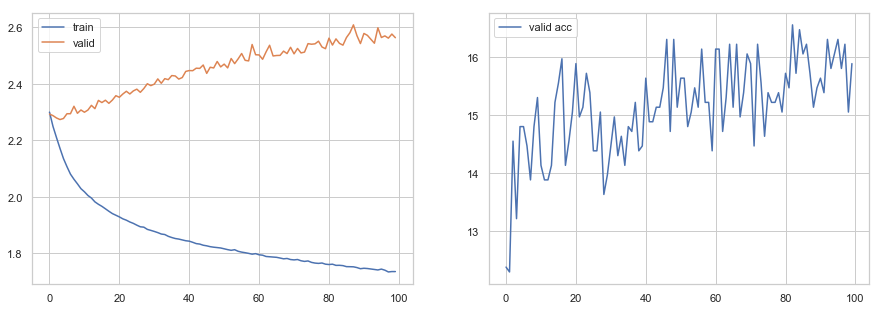

In [65]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x
model = MLP()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 100

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    if epoch%10==0:
        print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
             .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()
model.eval()
test_preds = torch.LongTensor()
test_true = torch.LongTensor()

for i, images in enumerate(test_loader):
    outputs = model(images[0])
    
    pred = outputs.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds, pred), dim=0)
    test_true = torch.cat((test_true, images[1]))
y_test = test_true.numpy()
y_pred = test_preds.numpy()

In [53]:
model.eval()
test_preds = torch.LongTensor()
test_true = torch.LongTensor()

for i, images in enumerate(test_loader):
    outputs = model(images[0])
    
    pred = outputs.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds, pred), dim=0)
    test_true = torch.cat((test_true, images[1]))

In [60]:
out_df = pd.DataFrame(index = np.arange(X_test.shape[0]))
out_df['predict'] = test_preds.numpy()
out_df['label'] = test_true.numpy()

out_df.head()
y_test = test_true.numpy()
y_pred = test_preds.numpy()

In [62]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix

def report_metrics(y_test, y_pred):
    scorers = {'accuracy': accuracy_score(y_test, y_pred),
           'recall': recall_score(y_test, y_pred,average=None),
           'precision': precision_score(y_test, y_pred,average=None),
           'f1': f1_score(y_test, y_pred,average=None),
           'mcc': matthews_corrcoef(y_test, y_pred)
    }
    for metric in scorers.keys():
        print('{} = {}'.format(metric, scorers[metric]))
    return scorers['f1'],scorers['accuracy'],scorers['recall'],scorers['precision'],scorers['mcc']

accuracy = 0.1505016722408027
recall = [0.125      0.14166667 0.16666667 0.18965517 0.11666667 0.10833333
 0.25833333 0.13333333 0.05833333 0.20833333]
precision = [0.12931034 0.15178571 0.16528926 0.21153846 0.08139535 0.12871287
 0.23484848 0.16666667 0.05982906 0.2       ]
f1 = [0.12711864 0.14655172 0.1659751  0.2        0.09589041 0.11764706
 0.24603175 0.14814815 0.05907173 0.20408163]
mcc = 0.05615549300598022


[Text(0, 0, 'accuracy'), Text(0, 0, 'mcc')]

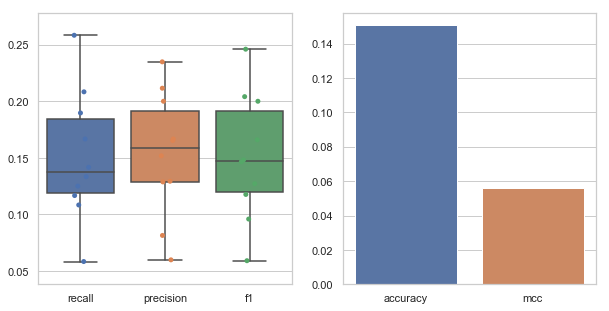

In [63]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
f1,accuracy,recall,precision,mcc = report_metrics(y_test, y_pred)
metrics_1 = np.concatenate((recall.reshape(-1,1),precision.reshape(-1,1),f1.reshape(-1,1)),axis=1)
sns.stripplot(data=metrics_1,ax=ax[0])
sns.boxplot(data=metrics_1,ax=ax[0])
ax[0].set_xticklabels(['recall','precision','f1'])
metrics_2=np.array([accuracy,mcc])
sns.barplot(data=pd.DataFrame(metrics_2.reshape(1,-1)),ax=ax[1])
ax[1].set_xticklabels(['accuracy','mcc'])

### logistic

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix

def report_metrics(y_test, y_pred):
    scorers = {'accuracy': accuracy_score(y_test, y_pred),
           'recall': recall_score(y_test, y_pred,average='weighted'),
           'precision': precision_score(y_test, y_pred,average='weighted'),
           'f1': f1_score(y_test, y_pred,average='weighted')
    }
    for metric in scorers.keys():
        print('{} = {}'.format(metric, scorers[metric]))


model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
report_metrics(y_test, y_pred)

accuracy = 0.16638795986622074
recall = 0.16638795986622074
precision = 0.16632199745782228
f1 = 0.16236441244542799


### attention

In [194]:
class MLP_feature_attention(nn.Module):
    '''
    attention with simple weight sharing
    
    '''
    def __init__(self, 
                 n_input = 50, n_hiddens = 32, n_hiddens_2 = 20,n_output = 10,):
        super(MLP_feature_attention, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hiddens = np.atleast_1d(n_hiddens)


        layers_attention = []
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.ReLU())
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.Sigmoid())
        self.attention = nn.Sequential(*layers_attention)

        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_hiddens_2 ))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=n_output)
    def forward(self, x):
        x_attention = self.attention(x)
        #print (x_attention.size())
        #x_attention = torch.cat((torch.clamp(x_attention[:,:self.feature_thres_ind],
          #                                   0,self.thres_cut),
             #                    x_attention[:,self.feature_thres_ind:]),1)

        x = torch.mul(x_attention,x).view(-1,self.n_input)
        x = self.encoder(x)
        
        return torch.nn.functional.log_softmax(x)
use_cuda = False
model =  MLP_feature_attention()
if use_cuda:
    model = model.cuda()

In [195]:
LEARNING_RATES = [0.01]
MOMENTUM_RATES = [.9]
WEIGHT_DECAY_RATES = [.005]
batch_size = 100
PLOT = 1
EPOCHS = 400
# Dataloader

train_data = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('int')))
test_data = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('int')))
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
                                          dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

Train Epoch: 100 [0/2960 (0%)]	Loss: 1.998157 Accuracy: (0.0105)


Validation set: Average loss: 2.3393, Accuracy: 201/1196 (0.1681)

Train Epoch: 200 [0/2960 (0%)]	Loss: 1.914695 Accuracy: (0.0111)


Validation set: Average loss: 2.3503, Accuracy: 217/1196 (0.1814)

Train Epoch: 300 [0/2960 (0%)]	Loss: 1.910921 Accuracy: (0.0125)


Validation set: Average loss: 2.3955, Accuracy: 215/1196 (0.1798)

Train Epoch: 400 [0/2960 (0%)]	Loss: 1.749672 Accuracy: (0.0145)


Validation set: Average loss: 2.3901, Accuracy: 220/1196 (0.1839)



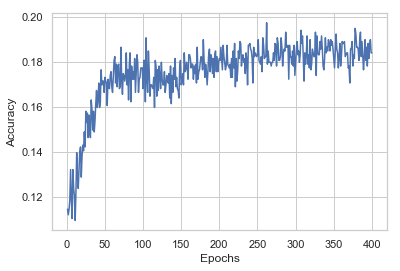

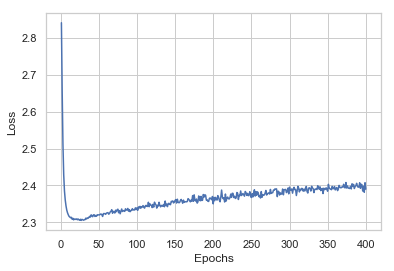

In [196]:
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 100)

In [198]:
class MLP_sample_attention(nn.Module):
    '''
    attention with simple weight sharing
    
    '''
    def __init__(self, 
                 n_input = 50, n_hiddens = 32, n_hiddens_2 = 20,n_output = 10,):
        super(MLP_sample_attention, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hiddens = np.atleast_1d(n_hiddens)


        layers_attention = []
        layers_attention.append(nn.Linear(n_input, n_input))
        layers_attention.append(nn.ReLU())
        layers_attention.append(nn.Linear(n_input, 1))
        layers_attention.append(nn.Sigmoid())
        self.attention = nn.Sequential(*layers_attention)

        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_hiddens_2 ))
        self.encoder = nn.Sequential(*layers)
        #self.softmax = nn.Softmax(dim=n_output)
    def forward(self, x):
        x_attention = self.attention(x)
        #print (x_attention.size())
        #x_attention = torch.cat((torch.clamp(x_attention[:,:self.feature_thres_ind],
          #                                   0,self.thres_cut),
             #                    x_attention[:,self.feature_thres_ind:]),1)

        x = torch.mul(x_attention,x).view(-1,self.n_input)
        x = self.encoder(x)
        
        return torch.nn.functional.log_softmax(x)
use_cuda = False
model =  MLP_sample_attention()
if use_cuda:
    model = model.cuda()

In [203]:
LEARNING_RATES = [0.01]
MOMENTUM_RATES = [.9]
WEIGHT_DECAY_RATES = [.005]
batch_size = 2000
PLOT = 1
EPOCHS = 2000
# Dataloader

train_data = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')), torch.from_numpy(y_train.astype('int')))
test_data = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')), torch.from_numpy(y_test.astype('int')))
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
                                          dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

Using PyTorch version: 1.0.0 CUDA: False


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Train Epoch: 100 [0/2960 (0%)]	Loss: 1.766583 Accuracy: (0.2551)


Validation set: Average loss: 2.4030, Accuracy: 227/1196 (0.1898)

Train Epoch: 200 [0/2960 (0%)]	Loss: 1.768756 Accuracy: (0.2537)


Validation set: Average loss: 2.4025, Accuracy: 228/1196 (0.1906)

Train Epoch: 300 [0/2960 (0%)]	Loss: 1.768731 Accuracy: (0.2605)


Validation set: Average loss: 2.4023, Accuracy: 228/1196 (0.1906)

Train Epoch: 400 [0/2960 (0%)]	Loss: 1.757259 Accuracy: (0.2642)


Validation set: Average loss: 2.4044, Accuracy: 226/1196 (0.1890)

Train Epoch: 500 [0/2960 (0%)]	Loss: 1.756067 Accuracy: (0.2632)


Validation set: Average loss: 2.4031, Accuracy: 230/1196 (0.1923)

Train Epoch: 600 [0/2960 (0%)]	Loss: 1.754642 Accuracy: (0.2591)


Validation set: Average loss: 2.4051, Accuracy: 228/1196 (0.1906)

Train Epoch: 700 [0/2960 (0%)]	Loss: 1.744951 Accuracy: (0.2618)


Validation set: Average loss: 2.4052, Accuracy: 228/1196 (0.1906)

Train Epoch: 800 [0/2960 (0%)]	Loss: 1.747049 Accuracy: (0.262

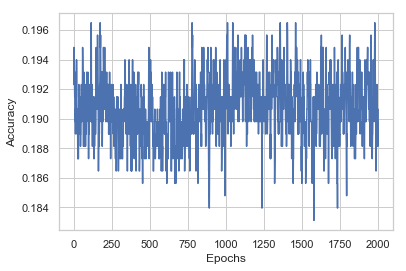

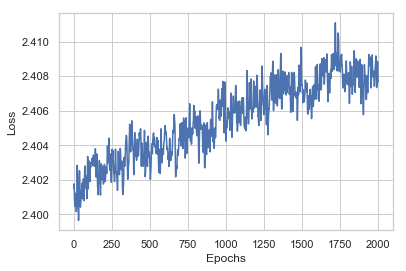

In [204]:
main(train_loader,test_loader,LEARNING_RATES , MOMENTUM_RATES ,WEIGHT_DECAY_RATES,report_interval = 100)

- [ ] add more regularization like CRLR in attention weight
    - [ ] feature level(above)
    - [ ] sample level (need to increase batch size a lot), try to implement CR

### CR attention

### MDN